# Analyse Exploratoire du jeu de Données `OpenFoodFacts`
*Les liens ne fonctionnent pas lorsque le notebook est affiché sur **Github**. Donc vous souhaitez visualiser ce notebook en ligne avec les liens menu actifs, vous pouvez le faire à cette adresse: https://nbviewer.org/github/Valkea/OC_AI_03/blob/main/Cleaning_02_Nutriscore.ipynb )*

* [1. Objectif du projet](#P01)
* [2. Présentation générale du jeu de données](#P02)
* [3. Préselection des colonnes utiles](#P03)
* [4. Nettoyage du jeu de données](#P04)
    * [Suppression des lignes vides](#clean_empties)
    * [Suppression des doublons](#clean_duplicates)
    * [Suppression des valeurs aberrantes](#clean_outliers)
    * [Corrélations linéaires](#clean_correlations)
    * [Imputations des valeurs manquantes](#clean_imputations)
    * [Suppression des lignes aux valeurs nutritionnelles illogiques](#clean_logic)
* [5. Démarche méthodologique d’analyse de données](#P05)
    * [Analyses univariées](#analysis_univariate)
    * [Analyses multivariées](#analysis_multivariate)
    * [Analyse en composantes principales](#pca)
    * [Test statistique](#anova)
* [6. Conclusions](#conclusion)

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

# import FreeMobileSMS as sms # Script perso pour recevoir un SMS quand mes calculs sont faits (non inclus dans le dépôt git)

# 1. Objectif  <a class="anchor" id="P01"></a>

Le Nutri-grade est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce grade à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

**Nous allons donc essayer de calculer le nutri-grade en nous basant sur les données disponibles sur l'étiquette d'un produit.**

En cherchant sur le site https://www.santepubliquefrance.fr on peut trouver des [informations](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

#### Précisions utiles

- Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.
- Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

# 2. Présentation générale du jeu de données <a class="anchor" id="P02"></a>

Le [jeu de données](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) utilisé dans le cadre de l'appel à projets de l'agence *Santé publique France* qui consiste à rendre les données de santé plus accessibles, est une liste de 2.251.894 produits alimentaires répertoriés par les volontaires de l'association [Open Food Facts](https://world.openfoodfacts.org).

Chacun des produits référencé est décrit par un certain nombre de caractèristiques nutritionels *(taux de graisse, de sucre, de sel, de fibres, de protéines, de vitamines, etc.)* et par des méta-données *(code-barre, nom du produit, catégorie, lieu de production, date d'ajout dans la DB, auteur de l'ajout, etc.)*.

> Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée,<br> donc **nous avons crée un jeu de données réduit (dans Cleaning_01.ipynb) que nous allons utiliser ici**.

#### Commençons par charger les colonnes (et leur dtype) sélectionnées dans le premier notebook

In [2]:
filename = 'data/dtypes_low.csv'

In [3]:
dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

In [4]:
cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

In [5]:
cols_to_keep

Index(['energy_100g', 'sugars_100g', 'code', 'main_category', 'labels_tags',
       'nova_group', 'calcium_100g', 'vitamin-c_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'allergens',
       'nutriscore_grade', 'pnns_groups_2', 'vitamin-a_100g', 'fiber_100g',
       'quantity', 'additives_tags', 'saturated-fat_100g', 'nutriscore_score',
       'proteins_100g', 'salt_100g', 'states_tags', 'serving_size',
       'iron_100g', 'carbohydrates_100g', 'product_name', 'fat_100g',
       'cholesterol_100g', 'sodium_100g', 'traces_tags', 'serving_quantity',
       'additives_n', 'trans-fat_100g', 'pnns_groups_1', 'ingredients_tags',
       'categories_tags', 'url'],
      dtype='object')

#### Puis chargeons le jeu de données réduit

In [6]:
filename = 'data/en.openfoodfacts.org.products.csv'

In [7]:
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_keep)

### Explorons le jeu de données réduit

In [8]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses      NaN             NaN         NaN   
1           L.casei      NaN             NaN         NaN   
2  Vitória crackers      NaN             NaN         NaN   

                                    ingredients_tags allergens traces_tags  \
0                                                NaN       NaN         NaN   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...       NaN         NaN   
2                                                NaN       NaN         NaN   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0          NaN  ...          NaN         NaN           NaN        NaN   
1          NaN  ...          9.8         NaN           2.7        0.1   
2          NaN  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

> En voyant tous les `NaN` ci-dessus *(et retroactivement pour faciliter les analyses, car ils ne tons pas tous comptés comme None)*, nous allons remplacer les valeurs neutres par des `None` dans les colonnes numériques.

#### Remplaçons les diverses instances de types NaN ou équivalents dans les colonnes numériques par None

In [9]:
fill_rate_before = data.notnull().mean(axis=0)

In [10]:
for cat in data.columns:
    col_dtype = data[cat].dtype
    data[cat].replace(['unknown',np.NaN, "NaN", '<NA>'], None, inplace=True)
    data[cat] = data[cat].astype(col_dtype)

In [11]:
fill_rate_after = data.notnull().mean(axis=0)

In [12]:
col_size = 15
print(f"{'COLONNE'.rjust(55)} | {'REMPLISSAGE AVANT'.center(col_size)} | {'REMPLISSAGE APRES'.center(col_size)} | {'DIFF'.center(11)}\n{'-'*111}")
for n, f1, f2 in zip(fill_rate_before.index, fill_rate_before, fill_rate_after):
    print(f"{n.rjust(55)} | {100.0*f1:16.2f}% | {100.0*f2:16.2f}% | {100.0*(f2-f1):8.4f}%")

                                                COLONNE | REMPLISSAGE AVANT | REMPLISSAGE APRES |     DIFF   
---------------------------------------------------------------------------------------------------------------
                                                   code |           100.00% |           100.00% |   0.0000%
                                                    url |           100.00% |           100.00% |   0.0000%
                                           product_name |            96.19% |            96.19% |  -0.0001%
                                               quantity |            25.59% |            25.59% |   0.0000%
                                        categories_tags |            44.90% |            44.90% |   0.0000%
                                            labels_tags |            20.52% |            20.52% |   0.0000%
                                       ingredients_tags |            33.46% |            33.46% |   0.0000%
                      

In [13]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses     None            None        None   
1           L.casei     None            None        None   
2  Vitória crackers     None            None        None   

                                    ingredients_tags allergens traces_tags  \
0                                               None      None        None   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...      None        None   
2                                               None      None        None   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0         None  ...          NaN         NaN           NaN        NaN   
1         None  ...          9.8         NaN           2.7        0.1   
2         None  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

Et reprenons l'exploration des données

In [14]:
data.shape

(2251894, 36)

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [16]:
data.describe().T

count  \
serving_quantity                                    526776.000   
additives_n                                         755169.000   
nutriscore_score                                    776383.000   
energy_100g                                        1786722.000   
fat_100g                                           1777186.000   
saturated-fat_100g                                 1731439.000   
trans-fat_100g                                      265364.000   
cholesterol_100g                                    269384.000   
carbohydrates_100g                                 1776746.000   
sugars_100g                                        1758313.000   
fiber_100g                                          639994.000   
proteins_100g                                      1778610.000   
salt_100g                                          1640254.000   
sodium_100g                                        1640251.000   
vitamin-a_100g                                      212955.000   
vitamin-c_100g                                      220782.000   
calcium_100g                                        271880.000   
iron_100g                                           265735.000   
fruits-vegetables-nuts-estimate-from-ingredient...  753817.000   

                                                                                             mean  \
serving_quantity                                                            21092745435793836.000   
additives_n                                                                                 2.013   
nutriscore_score                                                                            9.091   
energy_100g                                             3730607721228534090965745911682039808.000   
fat_100g                                                                         562754208033.989   
saturated-fat_100g                                                                      57722.281   
trans-fat_100g                                                                              0.162   
cholesterol_100g                                                                            0.060   
carbohydrates_100g                                                                      56274.039   
sugars_100g                                                                          56929545.382   
fiber_100g                                         153333860029341582185095018443795150667776.000   
proteins_100g                                                                           56198.842   
salt_100g                                                                               60928.005   
sodium_100g                                                                             24371.247   
vitamin-a_100g                                                                              1.671   
vitamin-c_100g                                                                              0.114   
calcium_100g                                                                              736.131   
iron_100g                                                                                   0.038   
fruits-vegetables-nuts-estimate-from-ingredient...                                          8.602   

                                                                                                 std  \
serving_quantity                                                            15308918127999203328.000   
additives_n                                                                                    2.880   
nutriscore_score                                                                               8.849   
energy_100g                                             4986640698625920150338062244302641168384.000   
fat_100g                                                                         750124863814886.500   
saturated-fat_100g                                                                      759

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [17]:
data.describe(exclude="number").T

count   unique  \
code              2251894  2251873   
url               2251894  2251876   
product_name      2166178  1387468   
quantity           576236    39373   
categories_tags   1011088    79235   
labels_tags        462090    64122   
ingredients_tags   753418   569887   
allergens          199182     7300   
traces_tags        136399    13774   
serving_size       530697    47576   
additives_tags     434228   103551   
nutriscore_grade   776383        5   
nova_group         679561        4   
pnns_groups_1      816330       11   
pnns_groups_2      816332       41   
states_tags       2251894     4795   
main_category     1011088    35204   

                                                                top    freq  
code                                                  3477610001135       2  
url               http://world-en.openfoodfacts.org/product/3477...       2  
product_name                                                   Miel    1449  
quantity                                                      500 g   24211  
categories_tags                                           en:snacks   34325  
labels_tags                                              en:organic   47495  
ingredients_tags  en:extra-virgin-olive-oil,en:oil-and-fat,en:ve...    1391  
allergens                                                   en:milk   42134  
traces_tags                                                 en:nuts   13203  
serving_size                                                   100g   24366  
additives_tags                                              en:e330   26240  
nutriscore_grade                                                  d  240061  
nova_group                                                        4  440248  
pnns_groups_1                                         Sugary snacks  169128  
pnns_groups_2                                                Sweets   76620  
states_tags       en:to-be-completed,en:nutrition-facts-complete...  389036  
main_category                                             en:snacks   34348

> Sur la base des colonnes `code` et `url` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer.
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [18]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def print_fill_rate(dataset, col_array):
    fill_count = dataset[col_array].notnull().sum()
    fill_ratio = fill_count/dataset.shape[0]*100.0
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    col_size = 15
    
    print(f"{'COLONNE'.rjust(max_size)} | {'LIGNES VIDES'.center(col_size)} | {'REMPLISSAGE'.rjust(col_size)} \n{'-'*111}")
    
    for k, v in zip(fill_count.keys(), fill_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(max_size)} | {total-v:15} | {fraction:15.2f}%")
        
    return fill_ratio

In [23]:
fill_ratio = print_fill_rate(data, data.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
              code |               0 |          100.00%
               url |               0 |          100.00%
      product_name |           85716 |           96.19%
          quantity |         1675658 |           25.59%
   categories_tags |         1240806 |           44.90%
       labels_tags |         1789804 |           20.52%
  ingredients_tags |         1498476 |           33.46%
         allergens |         2052712 |            8.85%
       traces_tags |         2115495 |            6.06%
      serving_size |         1721197 |           23.57%
  serving_quantity |         1725118 |           23.39%
       additives_n |         1496725 |           33.53%
    additives_tags |         1817666 |           19.28%
  nutriscore_score |         1475511 |           34.48%
  nutriscore_grade |         1475511 |          

> Visiblement, même allégé des colonnes les plus vides, ce jeu de données présente encore beaucoup de trous.

#### Affichons ces taux sous forme de graphique interactif

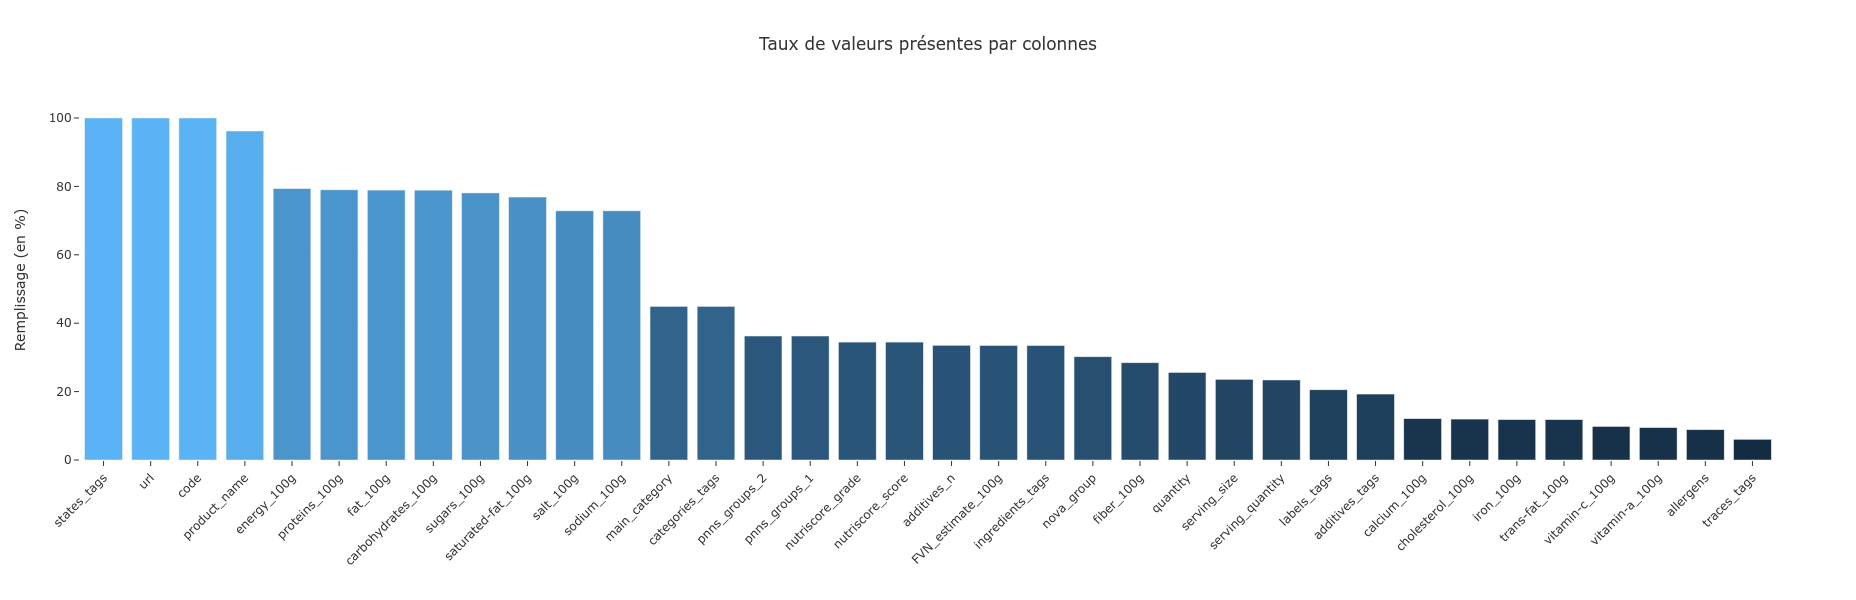

In [24]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=600,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
            )
fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45, categoryorder="total descending")
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'}) # fond transparent pour l'export
fig.show()

#### On peut également regarder comment se répartissent ces valeurs manquantes

<AxesSubplot:>

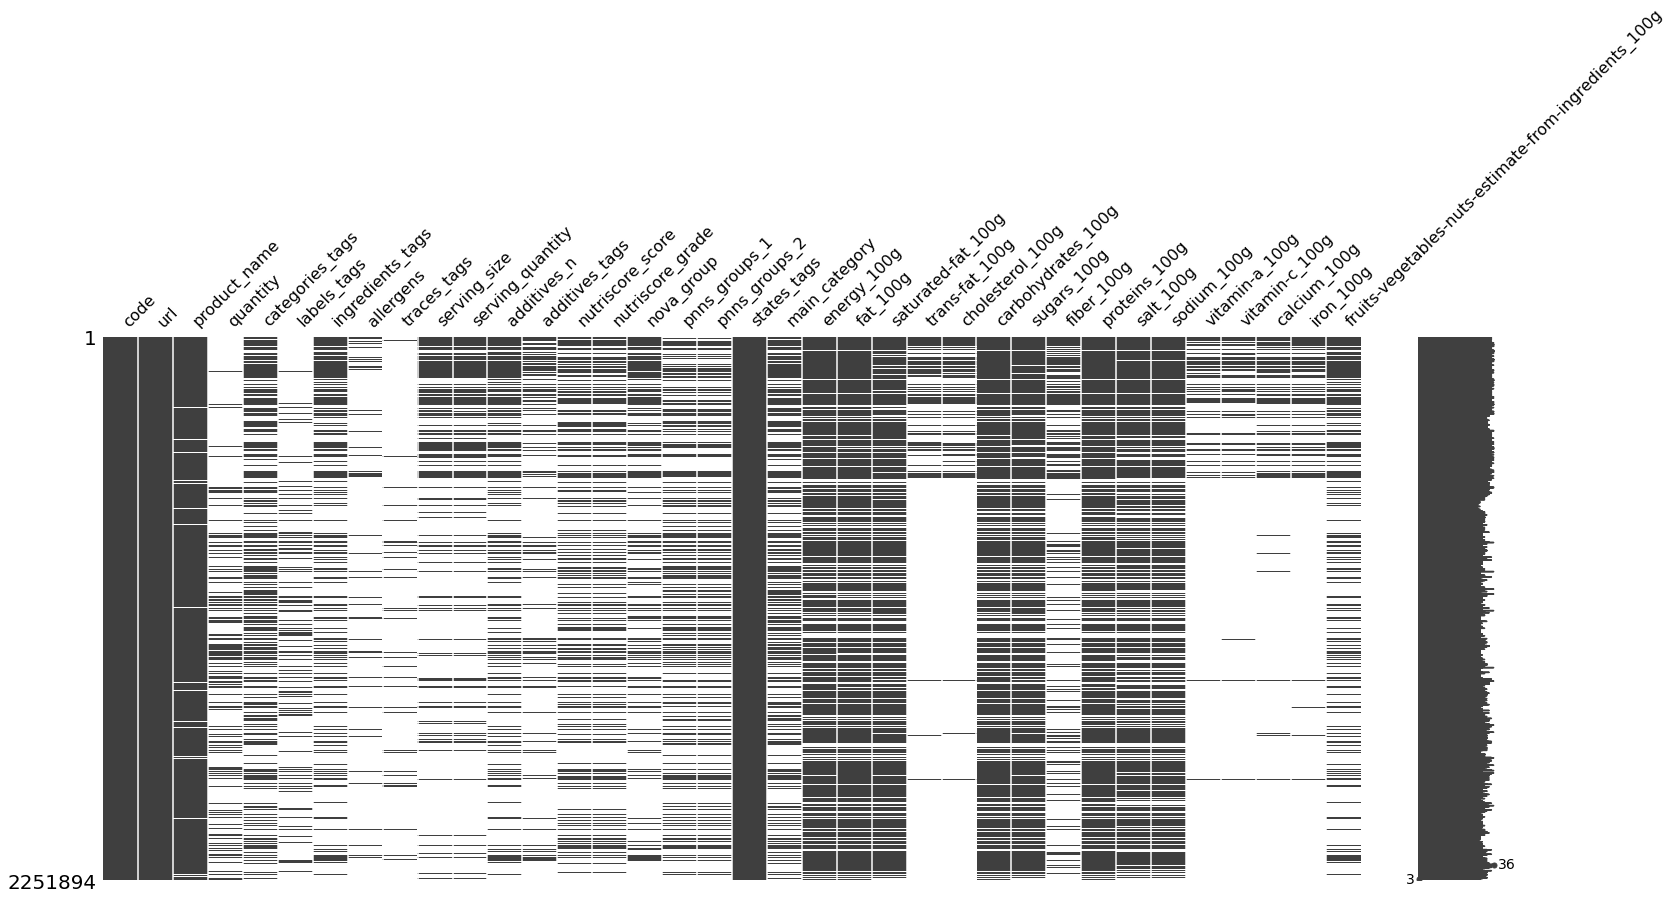

In [21]:
import missingno as msno
msno.matrix(data)

#### Avant d'aller plus loin, renommons la colonne `fruits-vegetables-nuts-estimate-from-ingredients_100g`
pour faciliter la visualisation des tableaux & graphiques à venir

In [22]:
data.rename(columns={'fruits-vegetables-nuts-estimate-from-ingredients_100g':'FVN_estimate_100g'}, inplace=True)

# 3. Préselection des colonnes utiles <a class="anchor" id="P03"></a>

Malgré une première sélection, il reste encore beaucoup de colonnes dans ce jeu de données. Nous allons donc nous appuyer sur les les indications de la documentation du Nutri-grade pour essayer de trouver les colonnes les plus utiles ([Voir les infos dans l'objectif du projet](#P01))

Pour rappel, voici les éléments utilisés dans le calcule du Nutri-score et donc du Nutri-grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

In [25]:
data.columns

Index(['code', 'url', 'product_name', 'quantity', 'categories_tags',
       'labels_tags', 'ingredients_tags', 'allergens', 'traces_tags',
       'serving_size', 'serving_quantity', 'additives_n', 'additives_tags',
       'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1',
       'pnns_groups_2', 'states_tags', 'main_category', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'FVN_estimate_100g'],
      dtype='object')

### `Informations nutritionelles`
> Prenons déjà tous les indicateurs nutritionnels `*_100g`

In [26]:
var_selected = {x for x in data.columns if x.endswith('_100g')}

### `Informations de catégorisation du produit`

> Afin de pouvoir explorer la relation entre le type de produit et les variables que nous avons gardé précédemment, nous allons garder une colonne de catégorisation.

> Il y a trois variables qui pourraient servir à catégoriser les produits; `main_category`, `pnns_groups_1` et `pnns_groups_2`.

#### Regardons les trois colonnes candidates plus en détails

In [27]:
from itertools import zip_longest

In [28]:
def eval_groups(maxiter=20):
    x = data.main_category.value_counts(dropna=False)
    y = data.pnns_groups_1.value_counts(dropna=False)
    z = data.pnns_groups_2.value_counts(dropna=False)

    size=25
    print(f"{'main_category'.upper().rjust(size+9)}\t{'pnns_groups_1'.upper().rjust(size+9)}\t{'pnns_groups_2'.upper().rjust(size+9)}\n{'-'*115}")
    for i,(ai,a, bi,b, ci,c) in enumerate(zip_longest(x.index,x, y.index, y,z.index, z)):
        a = 0 if a == None else a
        b = 0 if b == None else b
        c = 0 if c == None else c
        print(f"{str(ai)[:size].rjust(size)} :{a:7}\t{str(bi)[:size].rjust(size)} :{b:7}\t{str(ci)[:size].rjust(size)} :{c:7}")
        if i > maxiter:
            break
            
eval_groups(15)

                     MAIN_CATEGORY	                     PNNS_GROUPS_1	                     PNNS_GROUPS_2
-------------------------------------------------------------------------------------------------------------------
                     None :1240806	                     None :1435564	                     None :1435562
                en:snacks :  34348	            Sugary snacks : 169128	                   Sweets :  76620
                en:sauces :  17325	           Fish Meat Eggs : 115304	       Biscuits and cakes :  68817
              en:biscuits :  16543	  Milk and dairy products : 102191	     Dressings and sauces :  54952
       en:confectioneries :  16450	     Cereals and potatoes :  95113	                   Cheese :  50954
               en:cheeses :  16364	           Fat and sauces :  78861	           One-dish meals :  46234
             en:beverages :  12693	                Beverages :  74848	                  Cereals :  45444
                en:breads :  10484	    Fruit

#### Regardons le nombre de catégories dans chaque colonne

In [29]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].nunique()

main_category    35204
pnns_groups_1       11
pnns_groups_2       41
dtype: int64

#### Affichons leurs taux de remplissage

In [30]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].notnull().mean(0)

main_category   0.449
pnns_groups_1   0.363
pnns_groups_2   0.363
dtype: float64

> Bien que `main_category` soit légèrement plus remplie que les deux autres (après le nettoyage des NaN fait plus haut...), le découpage qui apparait dans `pnns_groups_2` semble être le plus intéressant car moins granulaire; on va donc prendre cette colonne.

In [31]:
var_selected.add('pnns_groups_2')

### `Informations d'identification du produit`

> Pour aider à trouver les doublons, on va ajouter les variables `code` et `product_name`.

In [32]:
var_selected.add('code')
var_selected.add('product_name')

### `Scores de référence`
> Comme le propos est de travailler sur le nutri-grade, il convient d'ajouter les colonnes concernées... mais c'est aussi l'occasion d'étudier le comportement du nova_group, donc on l'ajoute aussi.

In [33]:
var_selected.add('nutriscore_score')
var_selected.add('nutriscore_grade')
var_selected.add('nova_group') # Pour comparaison

### Colonnes séléctionnées pour une application de prédiction du Nutri-grade

In [34]:
var_selected = sorted(sorted(var_selected), key=lambda x: x.endswith('_100g'), reverse=False)
var_selected

['code',
 'nova_group',
 'nutriscore_grade',
 'nutriscore_score',
 'pnns_groups_2',
 'product_name',
 'FVN_estimate_100g',
 'calcium_100g',
 'carbohydrates_100g',
 'cholesterol_100g',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'iron_100g',
 'proteins_100g',
 'salt_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'sugars_100g',
 'trans-fat_100g',
 'vitamin-a_100g',
 'vitamin-c_100g']

In [35]:
data_nutri = data[[*var_selected]]

### Explorons à nouveau ce jeu de données réduits pour les besoins de l'application

In [36]:
data_nutri.shape

(2251894, 22)

In [37]:
data_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251894 entries, 0 to 2251893
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   code                object 
 1   nova_group          object 
 2   nutriscore_grade    object 
 3   nutriscore_score    float64
 4   pnns_groups_2       object 
 5   product_name        object 
 6   FVN_estimate_100g   float64
 7   calcium_100g        float64
 8   carbohydrates_100g  float64
 9   cholesterol_100g    float64
 10  energy_100g         float64
 11  fat_100g            float64
 12  fiber_100g          float64
 13  iron_100g           float64
 14  proteins_100g       float64
 15  salt_100g           float64
 16  saturated-fat_100g  float64
 17  sodium_100g         float64
 18  sugars_100g         float64
 19  trans-fat_100g      float64
 20  vitamin-a_100g      float64
 21  vitamin-c_100g      float64
dtypes: float64(17), object(5)
memory usage: 378.0+ MB


In [38]:
data_nutri.describe().T

count                                           mean  \
nutriscore_score    776383.000                                          9.091   
FVN_estimate_100g   753817.000                                          8.602   
calcium_100g        271880.000                                        736.131   
carbohydrates_100g 1776746.000                                      56274.039   
cholesterol_100g    269384.000                                          0.060   
energy_100g        1786722.000      3730607721228534090965745911682039808.000   
fat_100g           1777186.000                               562754208033.989   
fiber_100g          639994.000 153333860029341582185095018443795150667776.000   
iron_100g           265735.000                                          0.038   
proteins_100g      1778610.000                                      56198.842   
salt_100g          1640254.000                                      60928.005   
saturated-fat_100g 1731439.000                                      57722.281   
sodium_100g        1640251.000                                      24371.247   
sugars_100g        1758313.000                                   56929545.382   
trans-fat_100g      265364.000                                          0.162   
vitamin-a_100g      212955.000                                          1.671   
vitamin-c_100g      220782.000                                          0.114   

                                                                 std      min  \
nutriscore_score                                               8.849  -15.000   
FVN_estimate_100g                                             36.118    0.000   
calcium_100g                                              383567.119    0.000   
carbohydrates_100g                                      74971304.959   -1.000   
cholesterol_100g                                               1.951    0.000   
energy_100g             4986640698625920150338062244302641168384.000    0.000   
fat_100g                                         750124863814886.500    0.000   
fiber_100g         122666513020150478865288974968710559086673920.000   -6.700   
iron_100g                                                      6.442   -0.000   
proteins_100g                                           74932009.551 -500.000   
salt_100g                                               78028308.222    0.000   
saturated-fat_100g                                      75945867.241    0.000   
sodium_100g                                             31211351.831    0.000   
sugars_100g                                          75414025717.789   -1.000   
trans-fat_100g                                                29.665    0.000   
vitamin-a_100g                                               371.121   -0.000   
vitamin-c_100g                                                21.591    0.000   

                       25%      50%      75%  \
nutriscore_score     1.000   10.000   16.000   
FVN_estimate_100g    0.000    0.000    0.500   
calcium_100g         0.000    0.036    0.111   
carbohydrates_100g   3.529   15.380   53.000   
cholesterol_100g     0.000    0.000    0.022   
energy_100g        418.000 1079.000 1674.000   
fat_100g             0.800    7.000   21.200   
fiber_100g           0.000    1.600    3.700   
iron_100g            0.000    0.001    0.002   
proteins_100g        1.300    6.000   12.500   
salt_100g            0.083    0.590    1.400   
saturated-fat_100g   0.100    1.800    7.000   
sodium_100g          0.033    0.236    0.560   
sugars_100g          0.600    3.570   17.100   
trans-fat_100g       0.000    0.000    0.000   
vitamin-a_100g       0.000    0.000    0.000   
vitamin-c_100g       0.000    0.000    0.004   

                                                                  max  
nutriscore_score                                               40.000  
FVN_estimate_100g                                           13461.000  
calcium_100g              

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [39]:
data_nutri.describe(exclude="number").T

count   unique            top    freq
code              2251894  2251873  3477610001135       2
nova_group         679561        4              4  440248
nutriscore_grade   776383        5              d  240061
pnns_groups_2      816332       41         Sweets   76620
product_name      2166178  1387468           Miel    1449

> Sur la base des colonnes `code` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer ([voir ici](#clean_duplicates)).
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [40]:
fill_ratio = print_fill_rate(data_nutri, data_nutri.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
              code |               0 |          100.00%
        nova_group |         1572333 |           30.18%
  nutriscore_grade |         1475511 |           34.48%
  nutriscore_score |         1475511 |           34.48%
     pnns_groups_2 |         1435562 |           36.25%
      product_name |           85716 |           96.19%
 FVN_estimate_100g |         1498077 |           33.47%
      calcium_100g |         1980014 |           12.07%
carbohydrates_100g |          475148 |           78.90%
  cholesterol_100g |         1982510 |           11.96%
       energy_100g |          465172 |           79.34%
          fat_100g |          474708 |           78.92%
        fiber_100g |         1611900 |           28.42%
         iron_100g |         1986159 |           11.80%
     proteins_100g |          473284 |          

<AxesSubplot:>

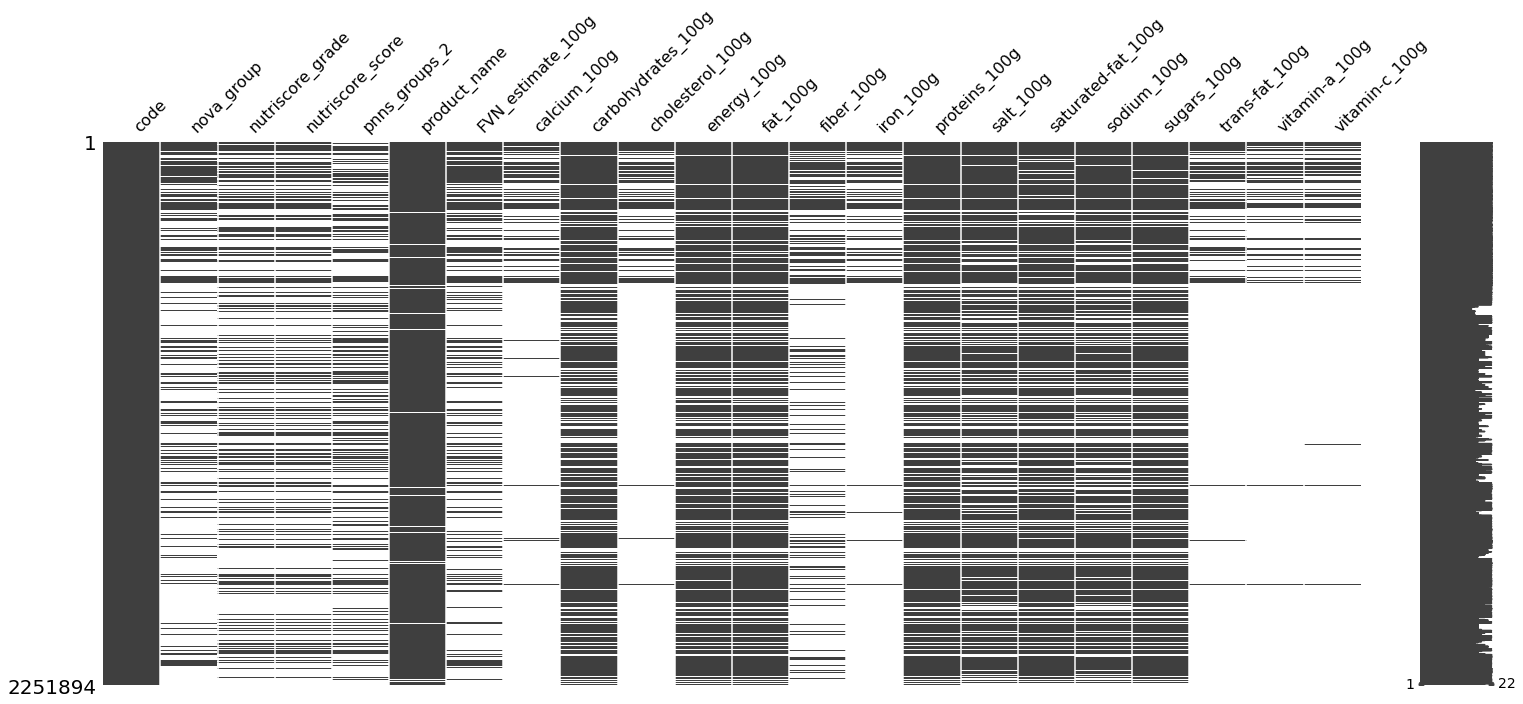

In [41]:
msno.matrix(data_nutri)

# 4. Nettoyage du jeu de données <a class="anchor" id="P04"></a>

In [44]:
data_clean = data_nutri.copy()

## 4.1 Suppression des lignes où toutes les valeurs nutritionnelles sont vides <a class="anchor" id="clean_empties"></a>

In [45]:
data_tmp = data_clean.copy()

In [46]:
selection = list(data_tmp.select_dtypes(include=np.number).columns)
selection.remove('nutriscore_score')

In [47]:
data_tmp = data_tmp[data_tmp[selection].notnull().apply(lambda x: any(x), axis=1)]
data_tmp.shape

(1897391, 22)

> Le nombre de lignes restantes semble raisonnable.

#### Appliquons la modification sur data_clean

In [48]:
data_clean.shape

(2251894, 22)

In [49]:
data_clean = data_tmp.copy()
data_clean.shape

(1897391, 22)

## 4.2 Suppression des doublons <a class="anchor" id="clean_duplicates"></a>
Pour ce faire, nous allons nous appuyer sur la colonne `code` dans un premier temps, et sur le reste des colonnes dans un second temps.

In [50]:
data_clean['code'].describe()

count           1897391
unique          1897374
top       3700320230572
freq                  2
Name: code, dtype: object

In [51]:
data_clean['code'].isnull().sum()

0

In [52]:
data_clean.shape[0] - len(data_clean['code'].unique())

17

> Toutes les lignes du jeu de donnée ont un code, et 17 d'entre elles sont des doublons.

#### Supprimons les doublons sur `code`

In [53]:
data_tmp = data_clean.copy()

In [54]:
duplicated = data_tmp.code.duplicated(keep='first')
duplicated.sum()

17

In [55]:
data_tmp.drop_duplicates(subset=['code'], keep='first', inplace=True) 

> Nous avons donc supprimé 17 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre

In [56]:
cols_without_code = list(data_tmp.columns)
cols_without_code.remove("code")

In [57]:
duplicated = data_tmp[cols_without_code].duplicated(keep='first')
duplicated.sum()

89614

> Il y a 89614 produits qui sans considérer le code-barre sont totalement identiques à un autre.
>
> Dans la mesure où ouvrir plusieurs fois le même produit avec exactement les même valeurs ne semble pas utile, supprimons les.

In [58]:
data_tmp.shape

(1897374, 22)

In [59]:
data_tmp.drop_duplicates(subset=cols_without_code, keep='first', inplace=True)

In [60]:
data_tmp.shape

(1807760, 22)

In [61]:
duplicated = data_tmp[cols_without_code].duplicated(keep='first')
duplicated.sum()

0

> Il n'y a visiblement pas d'autres doublons.

#### Reportons les modifications sur le data_clean

In [62]:
data_clean.shape

(1897391, 22)

In [63]:
data_clean = data_tmp.copy()
data_clean.shape

(1807760, 22)

## 4.3 Suppression des valeurs aberrantes <a class="anchor" id="clean_outliers"></a>

In [64]:
data_tmp = data_clean.copy()

Les valeurs nutritionnelles `*_100g` ne peuvent logiquement pas dépasser les 100g, ni avoir moins de 0g.

Deux options se présentent à nous:
1. Remplacer les valeurs aberrantes par des None et les imputer ensuite.
2. Supprimer les lignes qui présentent des valeurs aberrantes en partant du principe que si une donnée de la ligne est fausse, les autres sont incertaines.

> Nous allons donc procèder en deux temps... d'abord supprimer les lignes qui sont en dehors de l'intervalle logique [0,100], puis ensuite remplacer les valeurs aberrantes en regard des valeurs maximum connues pour un nutriment donnée.

#### Supprimons les lignes dont les valeurs nutritionnelles sont hors intervalle [0,100] 
Sauf `energy_100g` qui est en kj.

In [65]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g') and x != 'energy_100g']

In [66]:
data_tmp[var_nutri].describe().T

count                                           mean  \
FVN_estimate_100g   721955.000                                          8.599   
calcium_100g        258531.000                                        774.135   
carbohydrates_100g 1701876.000                                      58748.897   
cholesterol_100g    255239.000                                          0.062   
fat_100g           1702147.000                               587563177538.591   
fiber_100g          622228.000 157711884414745778957552239679481223053312.000   
iron_100g           252498.000                                          0.040   
proteins_100g      1703623.000                                      58671.971   
salt_100g          1565683.000                                      63829.844   
saturated-fat_100g 1657147.000                                      60309.757   
sodium_100g        1565680.000                                      25531.987   
sugars_100g        1682173.000                                   59506340.333   
trans-fat_100g      251136.000                                          0.170   
vitamin-a_100g      202767.000                                          1.754   
vitamin-c_100g      210426.000                                          0.119   

                                                                 std      min  \
FVN_estimate_100g                                             36.536    0.000   
calcium_100g                                              393345.049    0.000   
carbohydrates_100g                                      76602648.700   -1.000   
cholesterol_100g                                               2.004    0.000   
fat_100g                                         766481135892588.625    0.000   
fiber_100g         124405389717845841549860044370365748768407552.000   -6.700   
iron_100g                                                      6.609   -0.000   
proteins_100g                                           76563362.298 -500.000   
salt_100g                                               79864876.706    0.000   
saturated-fat_100g                                      77629578.140    0.000   
sodium_100g                                             31945981.288    0.000   
sugars_100g                                          77101866067.448   -1.000   
trans-fat_100g                                                30.494    0.000   
vitamin-a_100g                                               380.330   -0.000   
vitamin-c_100g                                                22.116    0.000   

                     25%    50%    75%  \
FVN_estimate_100g  0.000  0.000  0.860   
calcium_100g       0.000  0.038  0.111   
carbohydrates_100g 3.800 16.129 53.300   
cholesterol_100g   0.000  0.000  0.022   
fat_100g           0.800  7.000 21.000   
fiber_100g         0.000  1.600  3.700   
iron_100g          0.000  0.001  0.002   
proteins_100g      1.300  6.000 12.000   
salt_100g          0.085  0.580  1.400   
saturated-fat_100g 0.100  1.790  7.000   
sodium_100g        0.034  0.232  0.560   
sugars_100g        0.680  3.600 18.000   
trans-fat_100g     0.000  0.000  0.000   
vitamin-a_100g     0.000  0.000  0.000   
vitamin-c_100g     0.000  0.000  0.004   

                                                                  max  
FVN_estimate_100g                                           13461.000  
calcium_100g                                            200000000.000  
carbohydrates_100g                                    99932728111.000  
cholesterol_100g                                              381.000  
fat_100g                                      1000000000000000000.000  
fiber_100g         98132750415618438665845168411918503733975056384...  
iron_100g                                                    1800.000  
proteins_100g                                         99932728111.000  
salt_100g                                             99932728111.000  
saturated-fat_100g                    

In [67]:
# Définissons une fonction permettant de supprimer les lignes qui présentent des valeurs hors intervalle

def drop_row_values(dt, col_name, min_v=None, max_v=None):
    count_start = dt.shape[0]
    
    dt = dt[((dt[col_name].notnull()) & (dt[col_name] >= min_v) & (dt[col_name] <= max_v)) | (dt[col_name].isnull())]
        
    count_end = dt[col_name].shape[0]
    print(f"On a supprimé {count_start-count_end:6} lignes sur {col_name}")
        
    return dt

In [68]:
for col in var_nutri:
    data_tmp = drop_row_values(data_tmp, col, min_v=0, max_v=100)

On a supprimé   1078 lignes sur FVN_estimate_100g
On a supprimé    155 lignes sur calcium_100g
On a supprimé    422 lignes sur carbohydrates_100g
On a supprimé      9 lignes sur cholesterol_100g
On a supprimé    172 lignes sur fat_100g
On a supprimé     63 lignes sur fiber_100g
On a supprimé      8 lignes sur iron_100g
On a supprimé     66 lignes sur proteins_100g
On a supprimé   1221 lignes sur salt_100g
On a supprimé     28 lignes sur saturated-fat_100g
On a supprimé      0 lignes sur sodium_100g
On a supprimé     33 lignes sur sugars_100g
On a supprimé     26 lignes sur trans-fat_100g
On a supprimé    150 lignes sur vitamin-a_100g
On a supprimé      3 lignes sur vitamin-c_100g


In [69]:
data_tmp.shape

(1804326, 22)

In [70]:
data_outliers_after = data_tmp[var_nutri]

In [71]:
data_tmp[var_nutri].describe().T

count   mean    std   min   25%    50%    75%     max
FVN_estimate_100g   720033.000  8.232 21.543 0.000 0.000  0.000  0.700 100.000
calcium_100g        258153.000  0.137  1.528 0.000 0.000  0.038  0.111 100.000
carbohydrates_100g 1698676.000 28.531 27.864 0.000 3.800 16.100 53.300 100.000
cholesterol_100g    254982.000  0.048  1.308 0.000 0.000  0.000  0.022 100.000
fat_100g           1698932.000 13.510 17.362 0.000 0.800  7.000 21.000 100.000
fiber_100g          620084.000  3.208  5.627 0.000 0.000  1.600  3.700 100.000
iron_100g           252225.000  0.009  0.371 0.000 0.000  0.001  0.002 100.000
proteins_100g      1700420.000  8.590 10.021 0.000 1.300  6.000 12.000 100.000
salt_100g          1562899.000  1.370  4.672 0.000 0.084  0.580  1.400 100.000
saturated-fat_100g 1654290.000  4.989  7.746 0.000 0.100  1.790  7.000 100.000
sodium_100g        1562896.000  0.548  1.869 0.000 0.034  0.232  0.560  49.987
sugars_100g        1679285.000 13.141 19.325 0.000 0.680  3.600 18.000 100.000
trans-fat_100g      250886.000  0.047  0.747 0.000 0.000  0.000  0.000  90.000
vitamin-a_100g      202501.000  0.028  1.283 0.000 0.000  0.000  0.000 100.000
vitamin-c_100g      210209.000  0.032  0.906 0.000 0.000  0.000  0.004 100.000

Par ailleurs, en cherchant sur Internet on peut trouver les valeurs réelles maximales constatées pour plusieurs de ces colonnes.

> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// **Cervelle de veau cuite**

> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// **Huile d'avocat**

> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// **Pain de friture**

> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// **Gélatine alimentaire**

> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `salt_100g` le maximum semble être à **100g** pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// **Boudin noir**

> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// **Meloukhia en poudre**

> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// **Cannelle**

> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// **Huile d'avocat**

> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// **Huile d'avocat**

> Pour `vitamin-a_100g` le maximum semble être à **0.03g** (30 000 μg) pour 100g /// **Huile de de foie de morrue**

> Pour `vitamin-c_100g` le maximum semble être à **0.2g** (200 mg) pour 100g /// **Cassis**

#### Remplaçons les valeurs nutritionnelles hors intervalle connu par des None pour pouvoir ensuite les imputer

In [72]:
max_values = {
    'cholesterol_100g':3.1,
    'fat_100g':100,
    'saturated-fat_100g':92.6,
    'proteins_100g':87.6,
    'sugars_100g':99.8,
    'carbohydrates_100g':99.8,
    'sodium_100g':39.1,
    'salt_100g':100,
    'iron_100g':0.0064,
    'calcium_100g':2,
    'fiber_100g':43.5,
    'energy_100g':3756.6,
    'vitamin-a_100g':0.03,
    'vitamin-c_100g':0.2,
}

In [73]:
# Définissons une fonction permettant d'appliquer un filtre sur les valeurs hors bornes

def clip_column_values(dt, col_name, min_v=None, max_v=None, min_new=None, max_new=None):
    count_start = dt[col_name].isin([max_new,min_new]).sum()
    
    if(min_v != None):
        dt[col_name].mask(dt[col_name] < min_v, min_new, inplace=True)
    if(max_v != None):
        dt[col_name].mask(dt[col_name] > max_v, max_new, inplace=True)
        
    count_end = dt[col_name].isin([max_new,min_new]).sum()
    
    print(f"On a modifié {count_end-count_start:6} lignes sur {col_name}")
        
    return dt

In [74]:
for col in max_values:
    data_tmp = clip_column_values(data_tmp, col, max_v=max_values[col], max_new=None)

On a modifié    196 lignes sur cholesterol_100g
On a modifié      0 lignes sur fat_100g
On a modifié    660 lignes sur saturated-fat_100g
On a modifié   1140 lignes sur proteins_100g
On a modifié   2965 lignes sur sugars_100g
On a modifié   6946 lignes sur carbohydrates_100g
On a modifié    828 lignes sur sodium_100g
On a modifié      0 lignes sur salt_100g
On a modifié  12294 lignes sur iron_100g
On a modifié    448 lignes sur calcium_100g
On a modifié   1880 lignes sur fiber_100g
On a modifié  12540 lignes sur energy_100g
On a modifié    247 lignes sur vitamin-a_100g
On a modifié   1819 lignes sur vitamin-c_100g


In [75]:
196+660+1140+2965+6946+828+12294+448+1880+12540+247+1819

41963

In [76]:
data_tmp[[*var_nutri, 'energy_100g']].describe().T

count     mean     std   min     25%      50%  \
FVN_estimate_100g   720033.000    8.232  21.543 0.000   0.000    0.000   
calcium_100g        257705.000    0.096   0.176 0.000   0.000    0.037   
carbohydrates_100g 1691730.000   28.238  27.541 0.000   3.800   16.000   
cholesterol_100g    254786.000    0.019   0.043 0.000   0.000    0.000   
fat_100g           1698932.000   13.510  17.362 0.000   0.800    7.000   
fiber_100g          618204.000    3.029   4.516 0.000   0.000    1.600   
iron_100g           239931.000    0.001   0.001 0.000   0.000    0.001   
proteins_100g      1699280.000    8.534   9.785 0.000   1.300    6.000   
salt_100g          1562899.000    1.370   4.672 0.000   0.084    0.580   
saturated-fat_100g 1653630.000    4.953   7.535 0.000   0.100    1.790   
sodium_100g        1562068.000    0.527   1.638 0.000   0.033    0.232   
sugars_100g        1676320.000   12.988  18.993 0.000   0.650    3.600   
trans-fat_100g      250886.000    0.047   0.747 0.000   0.000    0.000   
vitamin-a_100g      202254.000    0.000   0.001 0.000   0.000    0.000   
vitamin-c_100g      208390.000    0.006   0.017 0.000   0.000    0.000   
energy_100g        1695711.000 1115.611 779.528 0.000 418.000 1071.000   

                        75%      max  
FVN_estimate_100g     0.700  100.000  
calcium_100g          0.110    2.000  
carbohydrates_100g   53.000   99.800  
cholesterol_100g      0.022    3.000  
fat_100g             21.000  100.000  
fiber_100g            3.700   43.500  
iron_100g             0.002    0.006  
proteins_100g        12.000   87.600  
salt_100g             1.400  100.000  
saturated-fat_100g    7.000   92.600  
sodium_100g           0.560   39.091  
sugars_100g          17.860   99.800  
trans-fat_100g        0.000   90.000  
vitamin-a_100g        0.000    0.030  
vitamin-c_100g        0.004    0.200  
energy_100g        1665.000 3756.000

#### Reportons les modifications sur le data_clean

In [77]:
data_clean.shape

(1807760, 22)

In [78]:
data_clean = data_tmp.copy()
data_clean.shape

(1804326, 22)

## 4.4 Corrélations linéaires <a class="anchor" id="clean_correlations"></a>
On va étudier les corrélations linéaires des variables quantitatives pour voir ce qui peut être fait au niveau des imputations.

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.

Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

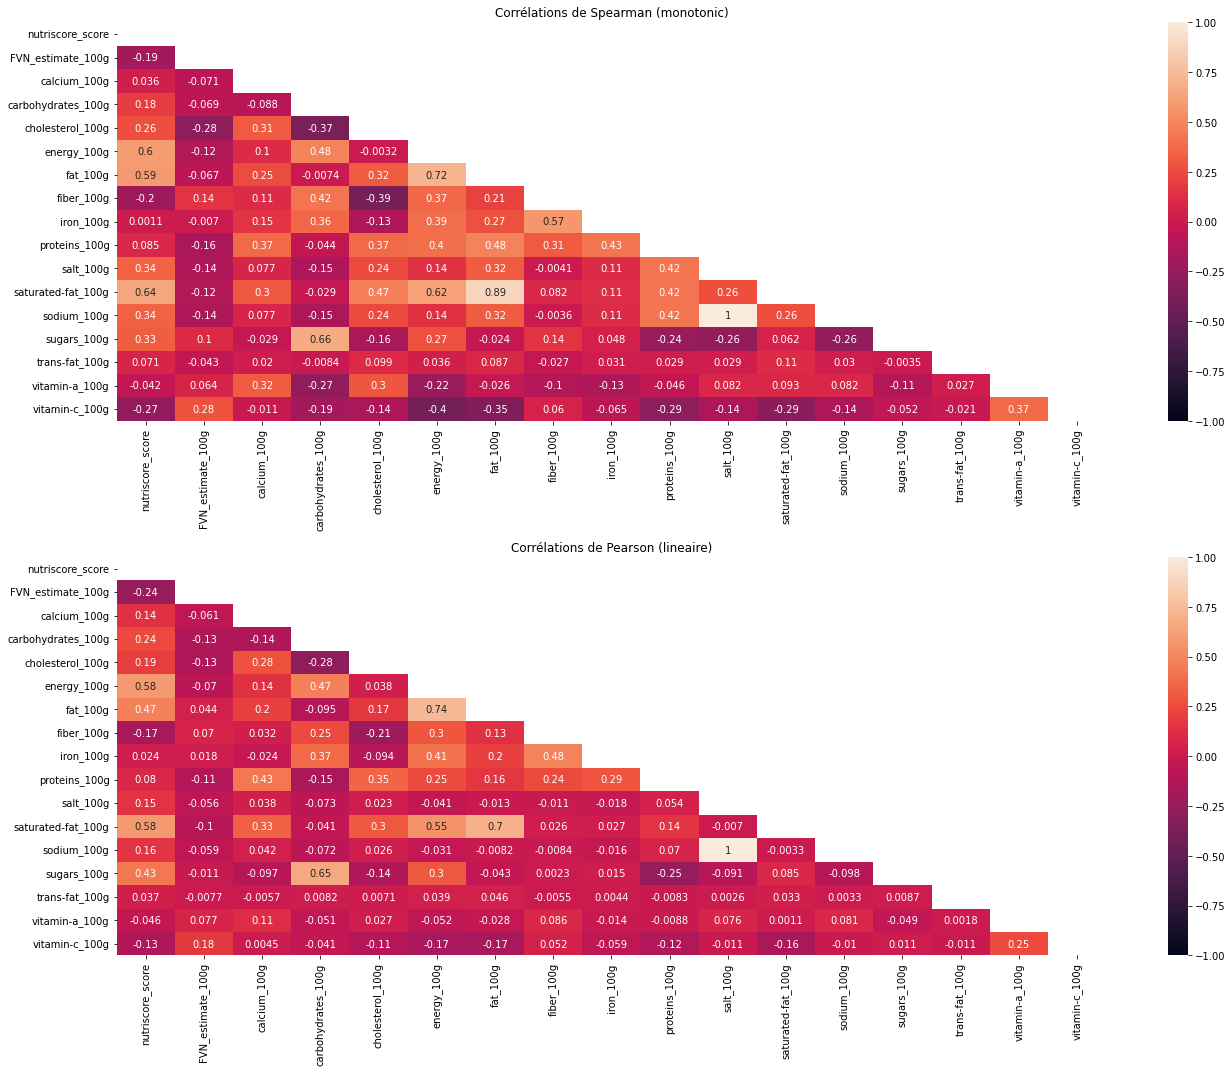

In [81]:
fig = plt.figure(figsize=(19,15))

plt.subplot(2,1,1)
corr= data_clean.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.legend()

plt.subplot(2,1,2)
corr= data_clean.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
#ax.legend()

fig.tight_layout()
plt.show()

> Si on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec la plupart des colonnes** considerées comme favorables ou défavorables dans la documentation:
> 
> #### Éléments défavorables au score:
> 
> - `energy_100g` = 0.58 / 0.60 << **Apport calorique pour cent grammes**.
> - `sugars_100g` = 0.43 / 0.33 << **Teneur en sucre**.
> - `saturated-fat_100g` = 0.58 / 0.64 << **Teneur en graisses saturées**.
> - `salt_100g` = 0.15 / 0.34 << **Teneur en sel**.
>
> #### Éléments favorables au score:
>
> - `FVN_estimate_100g` = -0.24 / -0.19 << **Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive**.
> - `fiber_100g` = -0.17 / -0.2 << **Teneur en fibres**.
> - `proteins_100g` = 0.08 / 0.085 << **Teneur en protéines**.
>
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore *(plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*; une corrélation positive (avec un mauvais score) pour `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g` et une corrélation négative (avec un mauvais score) pour `fiber_100g`, `FNV_estimate_100g`. Seule la colonne `proteins_100g` ne semble pas répondre aux attentes, mais la laison avec le score ne semble de toutes façons pas très forte.
>
> #### Par ailleurs, on note également des corrélations moyennes avec des éléments non pris en compte par la documentation:
>
> - `fat_100g` = 0.47 / 0.59
> - `cholesterol_100g` = 0.19 / 0.26
> - `carbohydrates_100g` = 0.24 / 0.18
> - `calcium_100g` = 0.14 / 0.036
> - `sodium_100g` = 0.16 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27

> Si l'on regade les autres colonnes, on voit que certaines d'entre elles n'ont qu'une seule ou même **aucune corrélation linéaire** *(Pearson)* avec les autres et très peu de corrélation monotones *(Spearman)*.
> - C'est le cas de `trans-fat_100g`, `vitamin-a_100g` ou `vitamin-c_100g` qui de fait ne devrait pas être très utiles ni pour prédire le `nutriscore-score` ni pour imputer les autres colonnes.
>
> En revanche, certaines colonnes présentent des corrélations moyennes ou fortes intéressantes:
> - La corrélation est maximale entre `salt_100g` et `sodium_100g` *(ce qui n'est en soit pas étonnant car pour effectuer une conversion entre sodium et sel, il faut multiplier la quantité de sodium par 2,54)*.
> - La corrélation est haute entre `energy_100g` et `fat_100g`.
> - La corrélation est moyenne entre `energy_100g` et `carbohydrates_100g`, `proteins_100g`, `calcium_100g`, `saturated-fat_100g` ou `fiber_100g`.
> - La corrélation est moyenne ou basse entre plusieurs types de graisses `fat_100g`, `saturated-fat_100g`, `cholesterol_100g`.

---

#### Vérifions les relations entre `nutriscore_score` et les autres variables numériques <a class="anchor" id="clean_linear"></a>
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [82]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)

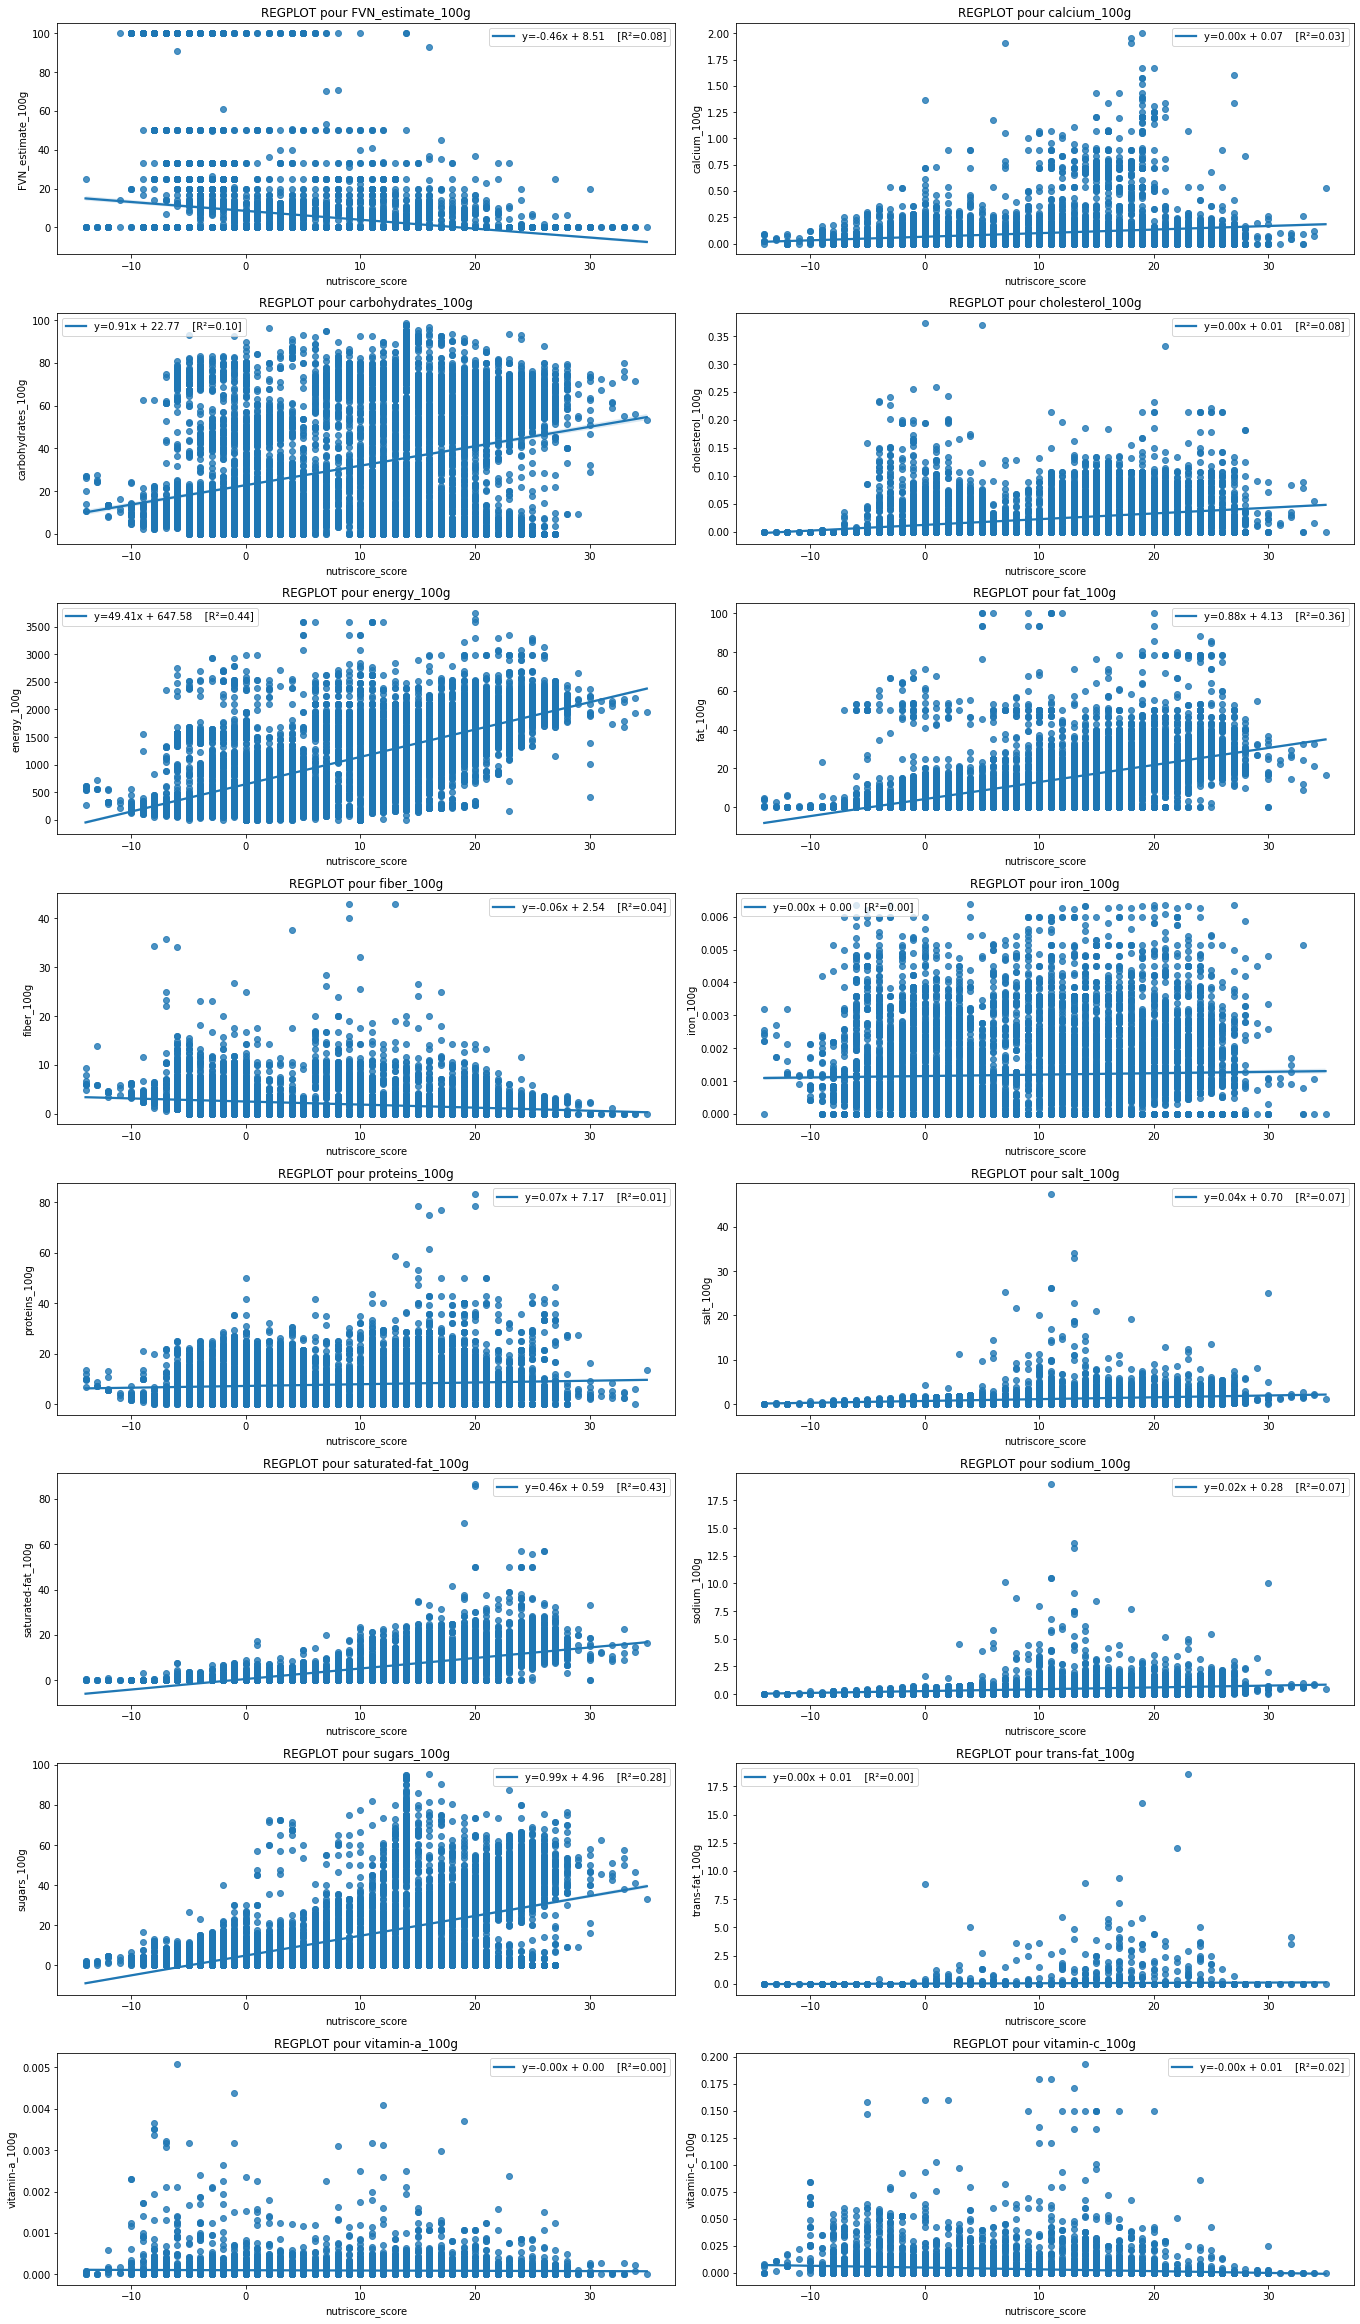

In [83]:
from scipy import stats

fig = plt.figure(figsize=(19,40))

for i, col in enumerate(var_nutri):
    plt.subplot(10,2,i+1)

    slope, intercept, r_value, pv, se = stats.linregress(data_sample['nutriscore_score'], data_sample[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_sample, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"REGPLOT pour {col}")
    plt.legend()

fig.tight_layout()
plt.show()

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. On a une corrélation moyennement forte pour `saturated-fat_100g`, `energy_100g` et `sugars_100g`, une corrélation faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, aucune corrélation pour `proteins_100g`.
>
> - `energy_100g`:        **R² = 0.44** *[Pearson = 0.58 & Spearman = 0.60]*
> - `saturated-fat_100g`: **R² = 0.43** *[Pearson = 0.58 & Spearman = 0.64]*
> - `sugars_100g`:        **R² = 0.28** *[Pearson = 0.43 & Spearman = 0.33]*
> - `FVN_estimate_100g`:  **R² = 0.08** *[Pearson = -0.24 & Spearman = -0.19]*
> - `salt_100g`:          **R² = 0.07** *[Pearson = 0.15 & Spearman = 0.34]*
> - `fiber_100g`:         **R² = 0.04** *[Pearson = -0.17 & Spearman = -0.20]*
> - `proteins_100g`:      **R² = 0.01** *[Pearson = 0.08 & Spearman = 0.085]*

> Cette tendance se vérifie avec la plupart des autres colonnes que nous avions remarquées plus haut:
> - `fat_100g`:           **R² = 0.36** *[Pearson = 0.47 & Spearman = 0.59]*
> - `carbohydrates_100g`  **R² = 0.10** *[Pearson = 0.24 & Spearman = 0.18]*
> - `cholesterol_100g`    **R² = 0.08** *[Pearson = 0.19 & Spearman = 0.26]*
> - `sodium_100g`         **R² = 0.07** *[Pearson = 0.16 & Spearman = 0.34]*
> - `calcium_100g`        **R² = 0.03** *[Pearson = 0.14 & Spearman = 0.036]*
> - `vitamin-c_100g`      **R² = 0.02** *[Pearson = -0.13 & Spearman = -0.27]*

## 4.5 Imputations des valeurs manquantes <a class="anchor" id="clean_imputations"></a>

In [84]:
data_tmp = data_clean.copy()

#### Commençons par regarder quelles sont les valeurs manquantes

In [85]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g')]

In [86]:
fill_ratio = print_fill_rate(data_tmp, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
 FVN_estimate_100g |         1084293 |           39.91%
      calcium_100g |         1546621 |           14.28%
carbohydrates_100g |          112596 |           93.76%
  cholesterol_100g |         1549540 |           14.12%
       energy_100g |          108615 |           93.98%
          fat_100g |          105394 |           94.16%
        fiber_100g |         1186122 |           34.26%
         iron_100g |         1564395 |           13.30%
     proteins_100g |          105046 |           94.18%
         salt_100g |          241427 |           86.62%
saturated-fat_100g |          150696 |           91.65%
       sodium_100g |          242258 |           86.57%
       sugars_100g |          128006 |           92.91%
    trans-fat_100g |         1553440 |           13.90%
    vitamin-a_100g |         1602072 |          

#### Regardons comment se répartissent ces valeurs manquantes

<AxesSubplot:>

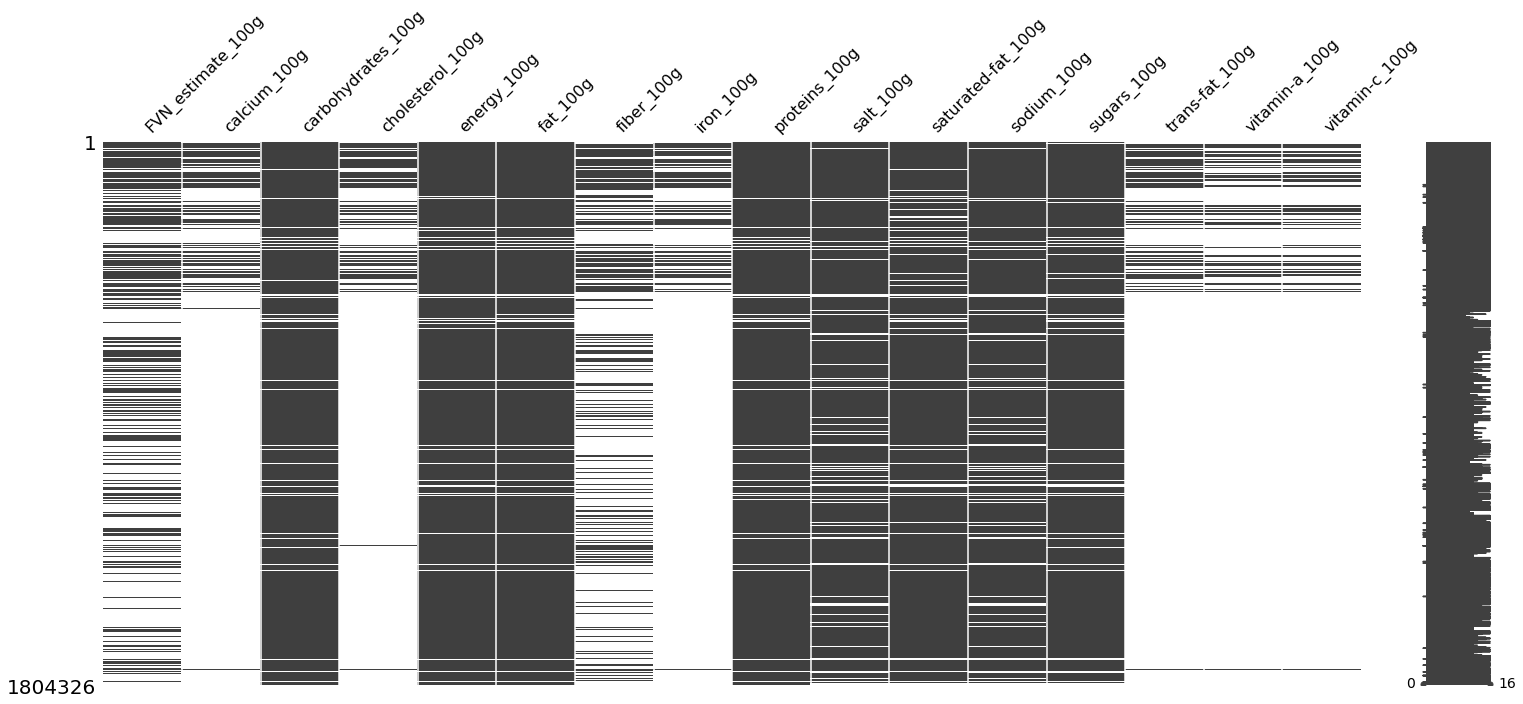

In [87]:
msno.matrix(data_tmp[var_nutri])

In [88]:
data_tmp[var_nutri].describe().T

count     mean     std   min     25%      50%  \
FVN_estimate_100g   720033.000    8.232  21.543 0.000   0.000    0.000   
calcium_100g        257705.000    0.096   0.176 0.000   0.000    0.037   
carbohydrates_100g 1691730.000   28.238  27.541 0.000   3.800   16.000   
cholesterol_100g    254786.000    0.019   0.043 0.000   0.000    0.000   
energy_100g        1695711.000 1115.611 779.528 0.000 418.000 1071.000   
fat_100g           1698932.000   13.510  17.362 0.000   0.800    7.000   
fiber_100g          618204.000    3.029   4.516 0.000   0.000    1.600   
iron_100g           239931.000    0.001   0.001 0.000   0.000    0.001   
proteins_100g      1699280.000    8.534   9.785 0.000   1.300    6.000   
salt_100g          1562899.000    1.370   4.672 0.000   0.084    0.580   
saturated-fat_100g 1653630.000    4.953   7.535 0.000   0.100    1.790   
sodium_100g        1562068.000    0.527   1.638 0.000   0.033    0.232   
sugars_100g        1676320.000   12.988  18.993 0.000   0.650    3.600   
trans-fat_100g      250886.000    0.047   0.747 0.000   0.000    0.000   
vitamin-a_100g      202254.000    0.000   0.001 0.000   0.000    0.000   
vitamin-c_100g      208390.000    0.006   0.017 0.000   0.000    0.000   

                        75%      max  
FVN_estimate_100g     0.700  100.000  
calcium_100g          0.110    2.000  
carbohydrates_100g   53.000   99.800  
cholesterol_100g      0.022    3.000  
energy_100g        1665.000 3756.000  
fat_100g             21.000  100.000  
fiber_100g            3.700   43.500  
iron_100g             0.002    0.006  
proteins_100g        12.000   87.600  
salt_100g             1.400  100.000  
saturated-fat_100g    7.000   92.600  
sodium_100g           0.560   39.091  
sugars_100g          17.860   99.800  
trans-fat_100g        0.000   90.000  
vitamin-a_100g        0.000    0.030  
vitamin-c_100g        0.004    0.200

### Etablissons une baseline pour nos imputations.
Pour ce faire, nous allons simplement imputer en utilisant les moyennes et calculer quelques scores.

In [89]:
data_imput_mean = data_tmp.copy()

#### Sélectionnons quelques lignes dont les valeurs sont connues pour servir de valeurs de référence.

In [90]:
true_values_idx = {}
for col in var_nutri:
    true_values_idx[col] = data_tmp.dropna(subset=[col]).sample(frac=0.01, random_state=0).index

#### Mettons ces lignes en None

In [91]:
for col in var_nutri:
    data_imput_mean.loc[true_values_idx[col] ,col] = None

#### Appliquons la moyenne des colonnes sur tous les None (y compris ceux que l'on vient de créer artificiellement)

In [92]:
for col in var_nutri:
    mean = data_imput_mean[col].mean()
    data_imput_mean[col].fillna(mean, inplace=True)

#### Calculons nos scores de référence (baseline with dummy model)

In [93]:
from sklearn.metrics import r2_score, mean_squared_error

In [94]:
def print_scores(dt_true, dt_pred, eval_idx):
    r2_list = []
    rmse_list = []
    for col in var_nutri:
        true_v = dt_true.loc[eval_idx[col]][col]
        pred_v = dt_pred.loc[eval_idx[col]][col]
    
        r2 = r2_score( true_v , pred_v )
        rmse = mean_squared_error( true_v, pred_v, squared=False)
        
        r2_list.append(r2)
        rmse_list.append(rmse)
        
        print(f"{col.rjust(25)}  ==>  R²:{r2:8.2f} | RMSE:{rmse:8.2f}")
    
    r2_mean = sum(r2_list)/len(r2_list)
    rmse_mean = sum(rmse_list)/len(rmse_list)
    print(f"{'-'*115}\n{'MEAN'.rjust(25)}  ==>  R²:{r2_mean:8.2f} | RMSE:{rmse_mean:8.2f}")
        
    return r2_list, rmse_list

In [95]:
_, _ = print_scores(data_tmp, data_imput_mean, true_values_idx)

        FVN_estimate_100g  ==>  R²:   -0.00 | RMSE:   22.82
             calcium_100g  ==>  R²:   -0.00 | RMSE:    0.19
       carbohydrates_100g  ==>  R²:   -0.00 | RMSE:   27.56
         cholesterol_100g  ==>  R²:   -0.00 | RMSE:    0.06
              energy_100g  ==>  R²:   -0.00 | RMSE:  781.66
                 fat_100g  ==>  R²:   -0.00 | RMSE:   17.22
               fiber_100g  ==>  R²:   -0.00 | RMSE:    4.68
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
            proteins_100g  ==>  R²:   -0.00 | RMSE:    9.92
                salt_100g  ==>  R²:   -0.00 | RMSE:    5.17
       saturated-fat_100g  ==>  R²:   -0.00 | RMSE:    7.54
              sodium_100g  ==>  R²:   -0.00 | RMSE:    1.58
              sugars_100g  ==>  R²:   -0.00 | RMSE:   19.17
           trans-fat_100g  ==>  R²:   -0.00 | RMSE:    0.48
           vitamin-a_100g  ==>  R²:   -0.00 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:   -0.00 | RMSE:    0.02
----------------------------------------

### Imputation par IterativeImputer

Dans un IterativeImputer, les colonnes sont remplies par ordre croissant; de celles qui ont le moins de valeurs manquantes à celles qui en ont le plus. Il est donc inutile d'utiliser une autre méthode au préalable pour compléter les colonnes les mieux pourvues avant d'utiliser un IterativeImputer sur le reste.

In [96]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [97]:
data_imput_iter = data_tmp.copy()

#### On met les lignes sélectionnées pour le calcul des scores en None

In [98]:
for col in var_nutri:
    data_imput_iter.loc[true_values_idx[col] ,col] = None

#### On ne garde que les colonnes qui doivent servir à prédire le `nutriscore_score`

In [99]:
X = data_imput_iter[var_nutri]
X.shape

# y = data_input_iter['nutriscore_score']

(1804326, 16)

#### On définit une liste des valeurs maximales que l'IterativeImputer peut donner à chaque colonne.

In [100]:
max_values_imput = [100.0]*len(var_nutri)
for i, col in enumerate(var_nutri):
    if(col in max_values):
        max_values_imput[i] = max_values[col]

#### On entraine l'IterativeImputer et on remplis les None

In [101]:
imputer = IterativeImputer(
    imputation_order='ascending', 
    random_state=0, 
    min_value=0, 
    max_value=max_values_imput
)
Xtrans = imputer.fit_transform(X)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P3/venvP3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



#### On replace les valeurs obtenues dans un DataFrame pandas avec les bons index et les bonnes colonnes

In [102]:
Xtrans = pd.DataFrame(Xtrans, columns=var_nutri, index=data_tmp.index)
Xtrans.shape

(1804326, 16)

#### On explore le résultat

In [103]:
fill_ratio = print_fill_rate(Xtrans, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
 FVN_estimate_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
carbohydrates_100g |               0 |          100.00%
  cholesterol_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

In [104]:
data_imput_iter.head()

code nova_group nutriscore_grade  nutriscore_score  \
1  00000000000003429145       None             None               NaN   
2         0000000000017       None             None               NaN   
4    000000000003327986       None             None               NaN   
5    000000000004622327       None             None               NaN   
6           00000000001          4             None               NaN   

  pnns_groups_2                  product_name  FVN_estimate_100g  \
1          None                       L.casei              0.000   
2          None              Vitória crackers                NaN   
4          None     Filetes de pollo empanado                NaN   
5          None  Hamburguesas de ternera 100%                NaN   
6          None                     hyde icon              0.000   

   calcium_100g  carbohydrates_100g  cholesterol_100g  ...  fiber_100g  \
1           NaN               9.800               NaN  ...         NaN   
2           NaN              70.100               NaN  ...         NaN   
4           NaN                 NaN               NaN  ...         NaN   
5           NaN               2.600               NaN  ...         NaN   
6           NaN                 NaN               NaN  ...         NaN   

   iron_100g  proteins_100g  salt_100g  saturated-fat_100g  sodium_100g  \
1        NaN          2.700      0.100               0.900        0.040   
2        NaN          7.800      1.400               3.080        0.560   
4        NaN         15.300      1.100               1.000        0.440   
5        NaN         15.700      2.100               6.100        0.840   
6        NaN            NaN        NaN                 NaN          NaN   

   sugars_100g  trans-fat_100g  vitamin-a_100g  vitamin-c_100g  
1        9.800             NaN             NaN             NaN  
2       15.000             NaN             NaN             NaN  
4          NaN             NaN             NaN             NaN  
5        1.000             NaN             NaN             NaN  
6          NaN             NaN             NaN             NaN  

[5 rows x 22 columns]

In [105]:
data_imput_iter[var_nutri] = Xtrans

In [106]:
data_imput_iter.head()

code nova_group nutriscore_grade  nutriscore_score  \
1  00000000000003429145       None             None               NaN   
2         0000000000017       None             None               NaN   
4    000000000003327986       None             None               NaN   
5    000000000004622327       None             None               NaN   
6           00000000001          4             None               NaN   

  pnns_groups_2                  product_name  FVN_estimate_100g  \
1          None                       L.casei              0.000   
2          None              Vitória crackers              0.000   
4          None     Filetes de pollo empanado              5.921   
5          None  Hamburguesas de ternera 100%              9.312   
6          None                     hyde icon              0.000   

   calcium_100g  carbohydrates_100g  cholesterol_100g  ...  fiber_100g  \
1         0.056               9.800             0.020  ...       0.178   
2         0.070              70.100             0.001  ...       5.140   
4         0.152              21.942             0.030  ...       3.104   
5         0.305               2.600             0.070  ...       5.031   
6         0.113              31.768             0.024  ...       2.498   

   iron_100g  proteins_100g  salt_100g  saturated-fat_100g  sodium_100g  \
1      0.000          2.700      0.100               0.900        0.040   
2      0.002          7.800      1.400               3.080        0.560   
4      0.001         15.300      1.100               1.000        0.440   
5      0.000         15.700      2.100               6.100        0.840   
6      0.001          8.940      1.390               4.994        0.556   

   sugars_100g  trans-fat_100g  vitamin-a_100g  vitamin-c_100g  
1        9.800           0.032           0.000           0.008  
2       15.000           0.045           0.000           0.006  
4        7.013           0.002           0.000           0.008  
5        1.000           0.450           0.001           0.029  
6       13.190           0.045           0.000           0.005  

[5 rows x 22 columns]

In [107]:
fill_ratio = print_fill_rate(data_imput_iter, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
 FVN_estimate_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
carbohydrates_100g |               0 |          100.00%
  cholesterol_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

#### On calcule les scores pour les imputations avec IterativeImputer

In [108]:
_, rmse_list_iter = print_scores(data_tmp, data_imput_iter, true_values_idx)

        FVN_estimate_100g  ==>  R²:    0.07 | RMSE:   21.98
             calcium_100g  ==>  R²:    0.25 | RMSE:    0.16
       carbohydrates_100g  ==>  R²:    0.74 | RMSE:   14.01
         cholesterol_100g  ==>  R²:    0.14 | RMSE:    0.06
              energy_100g  ==>  R²:    0.84 | RMSE:  311.33
                 fat_100g  ==>  R²:    0.78 | RMSE:    8.14
               fiber_100g  ==>  R²:    0.14 | RMSE:    4.34
                iron_100g  ==>  R²:    0.39 | RMSE:    0.00
            proteins_100g  ==>  R²:    0.28 | RMSE:    8.41
                salt_100g  ==>  R²:    0.75 | RMSE:    2.60
       saturated-fat_100g  ==>  R²:    0.42 | RMSE:    5.72
              sodium_100g  ==>  R²:    1.00 | RMSE:    0.07
              sugars_100g  ==>  R²:    0.45 | RMSE:   14.22
           trans-fat_100g  ==>  R²:    0.01 | RMSE:    0.48
           vitamin-a_100g  ==>  R²:    0.01 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:    0.04 | RMSE:    0.02
----------------------------------------

#### Rappelons les scores de référence (baseline) pour l'imputation par la moyenne

In [109]:
_, rmse_list_mean = print_scores(data_tmp, data_imput_mean, true_values_idx)

        FVN_estimate_100g  ==>  R²:   -0.00 | RMSE:   22.82
             calcium_100g  ==>  R²:   -0.00 | RMSE:    0.19
       carbohydrates_100g  ==>  R²:   -0.00 | RMSE:   27.56
         cholesterol_100g  ==>  R²:   -0.00 | RMSE:    0.06
              energy_100g  ==>  R²:   -0.00 | RMSE:  781.66
                 fat_100g  ==>  R²:   -0.00 | RMSE:   17.22
               fiber_100g  ==>  R²:   -0.00 | RMSE:    4.68
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
            proteins_100g  ==>  R²:   -0.00 | RMSE:    9.92
                salt_100g  ==>  R²:   -0.00 | RMSE:    5.17
       saturated-fat_100g  ==>  R²:   -0.00 | RMSE:    7.54
              sodium_100g  ==>  R²:   -0.00 | RMSE:    1.58
              sugars_100g  ==>  R²:   -0.00 | RMSE:   19.17
           trans-fat_100g  ==>  R²:   -0.00 | RMSE:    0.48
           vitamin-a_100g  ==>  R²:   -0.00 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:   -0.00 | RMSE:    0.02
----------------------------------------

#### Calculons la difference entre chaque méthode

In [110]:
best_is_mean = []
for i in range(len(rmse_list_iter)):
    diff = rmse_list_iter[i] - rmse_list_mean[i]
    
    if diff > 0:
        best_is_mean.append(True)
        best = 'Mean'
    else:
        best_is_mean.append(False)
        best = 'IterativeImputer'
        
    print(f"{var_nutri[i].rjust(25)} | RMSE diff={diff:8.3f} | Best method: {best}")

        FVN_estimate_100g | RMSE diff=  -0.842 | Best method: IterativeImputer
             calcium_100g | RMSE diff=  -0.025 | Best method: IterativeImputer
       carbohydrates_100g | RMSE diff= -13.545 | Best method: IterativeImputer
         cholesterol_100g | RMSE diff=  -0.004 | Best method: IterativeImputer
              energy_100g | RMSE diff=-470.327 | Best method: IterativeImputer
                 fat_100g | RMSE diff=  -9.076 | Best method: IterativeImputer
               fiber_100g | RMSE diff=  -0.339 | Best method: IterativeImputer
                iron_100g | RMSE diff=  -0.000 | Best method: IterativeImputer
            proteins_100g | RMSE diff=  -1.513 | Best method: IterativeImputer
                salt_100g | RMSE diff=  -2.570 | Best method: IterativeImputer
       saturated-fat_100g | RMSE diff=  -1.816 | Best method: IterativeImputer
              sodium_100g | RMSE diff=  -1.512 | Best method: IterativeImputer
              sugars_100g | RMSE diff=  -4.944 | Bes

> On constate que l'IterativeImputer a obtenu de meilleurs scores RMSE que l'imputation par la moyenne, pour toutes les colonnes.

#### Remettons les valeurs originales utilisées pour l'évaluation

In [111]:
data_imput = data_imput_iter.copy()
for col in var_nutri:
    data_imput.loc[true_values_idx[col], col] = data_clean.loc[true_values_idx[col]][col]

#### Vérifions la distribution avant et après imputation pour chaque colonne

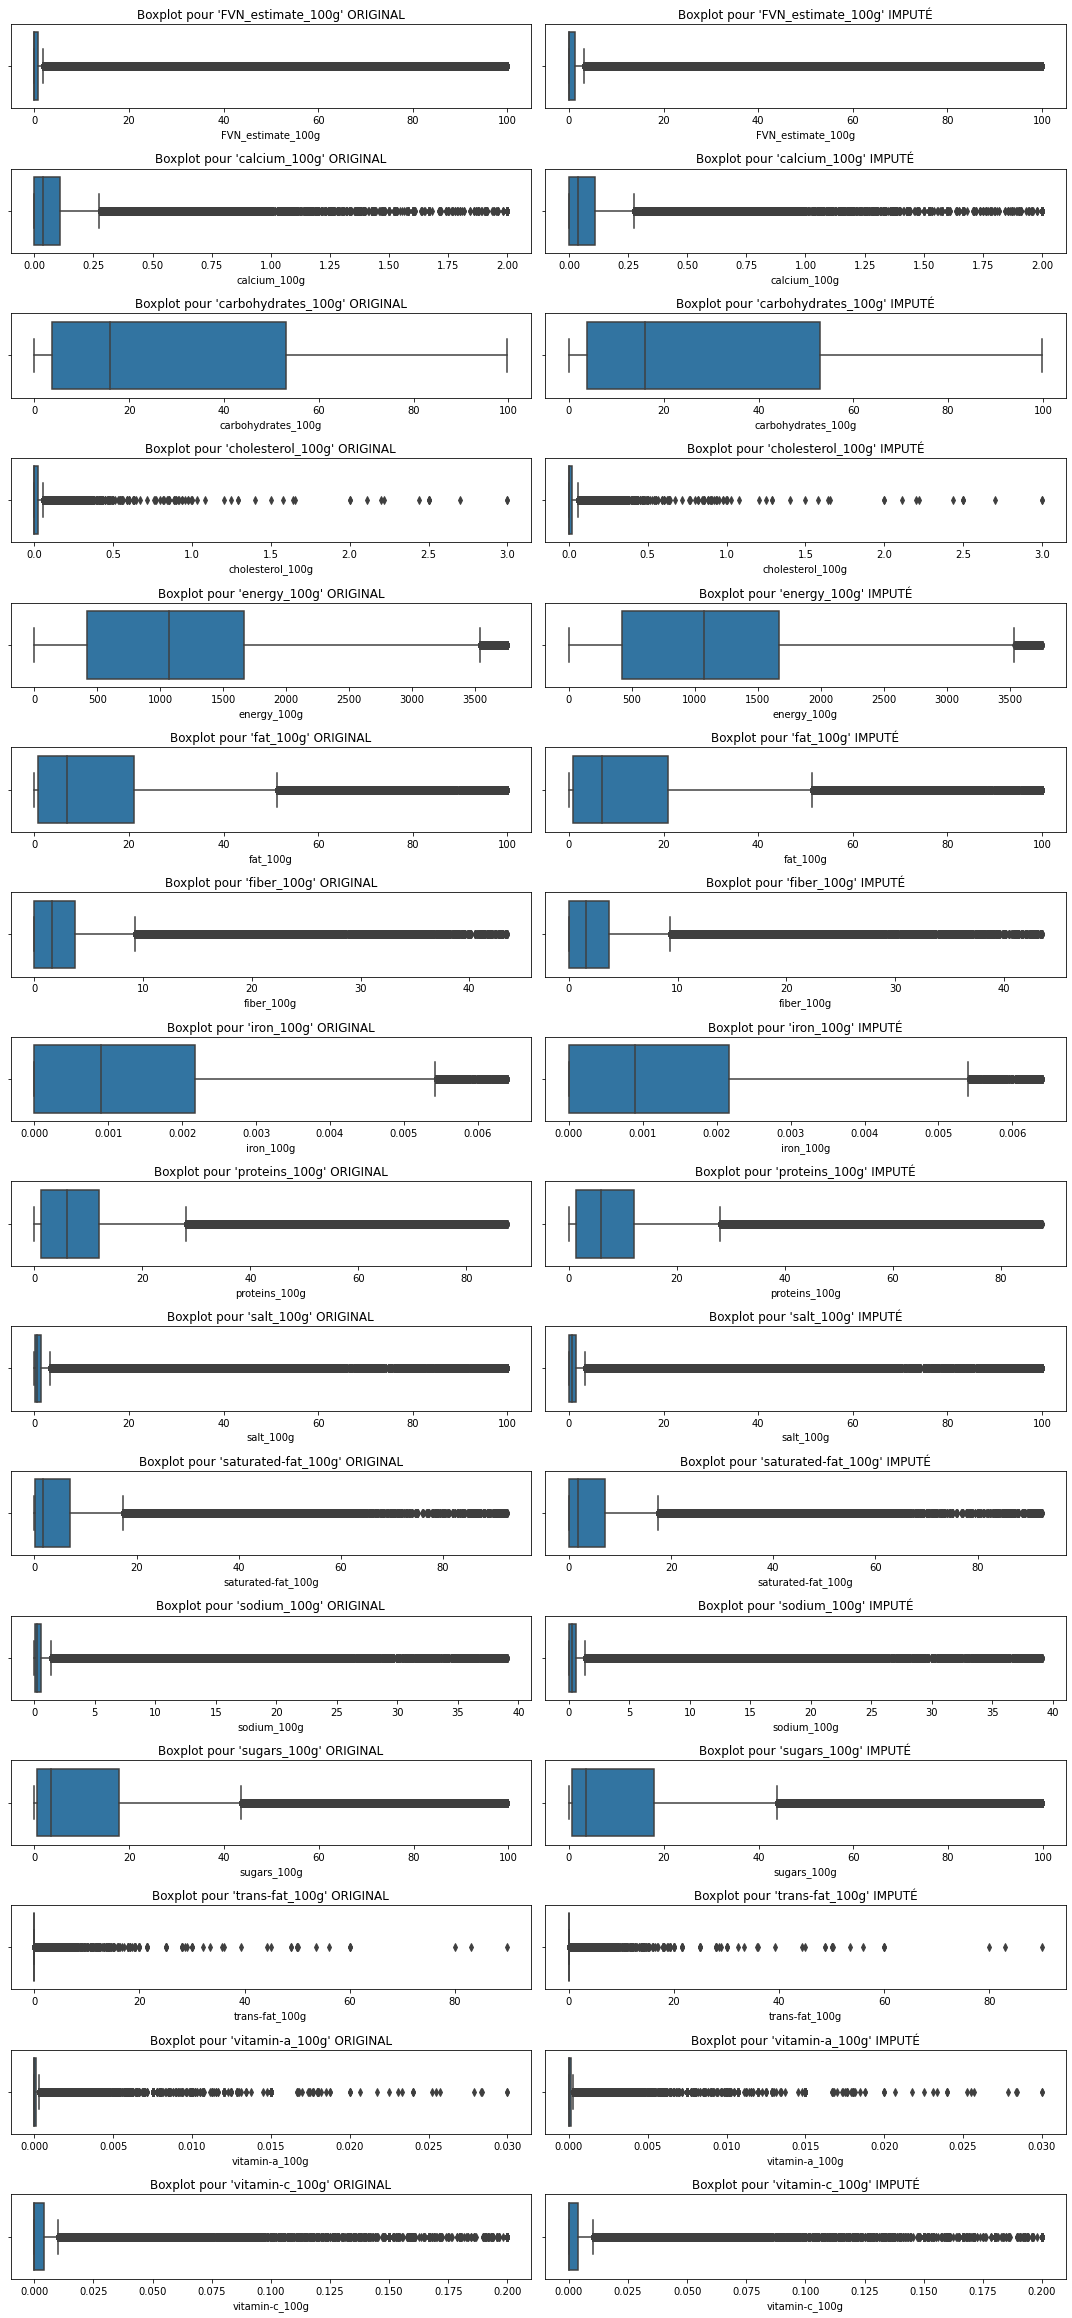

In [112]:
fig = plt.figure(figsize =(15, 60))

for i,v in enumerate(var_nutri):
    j= i*2
    ax = plt.subplot(30, 2, j+1)
    sns.boxplot(x=data_tmp[v][data_tmp[v].notnull()])
    plt.title(f"Boxplot pour '{v}' ORIGINAL")
    
    ax = plt.subplot(30, 2, j+2)
    sns.boxplot(x=data_imput_iter[v][data_tmp[v].notnull()])
    plt.title(f"Boxplot pour '{v}' IMPUTÉ")

fig.tight_layout()
plt.show()

> Il n'y a pas de différence significative.

#### Vérifions le remplissage des colonnes

In [113]:
fill_ratio = print_fill_rate(data_imput, data_imput.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
              code |               0 |          100.00%
        nova_group |         1166076 |           35.37%
  nutriscore_grade |         1066506 |           40.89%
  nutriscore_score |         1066506 |           40.89%
     pnns_groups_2 |         1090360 |           39.57%
      product_name |            8988 |           99.50%
 FVN_estimate_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
carbohydrates_100g |               0 |          100.00%
  cholesterol_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
     proteins_100g |               0 |          

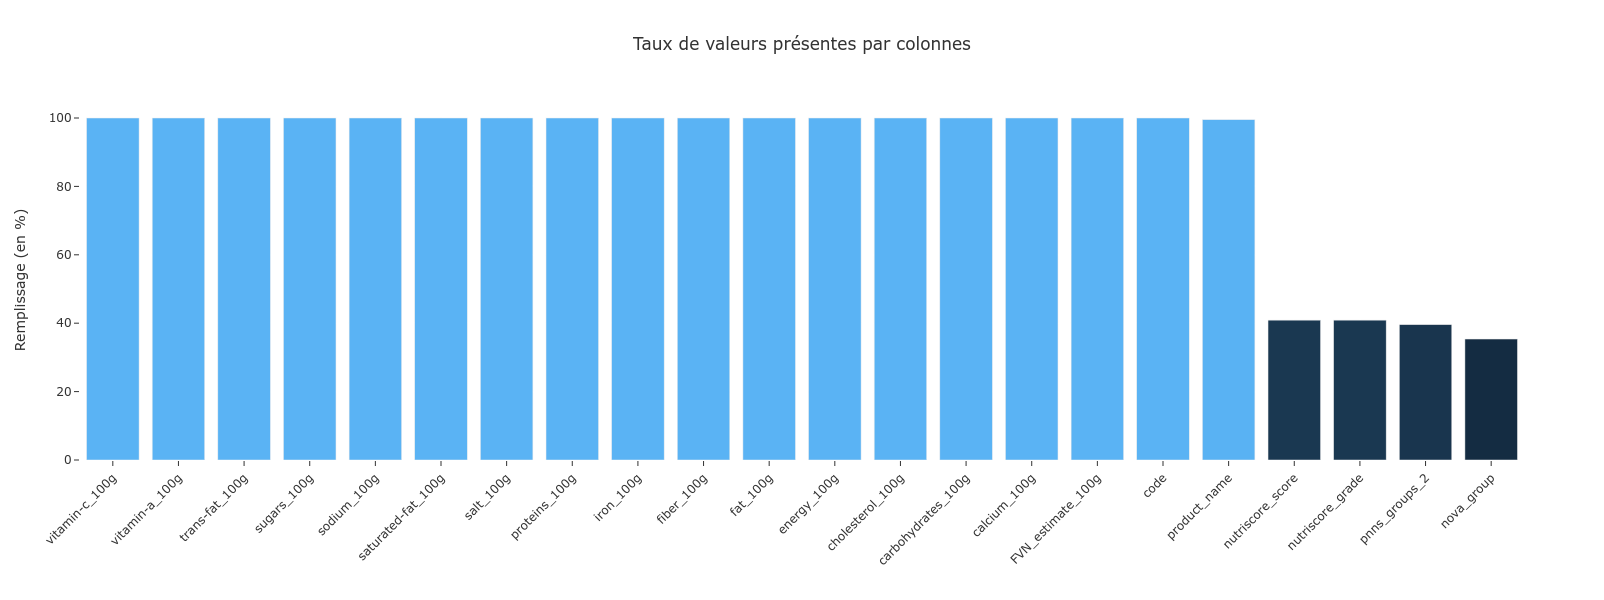

In [114]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=600,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
            )
fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45, categoryorder="total descending")
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'}) # fond transparent pour l'export
fig.show()

<AxesSubplot:>

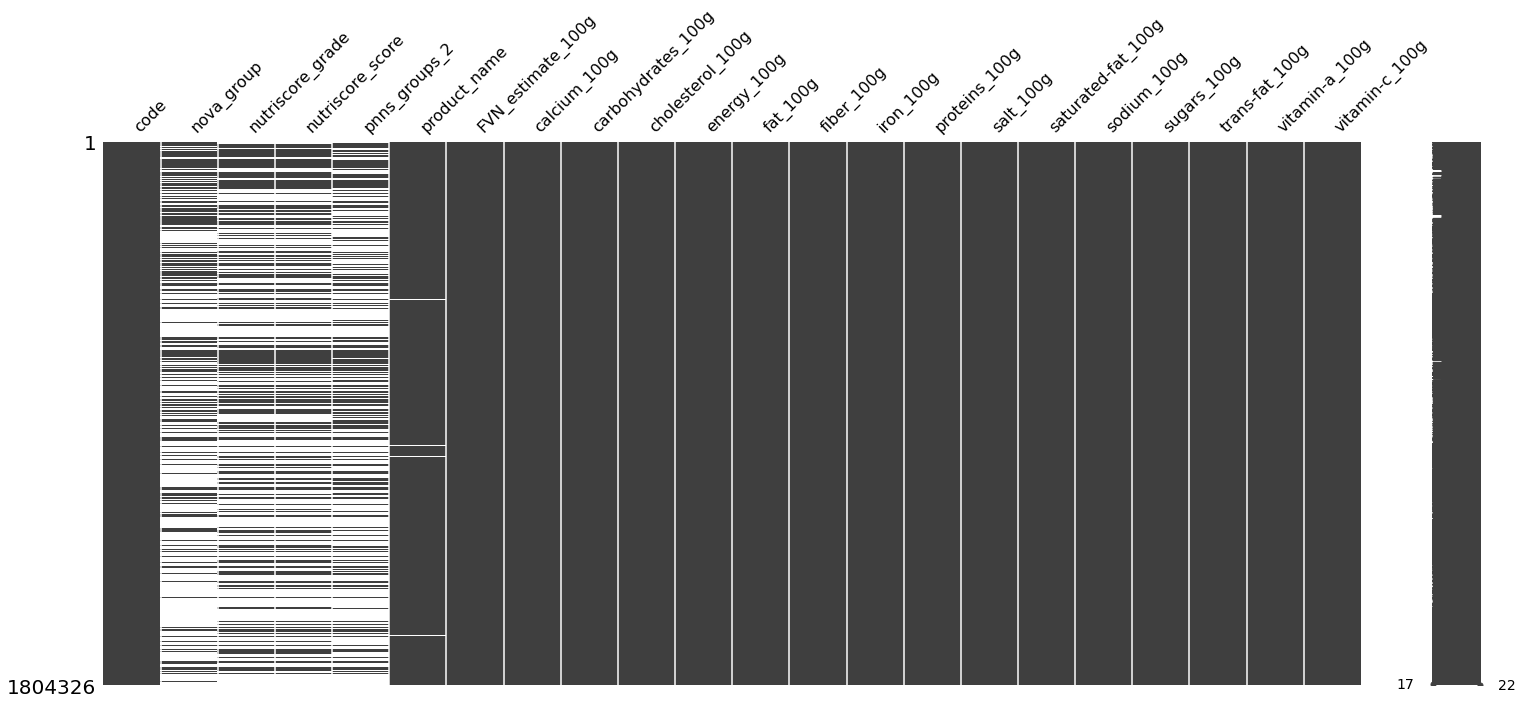

In [115]:
msno.matrix(data_imput)

#### Appliquons les imputations sur data_clean

In [116]:
data_clean = data_imput.copy()
data_clean.shape

(1804326, 22)

## 4.6 Suppression des lignes dont les valeurs nutritionnelles ne sont pas logiques <a class="anchor" id="clean_logic"></a>

Si l'on réorganise les différentes colonnes en fonctions des parents et enfants on obtient l'arbre suivant:
- carbohydrates_100g
    - sugars_100g

- fat_100g
    - trans-fat_100g
    - saturated-fat_100g
    - cholesterol_100g
    
- proteins_100g
 
- salt_100g
    - sodium_100g
    
- fiber_100g
- calcium_100g
- iron_100g
- FVN_estimate_100g
- vitamin-c_100g
- vitamin-a_100g

### Sur la base de cette *arbre*, vérifions si les colonnes des `_100g` ne dépassent pas certaines limites logiques

In [119]:
data_check = data_clean.copy()

#### Regardons si le taux de `sugars_100g` dépasse parfois celui des `carbohydrates_100g`
*(avec une marge de tolérence pour les imputations de 1g sur 100g)*

In [120]:
check_idx = data_check[(data_check.sugars_100g - data_check.carbohydrates_100g > 1) & (data_check.carbohydrates_100g > 0)].index
len(check_idx)

3284

In [121]:
remove_idx = set(check_idx)
len(remove_idx)

3284

#### Regardons si le taux de `saturated-fat_100g` + `trans-fat_100g` + `cholesterol_100g` dépasse parfois celui des `fat_100g`
*(avec une marge de tolérence pour les imputations de 1g sur 100g)*

In [122]:
check_idx = data_check[
    (
        data_check['saturated-fat_100g'] + \
        data_check['trans-fat_100g'] + \
        data_check['cholesterol_100g'] -\
        data_check['fat_100g'] > 1 
    ) & (data_check['fat_100g'] > 0)
    ].index

len(check_idx)

4184

In [123]:
remove_idx = remove_idx.union(set(check_idx))
len(remove_idx)

7322

#### Regardons si le taux de `sodium_100g` x 2.45, dépasse parfois celui du `salt_100g`
*(avec une marge de tolérence pour les imputations de 1g sur 100g)*

In [124]:
check_idx = data_check[(data_check.sodium_100g * 2.45 - data_check.salt_100g > 0) & (data_check.salt_100g > 0)].index
len(check_idx)

36

In [125]:
remove_idx = remove_idx.union(set(check_idx))
len(remove_idx)

7351

#### Regardons si la sommes des principales catégories dépasse les 100g
*(avec une marge de tolérence pour les imputations de 1g sur 100g)*

In [126]:
check_idx = data_check[
    (
        data_check['carbohydrates_100g'] + \
        data_check['fat_100g'] + \
        data_check['proteins_100g'] + \
        data_check['salt_100g'] + \
        data_check['fiber_100g'] + \
        data_check['calcium_100g'] + \
        data_check['vitamin-a_100g'] + \
        data_check['vitamin-c_100g'] + \
        data_check['iron_100g'] - 100 > 1
    )
    ].index

len(check_idx)

85571

In [127]:
remove_idx = remove_idx.union(set(check_idx))
len(remove_idx)

92494

> Environ 90k lignes sur plus de 2 millions de lignes, ce n'est pas énorme, donc supprimons les.

#### Supprimons ces lignes potentiellement problématiques

In [128]:
data_check.shape

(1804326, 22)

In [129]:
data_check.drop(check_idx, inplace=True)
data_check.shape

(1718755, 22)

#### Appliquons sur data_clean

In [130]:
data_clean = data_check.copy()
data_clean.shape

(1718755, 22)

#### Exportons le jeu de données nettoyé

In [131]:
#data_clean.to_csv('data/data_clean.csv', index=False, sep='\t')

# 5. Démarche méthodologique d'analyse de données <a class="anchor" id="P05"></a>

## 5.1 Analyses univariées des variables <a class="anchor" id="analysis_univariate"></a>

Le but d'une analyse univariée est de décrire les données pour en découvrir les caractéristiques et mieux les comprendre. Pour ce faire, on examine la moyenne, le mode, la médiane, l'écart type, la dispersion, etc. par le biais d'histogrammes, de tableaux de distribution de fréquence, de diagrammes à barres, ou autres.

In [134]:
vars_quantitatives = data_nutri.select_dtypes(include=np.number).columns
vars_qualitatives = data_nutri.select_dtypes(exclude=np.number).columns

#### Mettons en place quelques fonctions qui vont nous aider dans le travail d'exploration et de nettoyage

In [135]:
# Définissons une fonction permettant d'explorer les colonnes numériques

def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(dt.describe())
    
    fig = plt.figure(figsize =(15, 3))
    
    ax = plt.subplot(1, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")
    
    ax = plt.subplot(1, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

In [136]:
# Définissons une fonction permettant d'afficher la répartition des données (sans pie-chart)

def display_fraction(data, col_name, title, ylabel="Remplissage (en %)", showscale=True, showtext=True):
    dt = data[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [137]:
# Définissons une finction permettant d'afficher quelques informations sur le remplissage d'UNE colonne

def show_missing(data, col_name):
    
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
    
    print(f"Il manque {total_size_null} sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    fig = plt.figure(figsize=[15,5])

    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

#### Commençons avec les variables qualitatives

---
### `code`

In [138]:
data_clean['code'].describe()

count                  1718755
unique                 1718755
top       00000000000003429145
freq                         1
Name: code, dtype: object

#### Regardons le format des code-barres

In [139]:
data_clean['code'].unique()[:20]

array(['00000000000003429145', '0000000000017', '000000000003327986',
       '000000000004622327', '00000000001', '0000000000100',
       '0000000000123', '0000000000178', '000000000075', '000000000080',
       '000000000088', '0000000000949', '0000000000970', '000000000112',
       '0000000001137', '000000000114', '0000000001151', '0000000001281',
       '000000000129', '0000000001311'], dtype=object)

#### Regardons le nombre de code-barres entièrement composés de chiffres *(donc sans lettres)*

In [140]:
digit_v = data_clean['code'].str.isdigit().sum()
percent_v = 100/data_clean.shape[0]*digit_v

print(f"Il y a {digit_v} code-barres entièrement composés de chiffres ({percent_v:.2f}%)")

Il y a 1718755 code-barres entièrement composés de chiffres (100.00%)


#### Regardons la répartition des code-barres en fonction de leur longueur

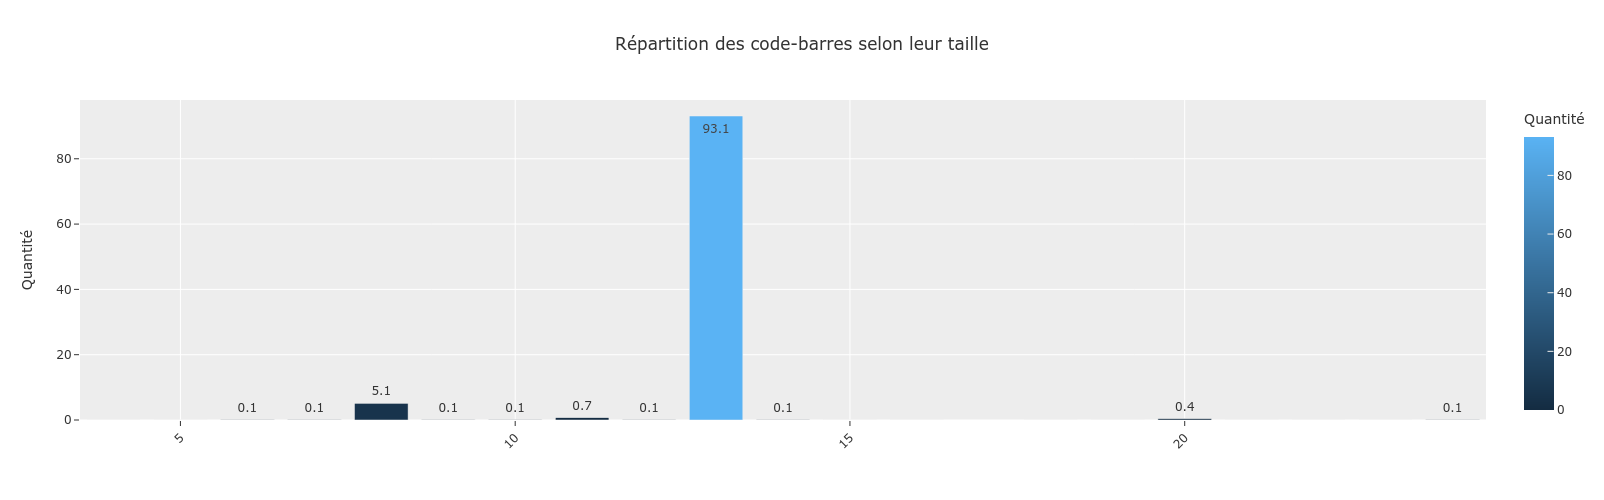

In [141]:
vcount = data_clean['code'].str.len().value_counts(dropna=True)
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'code':'Quantité'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:20]


display_fraction(select_count, 'Quantité', 
                 "Répartition des code-barres selon leur taille", 
                 showscale=True, showtext=True)

> On a donc 1 code-barre unique pour chaque ligne du jeu de données *(chaque code-barre est unique et aucun produit n'est pas de code-barre)*.
>
> Le format bien que toujours composé de chiffres, n'est pas un format unique *(on trouve des code de longueur 1 à 56)*. Cependant on constate que la grande majorité des `codes` sont au format [EAN-13](https://fr.wikipedia.org/wiki/Code-barres_EAN#Les_codes_EAN_13) *(93.1%).* puis  [EAN-8](https://fr.wikipedia.org/wiki/Code-barres_EAN#Les_codes_EAN_8) *(5.1%).*

> Nous avions gardé cette colonne pour aider à la suppression des doublons et c'est chose faite, elle ne présente donc plus d'autre intérêt que de rechercher un produit via son code-barre.
> 
> `Recommandations:` la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.

---
### `product_name`

In [142]:
data_clean['product_name'].describe()

count       1710127
unique      1170158
top       Ice cream
freq            717
Name: product_name, dtype: object

#### Regardons également la répartition de ces valeurs
Sachant que l'on a déjà supprimés les produits ayant le même nom ET les mêmes valeurs nutritionnelles, les produits restants avec un nom similaire sont donc des produits aux caractéristiques différentes.

In [143]:
data_clean['product_name'].value_counts(dropna=False)

None                                           8628
Ice cream                                       717
Spaghetti                                       698
Chocolat                                        670
Mozzarella                                      665
                                               ... 
Panzani penne rigate qualité supérieure 5kg       1
5KG Spaghetti Panzani                             1
Panzani bucatini specialita                       1
Pz farfallone 500 /12                             1
Fati                                              1
Name: product_name, Length: 1170159, dtype: int64

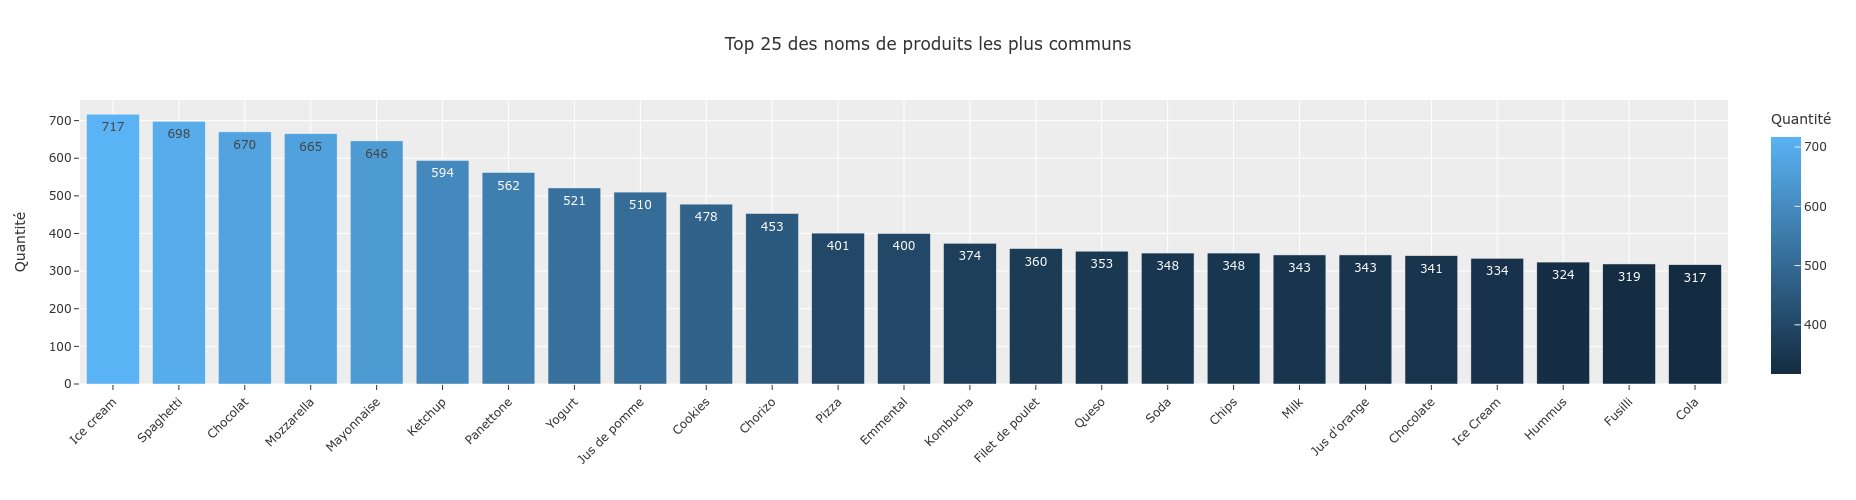

In [144]:
vcount = data_clean['product_name'].value_counts(dropna=True)
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
#select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'product_name':'Quantité'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Quantité', 
                 "Top 25 des noms de produits les plus communs", 
                 showscale=True, showtext=True)

#### Combien de produits ont un nom unique ?

In [145]:
unique_v = data_clean['product_name'].isin(vcount.index[vcount<=1.0]).sum()
percent_v = 100/data_clean.shape[0]*unique_v

print(f"Il y a {unique_v} noms de produits ne correspondant qu'à un seul produit ({percent_v:.2f}%)")

Il y a 1032055 noms de produits ne correspondant qu'à un seul produit (60.05%)


#### Et combien en manque-t-il ?

Il manque 8628 sur 1718755 dans la colonne 'product_name' (0.50%)


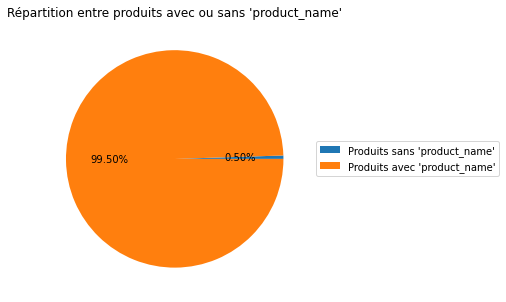

In [146]:
show_missing(data_clean, 'product_name')

> Si la majorité des produits sont uniques *(60.05%)*, de nombreux produits sont malgré tout associés au même nom. Ce n'est pas vraiment étonnant, car on peut avoir des noms très générique *(par exemple le mode est ici "Ice cream" avec 717 instances)* avec des valeurs nutritionnelles différentes.
>
> On note d'ailleurs que malgré le nettoyage fait au préalable, il reste environ 8600 produits sans nom...

> `Recommandations:` la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.

---
### `pnns_groups_2`

In [147]:
data_clean['pnns_groups_2'].describe()

count     688362
unique        40
top       Sweets
freq       61783
Name: pnns_groups_2, dtype: object

In [148]:
data_clean['pnns_groups_2'].value_counts(dropna=False)

None                                1030393
Sweets                                61783
Biscuits and cakes                    60124
Dressings and sauces                  49988
One-dish meals                        42937
Cheese                                41848
Cereals                               38868
Processed meat                        36793
Milk and yogurt                       32590
Vegetables                            28750
Fish and seafood                      27518
Meat                                  25048
Sweetened beverages                   22730
Bread                                 22597
Chocolate products                    14762
Fruits                                14650
Salty and fatty products              13912
Fats                                  13505
Unsweetened beverages                 11798
Appetizers                            10813
Breakfast cereals                      9929
Fruit juices                           9626
Alcoholic beverages             

> On constate qu'il y a 40 super-catégories, qui ont chacune de 1 à 61783 produits.
>
> On note également la présence de 1030393 produits non catégorisés.

#### Affichons la répartition des catégories les plus fréquentes

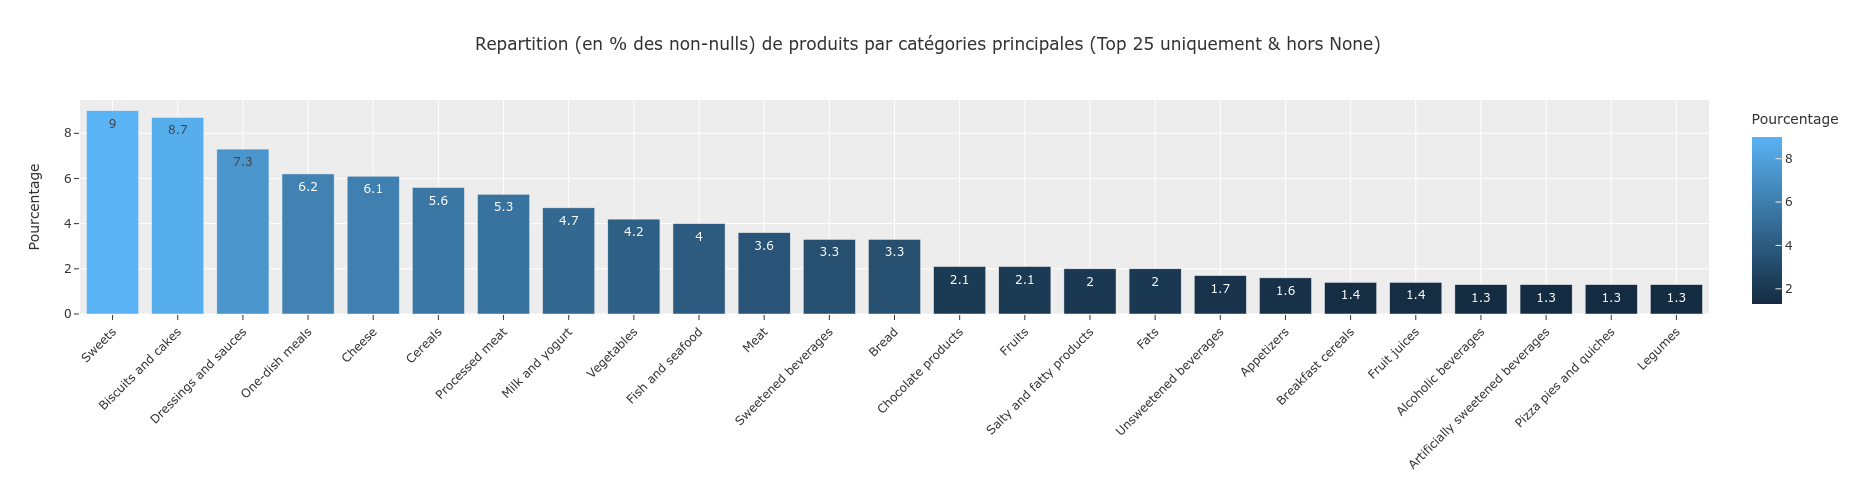

In [149]:
select_count = pd.DataFrame(data_clean['pnns_groups_2'].value_counts(dropna=True))

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'pnns_groups_2':'Pourcentage'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Pourcentage', "Repartition (en % des non-nulls) de produits par catégories principales (Top 25 uniquement & hors None)", showscale=True, showtext=True)

> Les sucreries *(`Sweets`)*, biscuits et gateaux *(`Biscuits and cakes`)* prennent une place importante.
> 
> Les produits bruts comme la viande *(`Meat`)*, le poisson *(`Fish and seafood`)*, les légumes *(`Vegetables`)* ou les fruits *(`Fruits`)* sont moins bien représentés.

#### Enfin, vérifions combien de produits n'ont pas de valeur `pnns_groups_2`

Il manque 1030393 sur 1718755 dans la colonne 'pnns_groups_2' (59.95%)


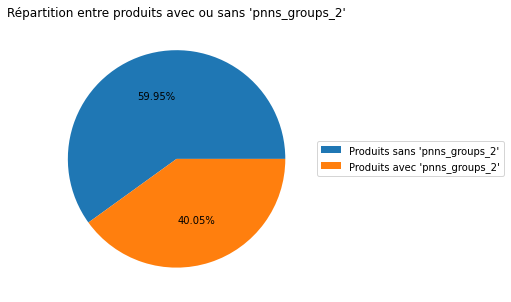

In [150]:
show_missing(data_clean, 'pnns_groups_2')

> `Recommandation:` on peut essayer d'imputer cette colonne avec un KNN.

---
### `nova_group`

In [151]:
data_clean['nova_group'].describe()

count     603245
unique         4
top            4
freq      403130
Name: nova_group, dtype: object

In [152]:
data_clean['nova_group'].value_counts(dropna=False).sort_index()

1         63888
2         17237
3        118990
4        403130
None    1115510
Name: nova_group, dtype: int64

#### Affichons la répartition des nova_groups

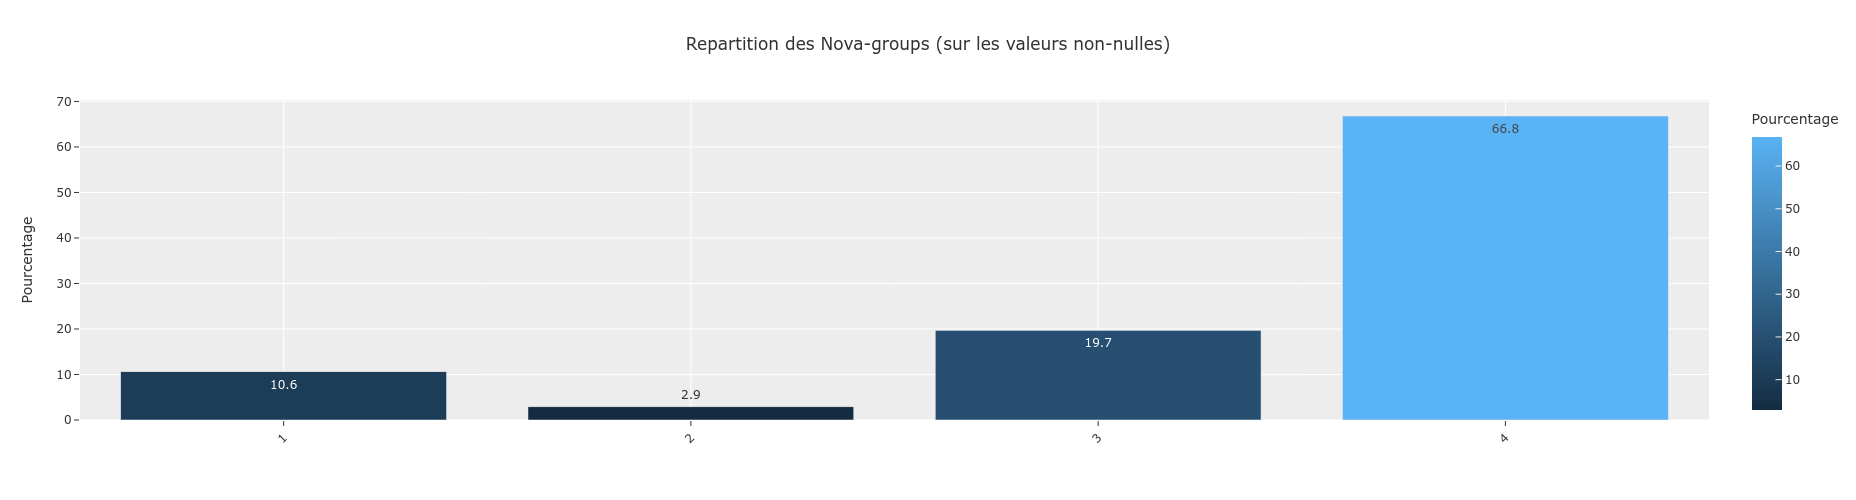

In [153]:
vcount = data_clean['nova_group'].value_counts(dropna=True).sort_index()
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'nova_group':'Pourcentage'}, inplace=True)

display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nova-groups (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)

#### Enfin, vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1115510 sur 1718755 dans la colonne 'nova_group' (64.90%)


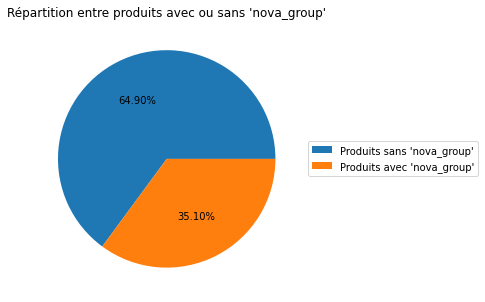

In [154]:
show_missing(data_clean, 'nova_group')

> D'après la [documentation sur les nova-groups](https://fr.openfoodfacts.org/nova), les groupes possibles sont les suivants :
> - Groupe 1 - Aliments non transformés ou transformés minimalement
> - Groupe 2 - Ingrédients culinaires transformés
> - Groupe 3 - Aliments transformés
> - Groupe 4 - Produits alimentaires et boissons ultra-transformés

> On constate donc une large majorité de produits du **Groupe 4** *(66.8%)* contre une représentation bien plus petite des trois autres groupes.

> `Recommandation:` explorer la relation entre `nova_group` et les colonnes nutritionnelles ou les colonnes de `nutriscore` lors des analyses multivariées.

---
### `nutriscore_grade`

In [155]:
data_clean['nutriscore_grade'] = data_clean['nutriscore_grade'].str.upper()

In [156]:
data_clean['nutriscore_grade'].describe()

count     701087
unique         5
top            D
freq      213943
Name: nutriscore_grade, dtype: object

In [157]:
data_clean['nutriscore_grade'].value_counts(dropna=False).sort_index()

A        111604
B         96771
C        149877
D        213943
E        128892
None    1017668
Name: nutriscore_grade, dtype: int64

#### Affichons la répartition des nutriscore_grades

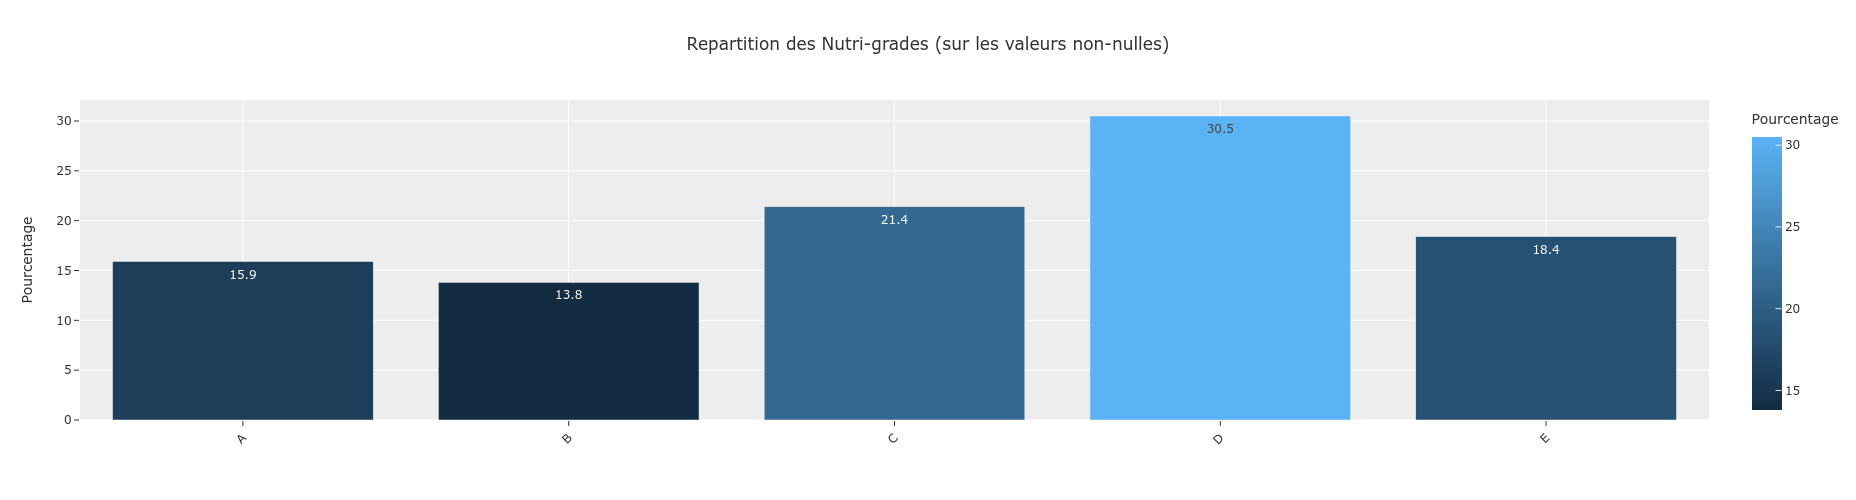

In [158]:
vcount = data_clean['nutriscore_grade'].value_counts(dropna=True).sort_index()
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'nutriscore_grade':'Pourcentage'}, inplace=True)

display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nutri-grades (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)

#### Enfin, vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1017668 sur 1718755 dans la colonne 'nutriscore_grade' (59.21%)


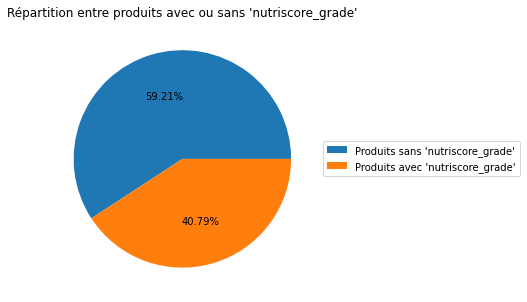

In [159]:
show_missing(data_clean, 'nutriscore_grade')

> Si la majorité des grades ne sont pas renseignés *(63.66%)*, on constate quand ils le sont beaucoup de **D** *(30.5%)*, peu de **B** *(13.8%)* et modèrement du reste (**A**: 15.9%, **C**: 21.4%, **E**: 18.4%).
>
> Il est très probable que l'on retrouve une répartition similaire dans la colonne `nutriscore_score` *(c'est juste après)*.

> `Recommandation:` explorer la relation entre `nutriscore_score` et `nutriscore_grade` lors des analyses multivariées.

#### A présent regardons les variables quantitatives

---
### `nutriscore_score`

count   701087.000
mean         8.991
std          8.844
min        -15.000
25%          1.000
50%         10.000
75%         16.000
max         40.000
Name: nutriscore_score, dtype: float64


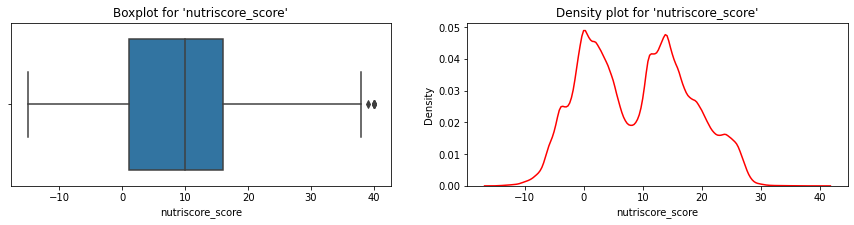

In [160]:
explore_quantitative(data_clean, 'nutriscore_score')

#### Et vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1017668 sur 1718755 dans la colonne 'nutriscore_score' (59.21%)


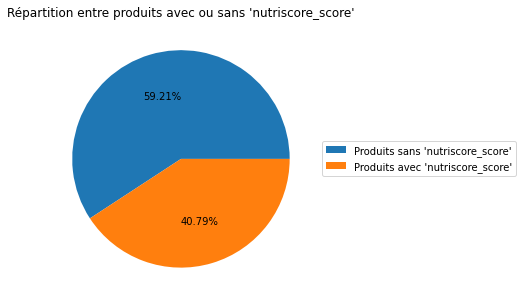

In [161]:
show_missing(data_clean, 'nutriscore_score')

> Les valeurs s'étalent de -15 à 40 avec deux pics de densité autour de 0 et 15.
>
> D'après la documentation nutriscore, on doit avoir des scores allant de -15 à 40. Et c'est exactement ce que nous avons.
>
> Par ailleurs deux sommets sur le graphique de densité qui semblent correspondre aux nutrigrade B et D. *(voir [P34](https://www.santepubliquefrance.fr/content/download/150262/file/2021_07_21_QR_scientifique_et_technique_V42_VFR.pdf))*.<br> On peut donc supposer qu'il y a:
> - une quantité **moderée** de produits classés **A** [-15;-1]
> - une **petite** quantité de produits classés **B** [0;2] (car l'intervalle est très petit)
> - une quantité **moderée** de produits classés **C** [3;10]
> - une **grande** quantité de produits classés **D** [11;18]
> - une quantité **moderée** de produits classés **E** [18;40]
>
> La réparition constaté dans l'analyse univariée de `nutriscore_grade` se retrouve également dans la colonne `nutriscore_score`, et on observe également que le nombre de valeurs manquantes est exactement le même.
>
> Enfin, on note que la distribution n'est **pas `normale`**.


> `Recommandation:` explorer la relation entre `nutriscore_score` et `nutriscore_grade` lors des analyses multivariées.

---
### `saturated-fat_100g`

count   1718755.000
mean          4.669
std           7.012
min           0.000
25%           0.100
50%           1.900
75%           6.000
max          92.600
Name: saturated-fat_100g, dtype: float64


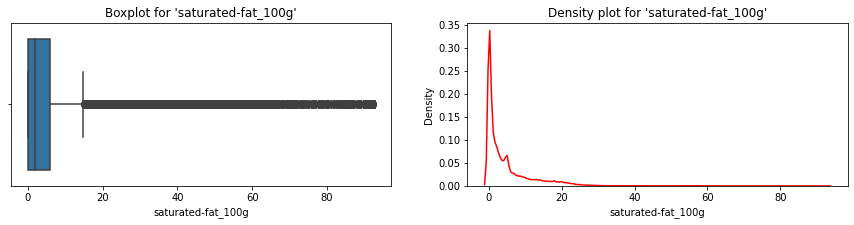

In [162]:
explore_quantitative(data_clean, 'saturated-fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'saturated-fat_100g' (0.00%)


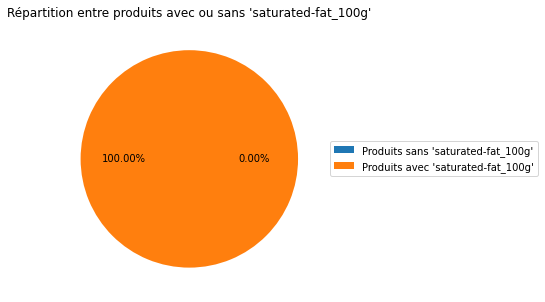

In [163]:
show_missing(data_clean, 'saturated-fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `trans-fat_100g`

count   1718755.000
mean          0.047
std           0.268
min           0.000
25%           0.010
50%           0.030
75%           0.055
max          90.000
Name: trans-fat_100g, dtype: float64


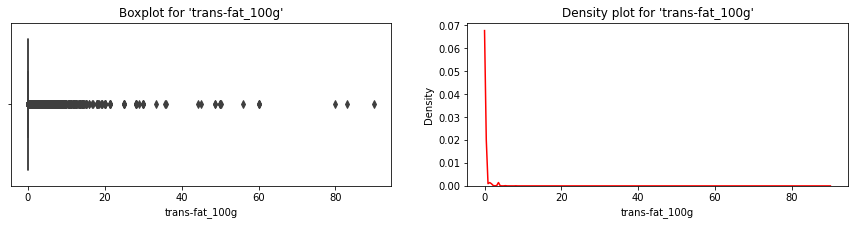

In [164]:
explore_quantitative(data_clean, 'trans-fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'trans-fat_100g' (0.00%)


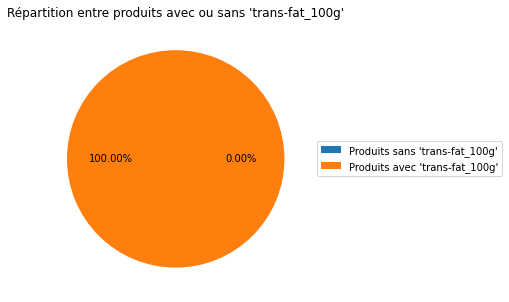

In [165]:
show_missing(data_clean, 'trans-fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `cholesterol_100g`

count   1718755.000
mean          0.023
std           0.027
min           0.000
25%           0.005
50%           0.015
75%           0.031
max           3.000
Name: cholesterol_100g, dtype: float64


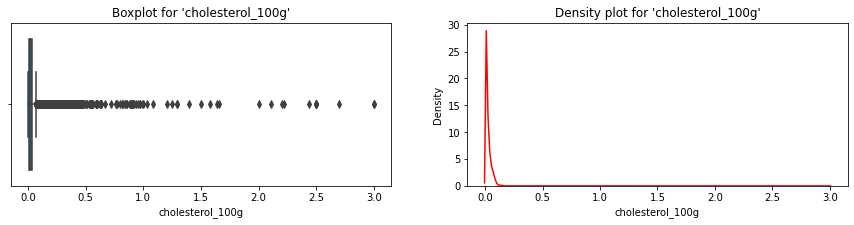

In [166]:
explore_quantitative(data_clean, 'cholesterol_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'cholesterol_100g' (0.00%)


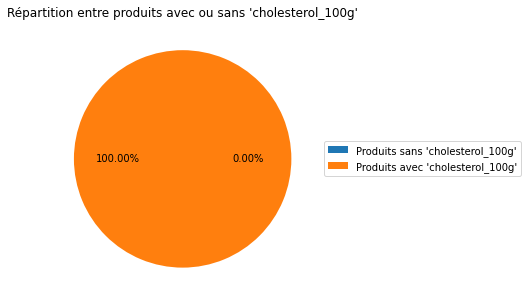

In [167]:
show_missing(data_clean, 'cholesterol_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `fat_100g`

count   1718755.000
mean         12.449
std          15.569
min           0.000
25%           0.800
50%           7.140
75%          19.000
max         100.000
Name: fat_100g, dtype: float64


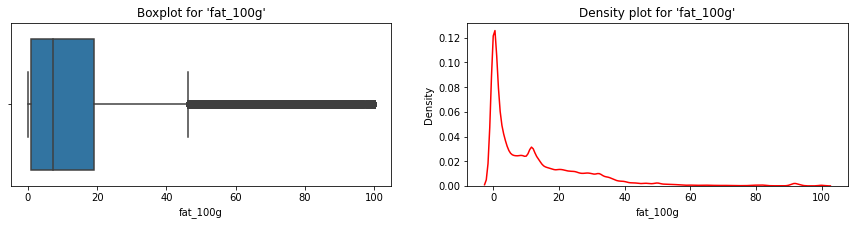

In [168]:
explore_quantitative(data_clean, 'fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'fat_100g' (0.00%)


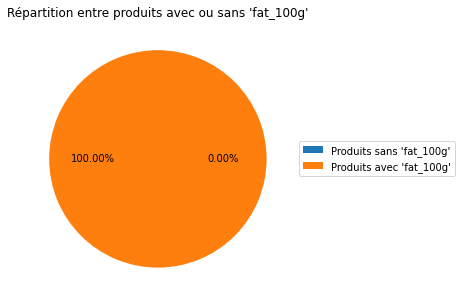

In [169]:
show_missing(data_clean, 'fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> On peut également remarquer que la distribution des valeurs a une forme assez similaire à celle de `sugars_100g` et `carbohydrates_100g`.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `sugars_100g`

count   1718755.000
mean         12.704
std          18.193
min           0.000
25%           0.700
50%           4.000
75%          15.000
max          99.800
Name: sugars_100g, dtype: float64


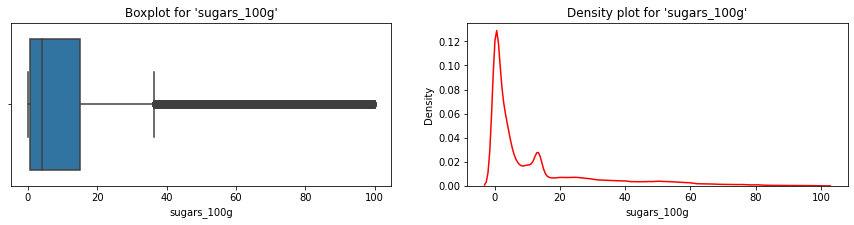

In [170]:
explore_quantitative(data_clean, 'sugars_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'sugars_100g' (0.00%)


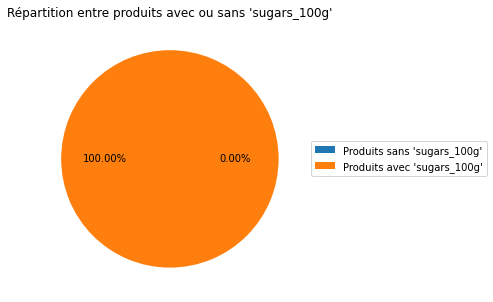

In [171]:
show_missing(data_clean, 'sugars_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> On peut également remarquer que la distribution des valeurs a une forme assez similaire à celle de `carbohydrates_100g` et `fat_100g`.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `carbohydrates_100g`

count   1718755.000
mean         27.185
std          26.391
min           0.000
25%           4.000
50%          16.920
75%          49.900
max          99.800
Name: carbohydrates_100g, dtype: float64


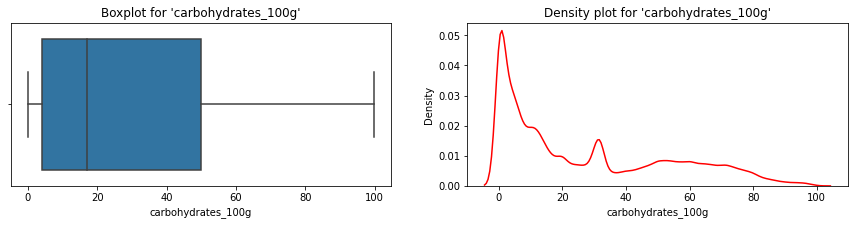

In [172]:
explore_quantitative(data_clean, 'carbohydrates_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'carbohydrates_100g' (0.00%)


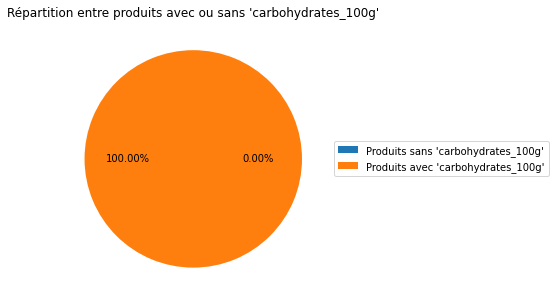

In [173]:
show_missing(data_clean, 'carbohydrates_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> On peut également remarquer que la distribution des valeurs a une forme assez similaire à celle de `sugars_100g` et `fat_100g`.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `salt_100g`

count   1718755.000
mean          1.310
std           3.884
min           0.000
25%           0.100
50%           0.800
75%           1.409
max         100.000
Name: salt_100g, dtype: float64


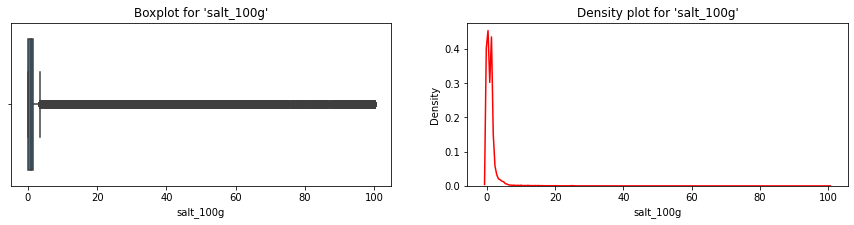

In [174]:
explore_quantitative(data_clean, 'salt_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'salt_100g' (0.00%)


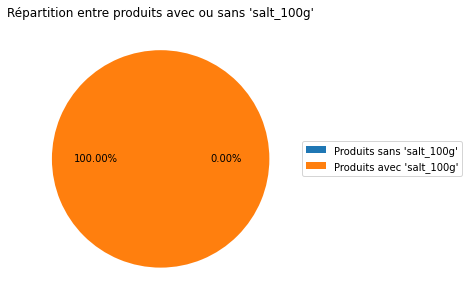

In [175]:
show_missing(data_clean, 'salt_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> On peut également remarquer que la distribution des valeurs a une forme assez similaire à celle de `sodium_100g`.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `sodium_100g`

count   1718755.000
mean          0.524
std           1.550
min           0.000
25%           0.040
50%           0.320
75%           0.564
max          39.100
Name: sodium_100g, dtype: float64


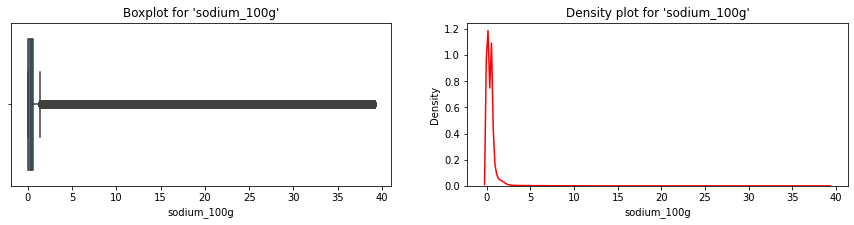

In [176]:
explore_quantitative(data_clean, 'sodium_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'sodium_100g' (0.00%)


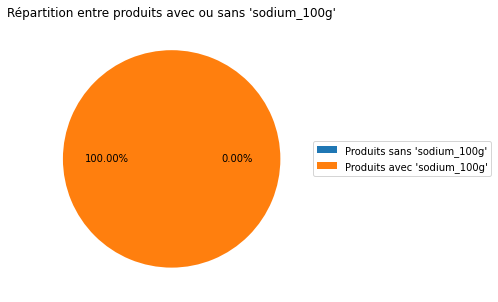

In [177]:
show_missing(data_clean, 'sodium_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> On peut également remarquer que la distribution des valeurs a une forme assez similaire à celle de `salt_100g`.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `calcium_100g`

count   1718755.000
mean          0.108
std           0.116
min           0.000
25%           0.032
50%           0.074
75%           0.145
max           2.000
Name: calcium_100g, dtype: float64


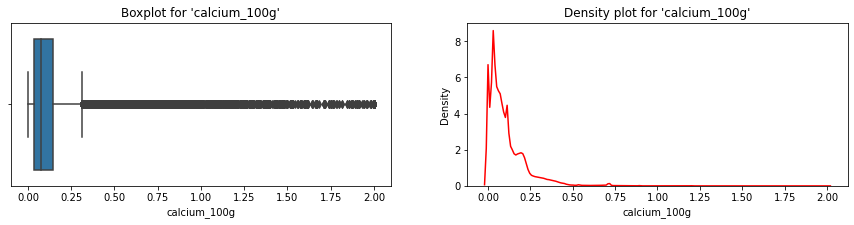

In [178]:
explore_quantitative(data_clean, 'calcium_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'calcium_100g' (0.00%)


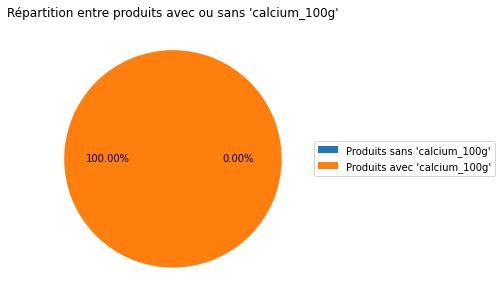

In [179]:
show_missing(data_clean, 'calcium_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `proteins_100g`

count   1718755.000
mean          8.282
std           9.102
min           0.000
25%           1.500
50%           6.100
75%          11.300
max          87.600
Name: proteins_100g, dtype: float64


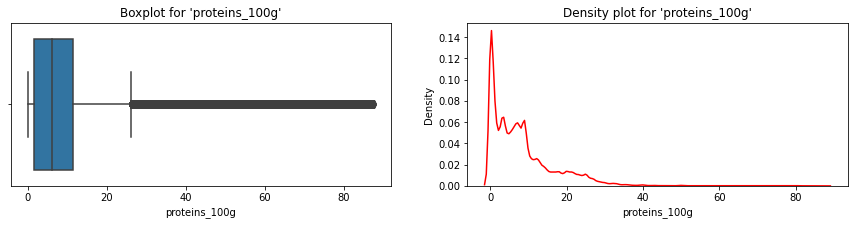

In [180]:
explore_quantitative(data_clean, 'proteins_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'proteins_100g' (0.00%)


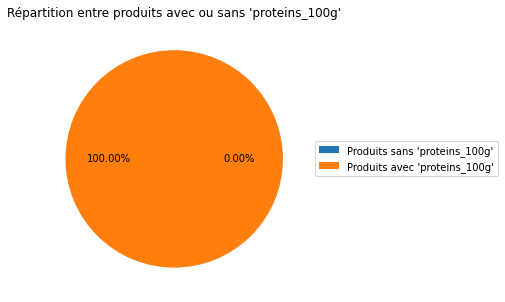

In [181]:
show_missing(data_clean, 'proteins_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `fiber_100g`

count   1718755.000
mean          2.609
std           2.568
min           0.000
25%           0.902
50%           2.353
75%           3.500
max          43.500
Name: fiber_100g, dtype: float64


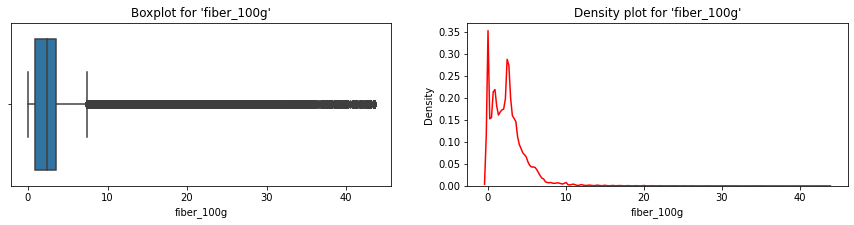

In [182]:
explore_quantitative(data_clean, 'fiber_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'fiber_100g' (0.00%)


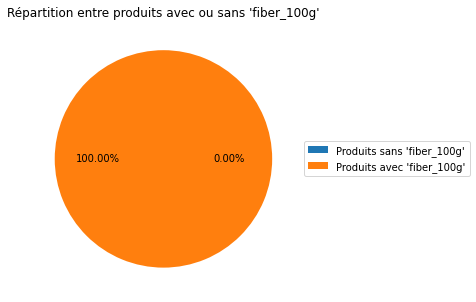

In [183]:
show_missing(data_clean, 'fiber_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `FVN_estimate_100g`

count   1718755.000
mean          8.658
std          14.470
min           0.000
25%           0.000
50%           5.566
75%          12.349
max         100.000
Name: FVN_estimate_100g, dtype: float64


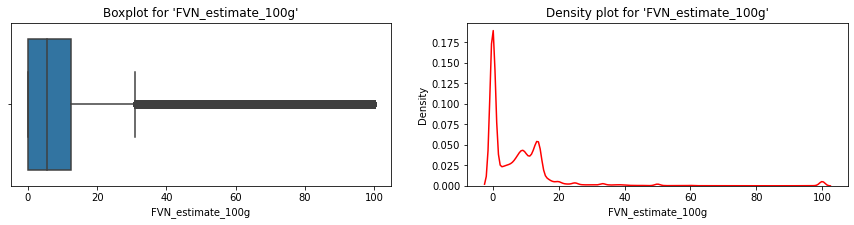

In [184]:
explore_quantitative(data_clean, 'FVN_estimate_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

In [185]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Il manque 0 sur 1718755 dans la colonne 'FVN_estimate_100g' (0.00%)


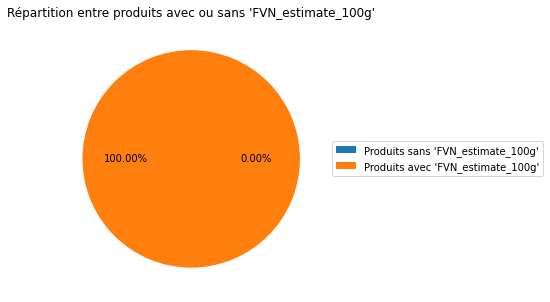

In [186]:
show_missing(data_clean, 'FVN_estimate_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `iron_100g`

In [187]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   1718755.00000
mean          0.00120
std           0.00087
min           0.00000
25%           0.00050
50%           0.00112
75%           0.00162
max           0.00640
Name: iron_100g, dtype: float64


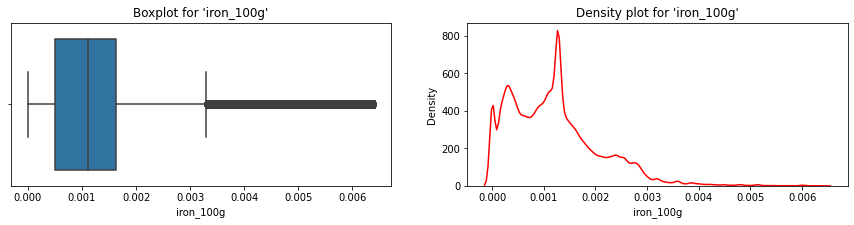

In [188]:
explore_quantitative(data_clean, 'iron_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'iron_100g' (0.00%)


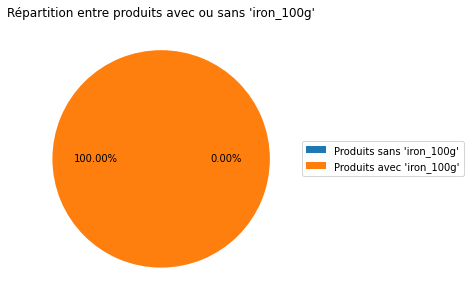

In [189]:
show_missing(data_clean, 'iron_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `vitamin-a_100g`

In [190]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   1718755.00000
mean          0.00022
std           0.00028
min           0.00000
25%           0.00010
50%           0.00020
75%           0.00026
max           0.03000
Name: vitamin-a_100g, dtype: float64


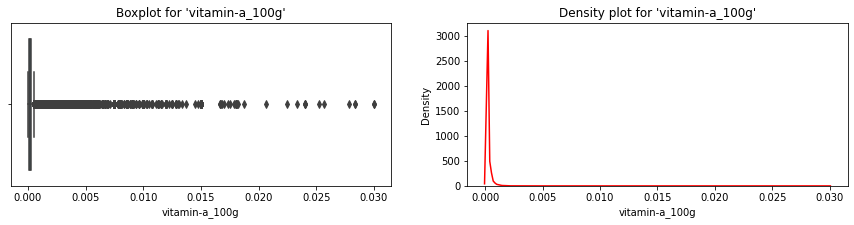

In [191]:
explore_quantitative(data_clean, 'vitamin-a_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'vitamin-a_100g' (0.00%)


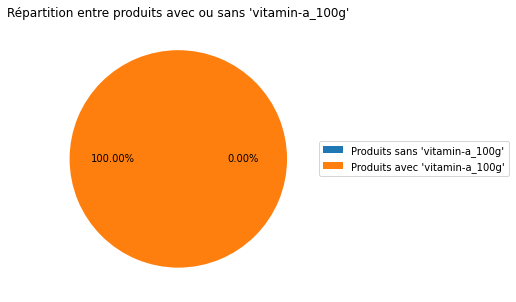

In [192]:
show_missing(data_clean, 'vitamin-a_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `vitamin-c_100g`

> On note que cette variable présente de nombreuses valeurs atypiques. <br>Le max est à 100g et c'est de toutes évidences une valeur aberrantes, mais je n'ai pas réussi à trouver le plus haut taux de vitamine-a dans un aliment de façon certaine.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

In [193]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   1718755.00000
mean          0.00743
std           0.00719
min           0.00000
25%           0.00405
50%           0.00665
75%           0.00985
max           0.20000
Name: vitamin-c_100g, dtype: float64


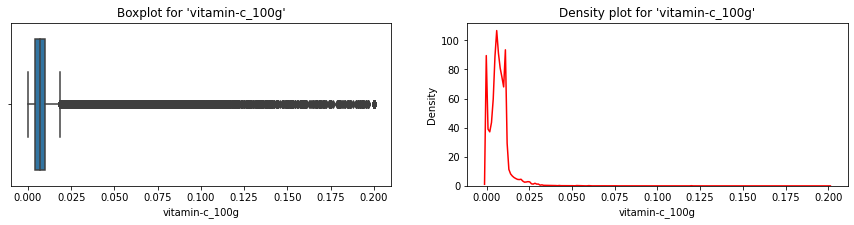

In [194]:
explore_quantitative(data_clean, 'vitamin-c_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'vitamin-c_100g' (0.00%)


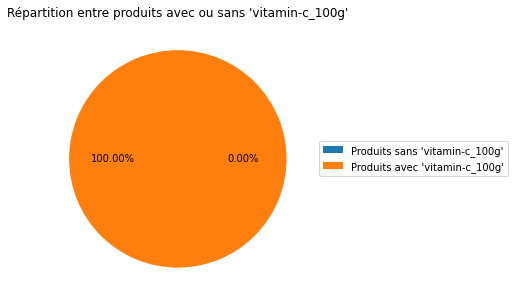

In [195]:
show_missing(data_clean, 'vitamin-c_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `energy_100g`

In [196]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

count   1718755.00
mean       1074.79
std         742.12
min           0.00
25%         418.00
50%        1067.00
75%        1582.00
max        3756.60
Name: energy_100g, dtype: float64


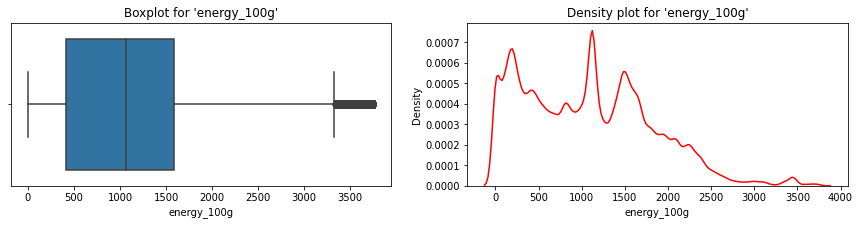

In [197]:
explore_quantitative(data_clean, 'energy_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 1718755 dans la colonne 'energy_100g' (0.00%)


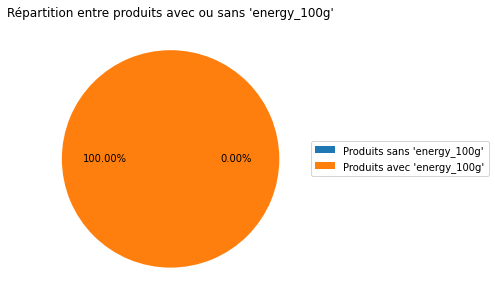

In [198]:
show_missing(data_clean, 'energy_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

## 5.2 Analyses multivariées <a class="anchor" id="analysis_multivariate"></a>

Les analyses multivariées ont pour vocation de mettre en évidence des informations sur les relations entre variables. Mais sans objectif on peut croiser beaucoup de données sans vraiment savoir ce que l'on cherche...

On va vu que la [documentation du nutriscore](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.


#### Hypothèse
> Nous allons donc essayer de **vérifier par des analyses bivariées et multivariées, si des colonnes pouvant correspondre à ces éléments favorables ou défavorables le sont effectivement au regard de `nutriscore_score` et de `nutriscore_grade`**.

> Voici donc les objectifs pour lesquels il serait utile d'avoir des informations:
> 1. Vérifier la relation entre `nutriscore_score` et les divers indicateurs des nutriments.
> 2. Vérifier la relation entre `nutriscore_grade` et les divers indicateurs des nutriments.
> 3. Vérifier la relation entre `nutriscore_score` et `nutriscore_grade`
> 4. Vérifier la relation entre `nutriscore_grade` et `pnns_groups_2` *(ça ne sert pas l'hypothèse, mais ça pourrait être intéressant)*

---

### 5.2.0 Commençons par vérifier les corrélations entre toutes les variables

#### Re-vérifions les indices de corrélation entre les variables `numériques` après imputations & nettoyage. <a class="anchor" id="P03_correlation_num"></a>

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.


Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

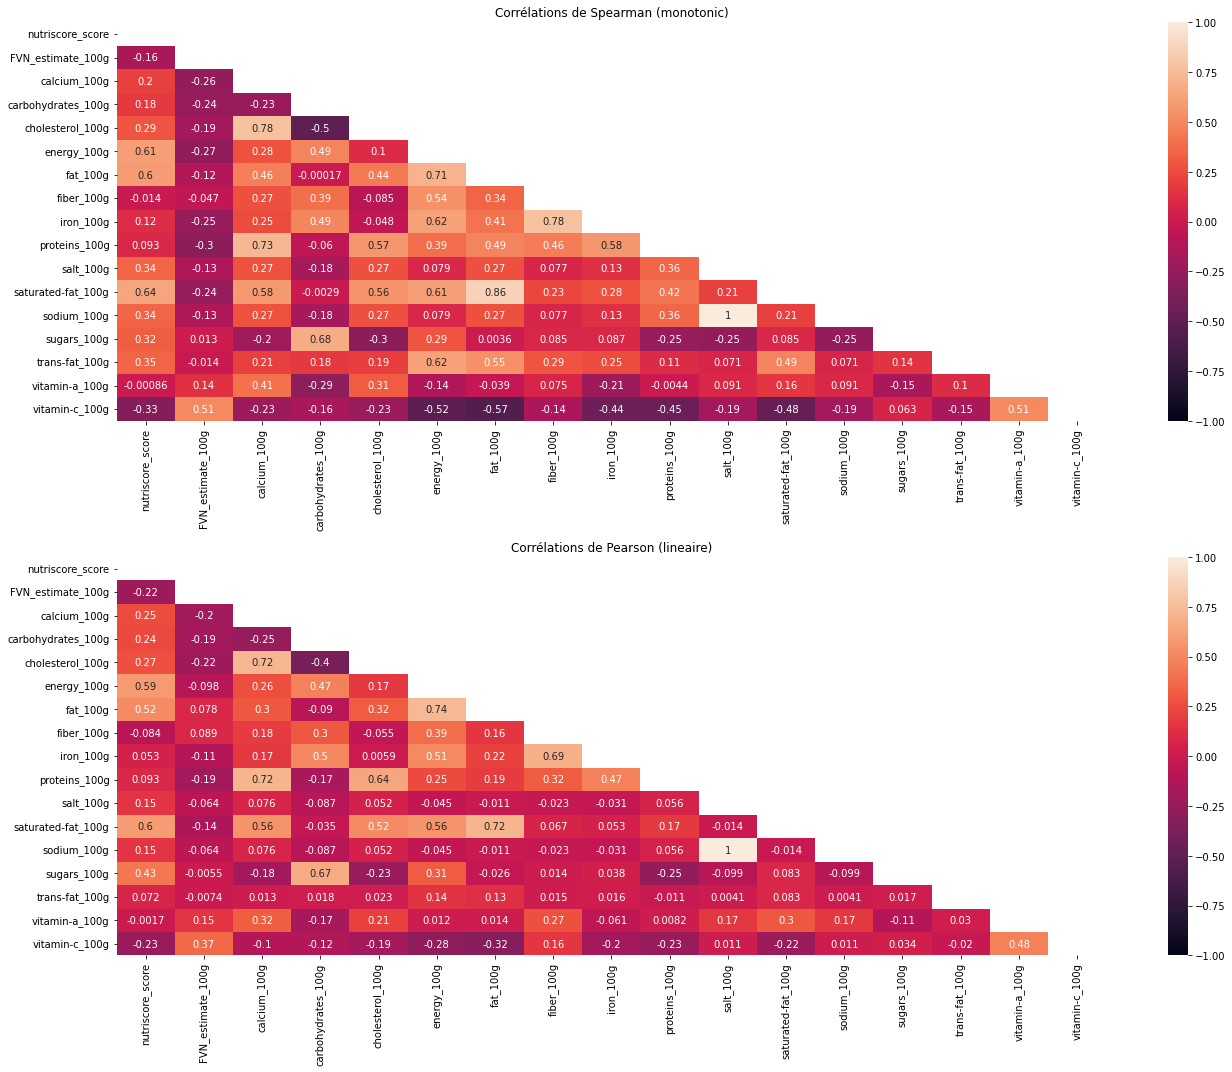

In [199]:
fig = plt.figure(figsize=(19,15))

plt.subplot(2,1,1)
corr= data_clean.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.legend()

plt.subplot(2,1,2)
corr= data_clean.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
#ax.legend()

fig.tight_layout()
plt.show()

> Nous avions [déjà vérifié ces indices](#clean_correlations) de corrélation avant le nettoyage des données. Le nettoyage a légèrement modifié ces données, mais les tendences restent les mêmes:
>
> - `energy_100g` *(0.59)*, `sugars_100g` *(0.43)*, `saturated-fat_100g` *(0.6)* et `fat_100g` *(0.52)* restent modèrement correlés.
> - `salt_100g` *(0.14)*, `sodium_100g` *(0.14)*, `FVN_estimate_100g` *(-0.21)*, `cholesterol_100g` *(0.25)*, `carbohydrates_100g` *(0.24)*, `calcium_100g` *(0.25)* et `vitamin-c_100g` *(-°.23) restent faiblement corrélés même si plusieurs score sont à la hausse.*
>
>
> - On note cependant l'apparition d'une forte corrélation entre le `calcium_100g` et le `cholesterol_100g`.
> - La colonne `vitamin-c_100g` qui étaient corrélée très peu de colonnes l'est à présent avec la plupart.
> - `fiber_100g` et `iron_100g`, `proteins_100g` et `calcium_100g` ou encore `proteins_100g` et `cholesterol` qui étaient modèrement corrélées, le sont à présent fortement.
>
> **Dans l'ensemble on note qu'après le nettoyage les corrélations sont plus marquées qu'avant.**

#### Puis vérifions les indices de corrélation entre les variables `numériques` et `nominales`.
                                                                                   
Pour permettre de vérifier simplement la corrélation entre les variables numériques et les variables nominales, nous allons utiliser un LabelEncoder sur les colonnes nominales qui nous intéressent puis calculer à nouveau les corrélations linéaires et monotones.<br>(On pourrait aussi calculer $\eta^2$ à partir d'une ANOVA)

In [200]:
data_corr = data_clean.copy()

In [201]:
from sklearn.preprocessing import LabelEncoder

In [202]:
cats = ['pnns_groups_2', 'nutriscore_grade', 'nova_group']

for cat in cats:
    encoder=LabelEncoder()
    encoder.fit(data_corr[cat])
    data_corr[f"{cat}_enc"]=encoder.transform(data_corr[cat])

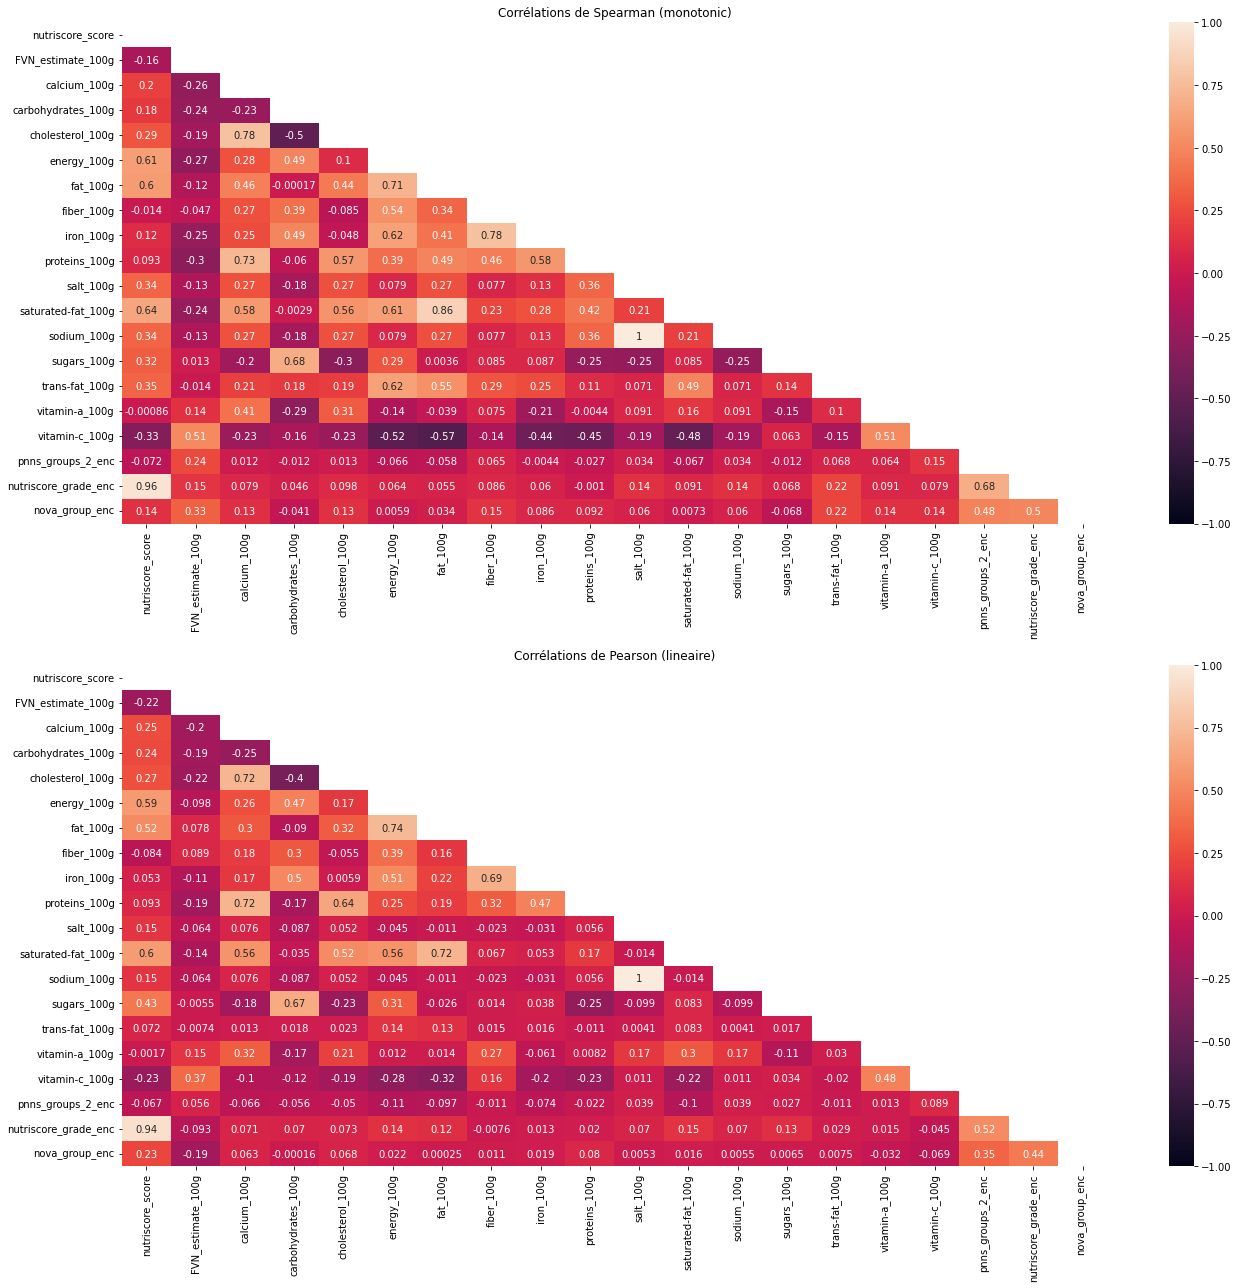

In [203]:
fig = plt.figure(figsize=(19,18))

plt.subplot(2,1,1)
corr= data_corr.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.legend()

plt.subplot(2,1,2)
corr= data_corr.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
#ax.legend()

fig.tight_layout()
plt.show()

> Comme attendu on constate une forte corrélation entre le `nutriscore_score` et `nutriscore_grade_enc`.
>
> On constate également plusieurs corrélations faibles entre `nutriscore_grade_enc` et les divers indicateurs nutritionnels, mais elles sont nettement moins prononcées qu'avec `nutriscore_score`.
>
> En revanche, `nutriscore_grade_enc` *(tous comme `nova_group_enc`)* semble moyennement corrélée avec les catégories de produits `pnns_groups_2`.
>
> Enfin, si les trois variables nominales encodées sont visiblement toutes modérement corrélées entre elles, on note que `nova_group_enc` et `pnns_groups_2_enc` ne semblent pas particulièrement sensible aux variables des nutriments.
---

#### Enfin vérifions les indices de corrélation entre les variables `nominales`. <a class="anchor" id="P03_correlation_nom"></a>

Pour ce faire, nous allons utiliser le test V de Cramer.<br>
C'est une mesure d'association entre deux variables nominales, qui est basée sur le Chi-squared de Pearson.<br>
Elle donne une valeur comprise entre 0 et +1 (inclus)
- 0 : il n'y a visiblement aucune relation entre les variables.
- 1 : il y a une relation parfaite entre les variables (on ne peut atteindre 1 que lorsque chaque variable est complètement déterminée par l'autre).

In [204]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

vars_ = ['nutriscore_grade', 'nova_group', 'pnns_groups_2']

corr = []
for v1 in vars_:
    corr2 = []
    for v2 in vars_:
        confusion_matrix = pd.crosstab(data[v1], data[v2])
        cramer_score = cramers_v(confusion_matrix.values)
        #print(f"{v1} / {v2} -> {cramer_score}")
        corr2.append(cramer_score)
    corr.append(corr2)
    
corr = pd.DataFrame(corr)
corr.index = corr.columns = vars_

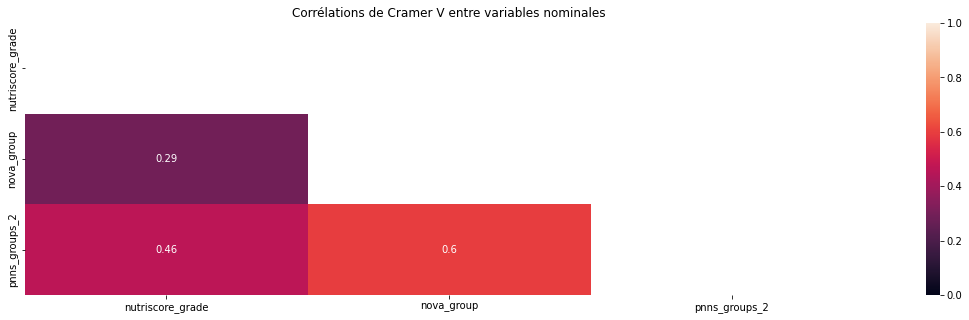

In [205]:
fig = plt.figure(figsize=(19,5))

matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Cramer V entre variables nominales')

plt.show()

> Le `nutriscore_grade` n'est que peu corrélé au `nova_group`, mais on constate en revanche que ces deux systèmes de classifications sont assez corrélés aux catégories de produits `pnns_groups_2`, comme nous l'avions déjà constatés un peu plus haut avec les corrélations de Pearson et Spearma en encodant ces variables.

### 5.2.1 Vérifions les relations entre `nutriscore_score` et les variables des nutriments
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [206]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)

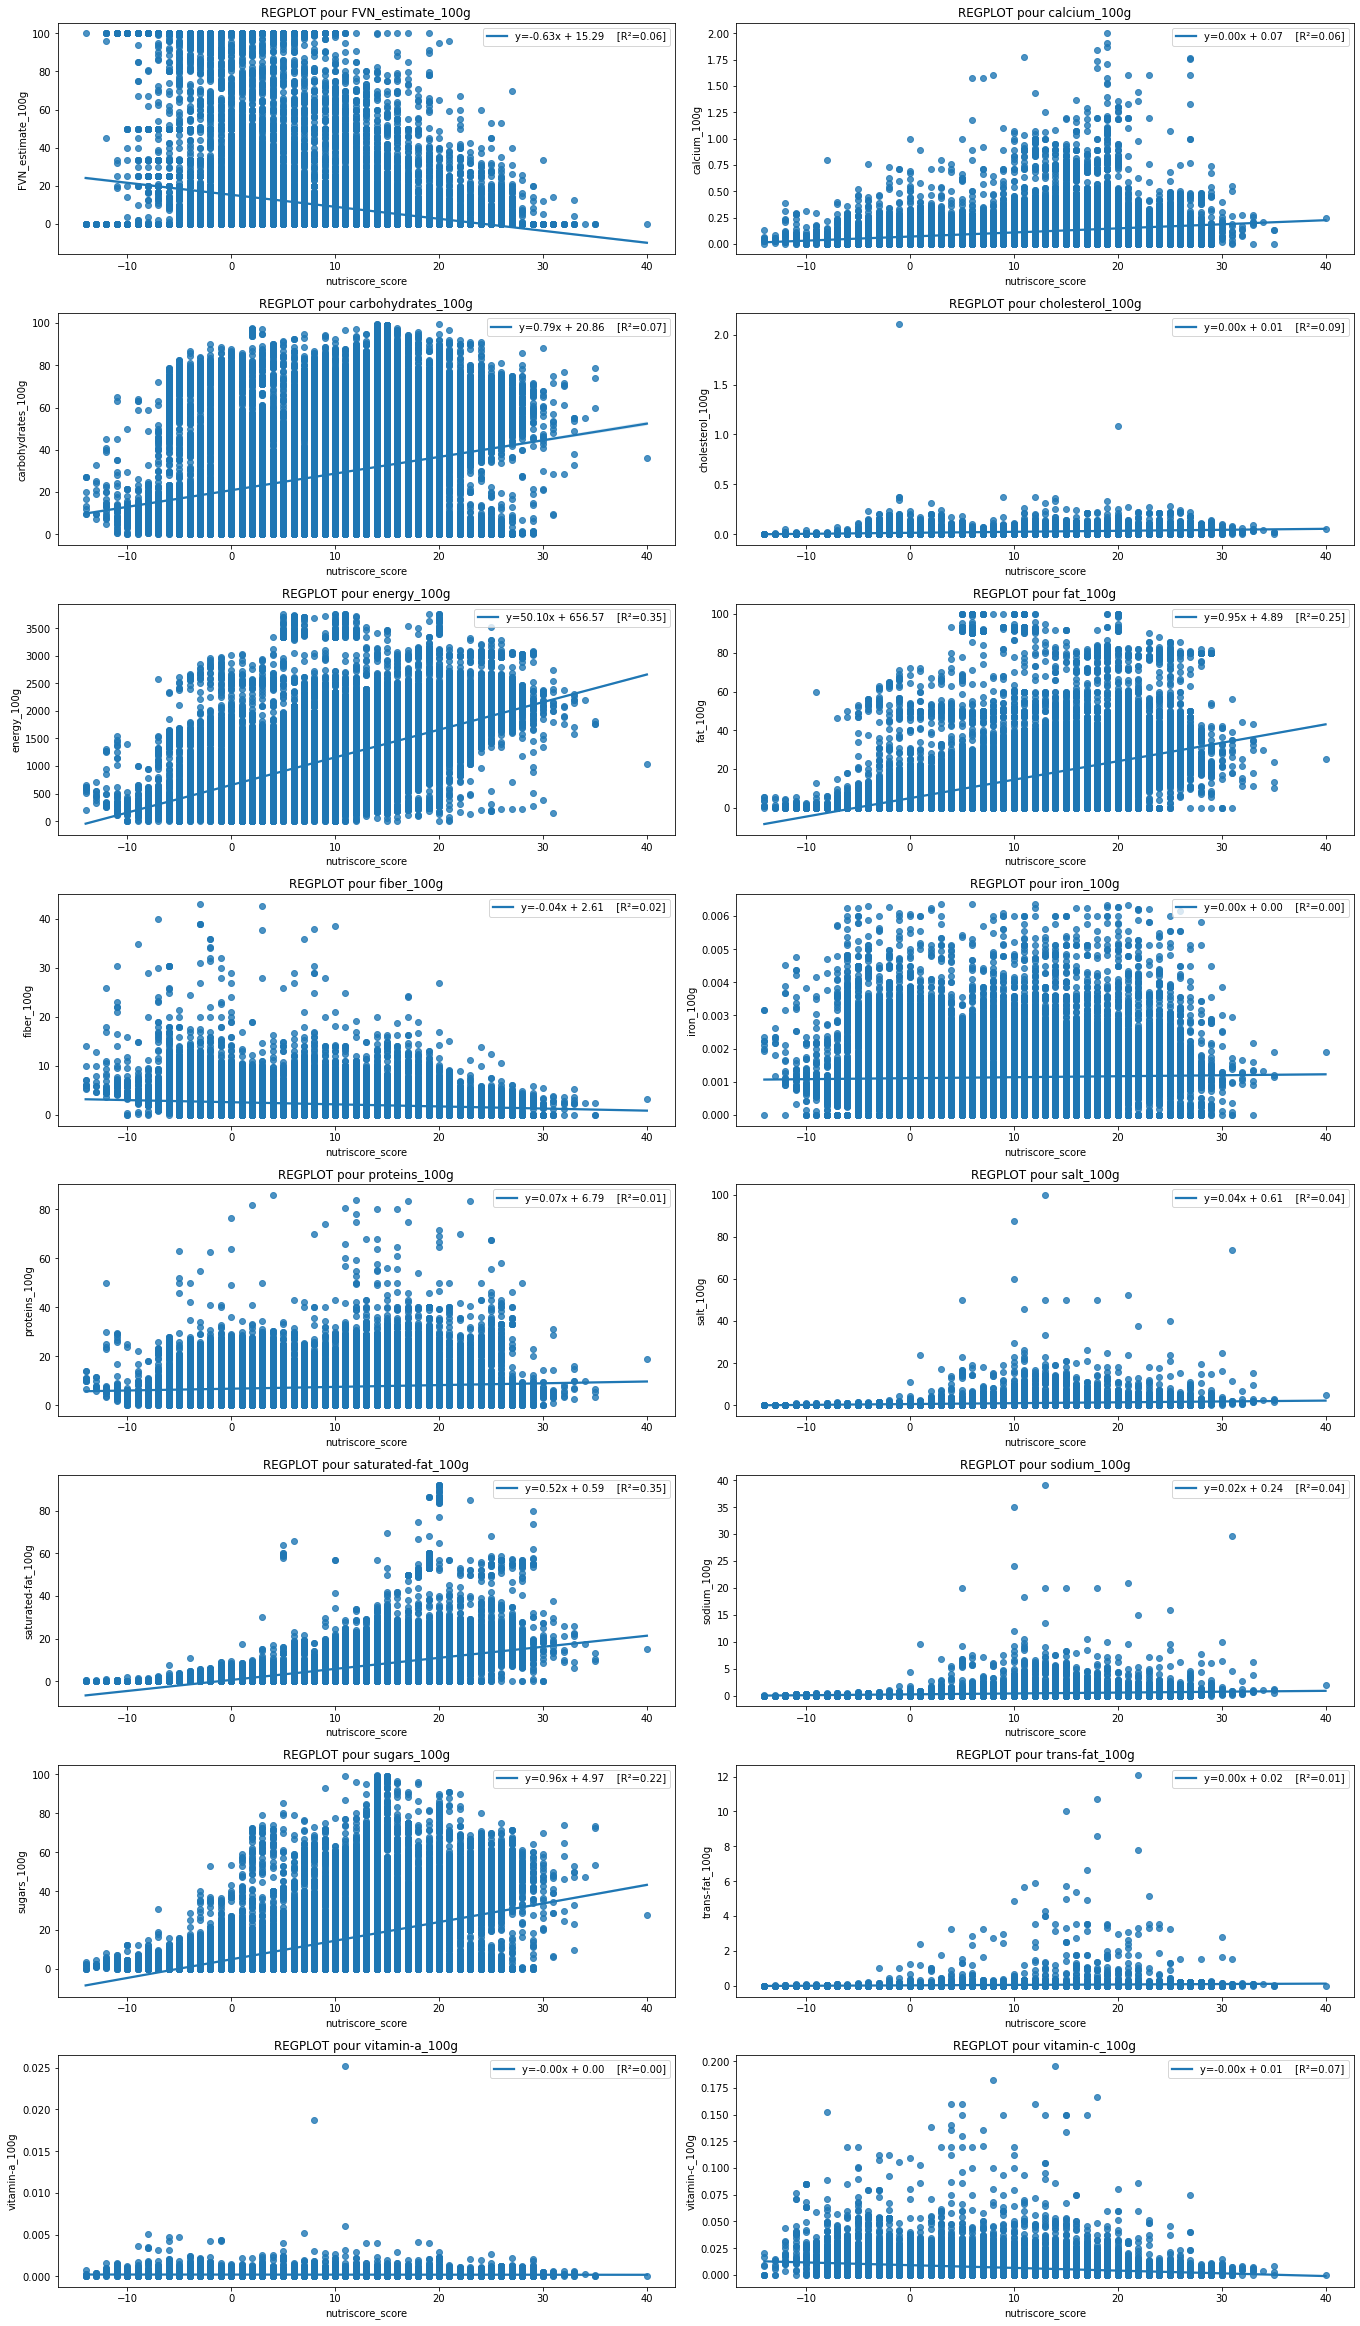

In [207]:
from scipy import stats
num_rows = math.ceil((len(var_nutri)+1)/2)

fig = plt.figure(figsize=(19,num_rows*4))

for i, col in enumerate(var_nutri):
    plt.subplot(num_rows,2,i+1)

    slope, intercept, r_value, pv, se = stats.linregress(data_sample['nutriscore_score'], data_sample[col])
    sns.regplot(
        x="nutriscore_score",
        y=col, 
        data=data_sample,
        line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"REGPLOT pour {col}")
    plt.legend()

fig.tight_layout()
plt.show()

> On constate que **les coéfficients de détermination R² se sont globalement affaiblis** par rapport à la [première exploration](#clean_linear) faite avant le nettoyage et les imputations, mais **dans l'ensemble les tendances sont les mêmes**.
>
> - `energy_100g`:        son **R² baisse** de 0.44 à **0.35**
> - `saturated-fat_100g`: son **R² baisse** de 0.43 à **0.35**
> - `sugars_100g`:        son **R² baisse** de 0.28 à **0.22**
> - `FVN_estimate_100g`:  son **R² baisse** de 0.08 à **0.06**
> - `salt_100g`:          son **R² baisse** de 0.07 à **0.04**
> - `fiber_100g`:         son **R² baisse** de 0.04 à **0.02**
> - `proteins_100g`:      son **R² reste stable** à **0.01**
> - `fat_100g`:           son **R² baisse** de 0.36 à **0.25**
> - `carbohydrates_100g`  son **R² baisse** de 0.10 à **0.07**
> - `cholesterol_100g`    son **R² augmente** de 0.08 à **0.09**
> - `sodium_100g`         son **R² baisse** de 0.07 à **0.04**
> - `calcium_100g`        son **R² augmente** de 0.03 à **0.06**
> - `vitamin-c_100g`      son **R² augmente** de 0.02 à **0.07**
>
> Cette diminution des R² s'explique par le fait que les imputations ont crée des valeurs moins reserrées autour des lignes de regressions.

### 5.2.2 Vérifions les relations entre `nutriscore_grade` et les variables des nutriments

In [208]:
mean_nutri = []
grades = ['A','B','C','D','E']
for grade in grades:
    mean_nutri.append(list(data_clean[data_clean.nutriscore_grade == grade][var_nutri].mean(numeric_only=True)))

mean_nutri_pd = pd.DataFrame(mean_nutri, columns=var_nutri, index=grades)
mean_nutri_pd.drop(['energy_100g'], axis=1, inplace=True)

# On transforme en %
sum_nutri_pd = mean_nutri_pd.sum()
mean_nutri_pd = 100/sum_nutri_pd*mean_nutri_pd
mean_nutri_pd

FVN_estimate_100g  calcium_100g  carbohydrates_100g  cholesterol_100g  \
A              31.38         14.86               18.30             12.31   
B              20.70         15.14               13.41             16.11   
C              26.18         15.52               17.99             15.02   
D              12.33         26.79               23.34             26.89   
E               9.41         27.68               26.96             29.68   

   fat_100g  fiber_100g  iron_100g  proteins_100g  salt_100g  \
A      5.33       28.07      22.77          20.55       6.22   
B      7.59       15.94      16.47          17.27      10.62   
C     17.80       20.12      19.11          17.09      25.34   
D     27.86       18.77      21.22          25.19      31.28   
E     41.42       17.10      20.43          19.90      26.54   

   saturated-fat_100g  sodium_100g  sugars_100g  trans-fat_100g  \
A                2.40         6.22         6.36            7.90   
B                4.65        10.62         7.95           10.14   
C               10.95        25.29        17.24           18.05   
D               28.48        31.30        27.30           26.93   
E               53.51        26.56        41.15           36.99   

   vitamin-a_100g  vitamin-c_100g  
A           22.65           26.44  
B           18.03           22.50  
C           18.77           22.47  
D           18.88           15.43  
E           21.67           13.16

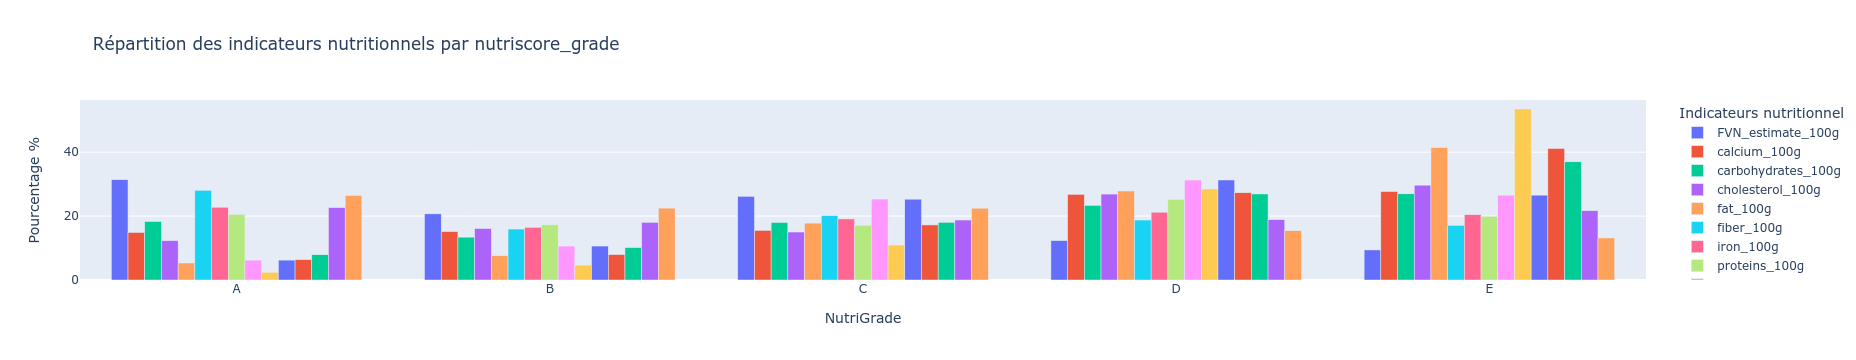

In [209]:
fig = px.bar(
    title="Répartition des indicateurs nutritionnels par nutriscore_grade",
    data_frame=mean_nutri_pd,
    #x="", y="", color="",
    barmode='group',
    labels={
        "variable": "Indicateurs nutritionnels",
        "index": "NutriGrade",
        "value": "Pourcentage %"
    },
)

fig.show()

> En isolant les colonnes une à une *(clique sur les noms)*, on constate 4 types de tendances:
>
> - Celles qui tendent à augmenter avec le grade *(de A vers E)*; <br>`calcium_100g`, `carbohydrates_100g`, `cholesterol_100g`, `fat_100g`, `saturated-fat_100g`.
>
> - Celles qui tendent à augmenter avec le grade, mais avec un maximum sur D au lieu de E; <br>`salt_100g`, `sodium_100g`.
>
> - Celles qui tendent à baisser avec le grade, mais avec un rebond en C; <br>`FVN_estimate_100g`, `fiber_100g`
>
> - Et celles qui tendent à rester assez neutres vis à vis des différents grades *(il peut y avoir un grade plus présent qu'un autre, mais c'est assez peu marqué)*.

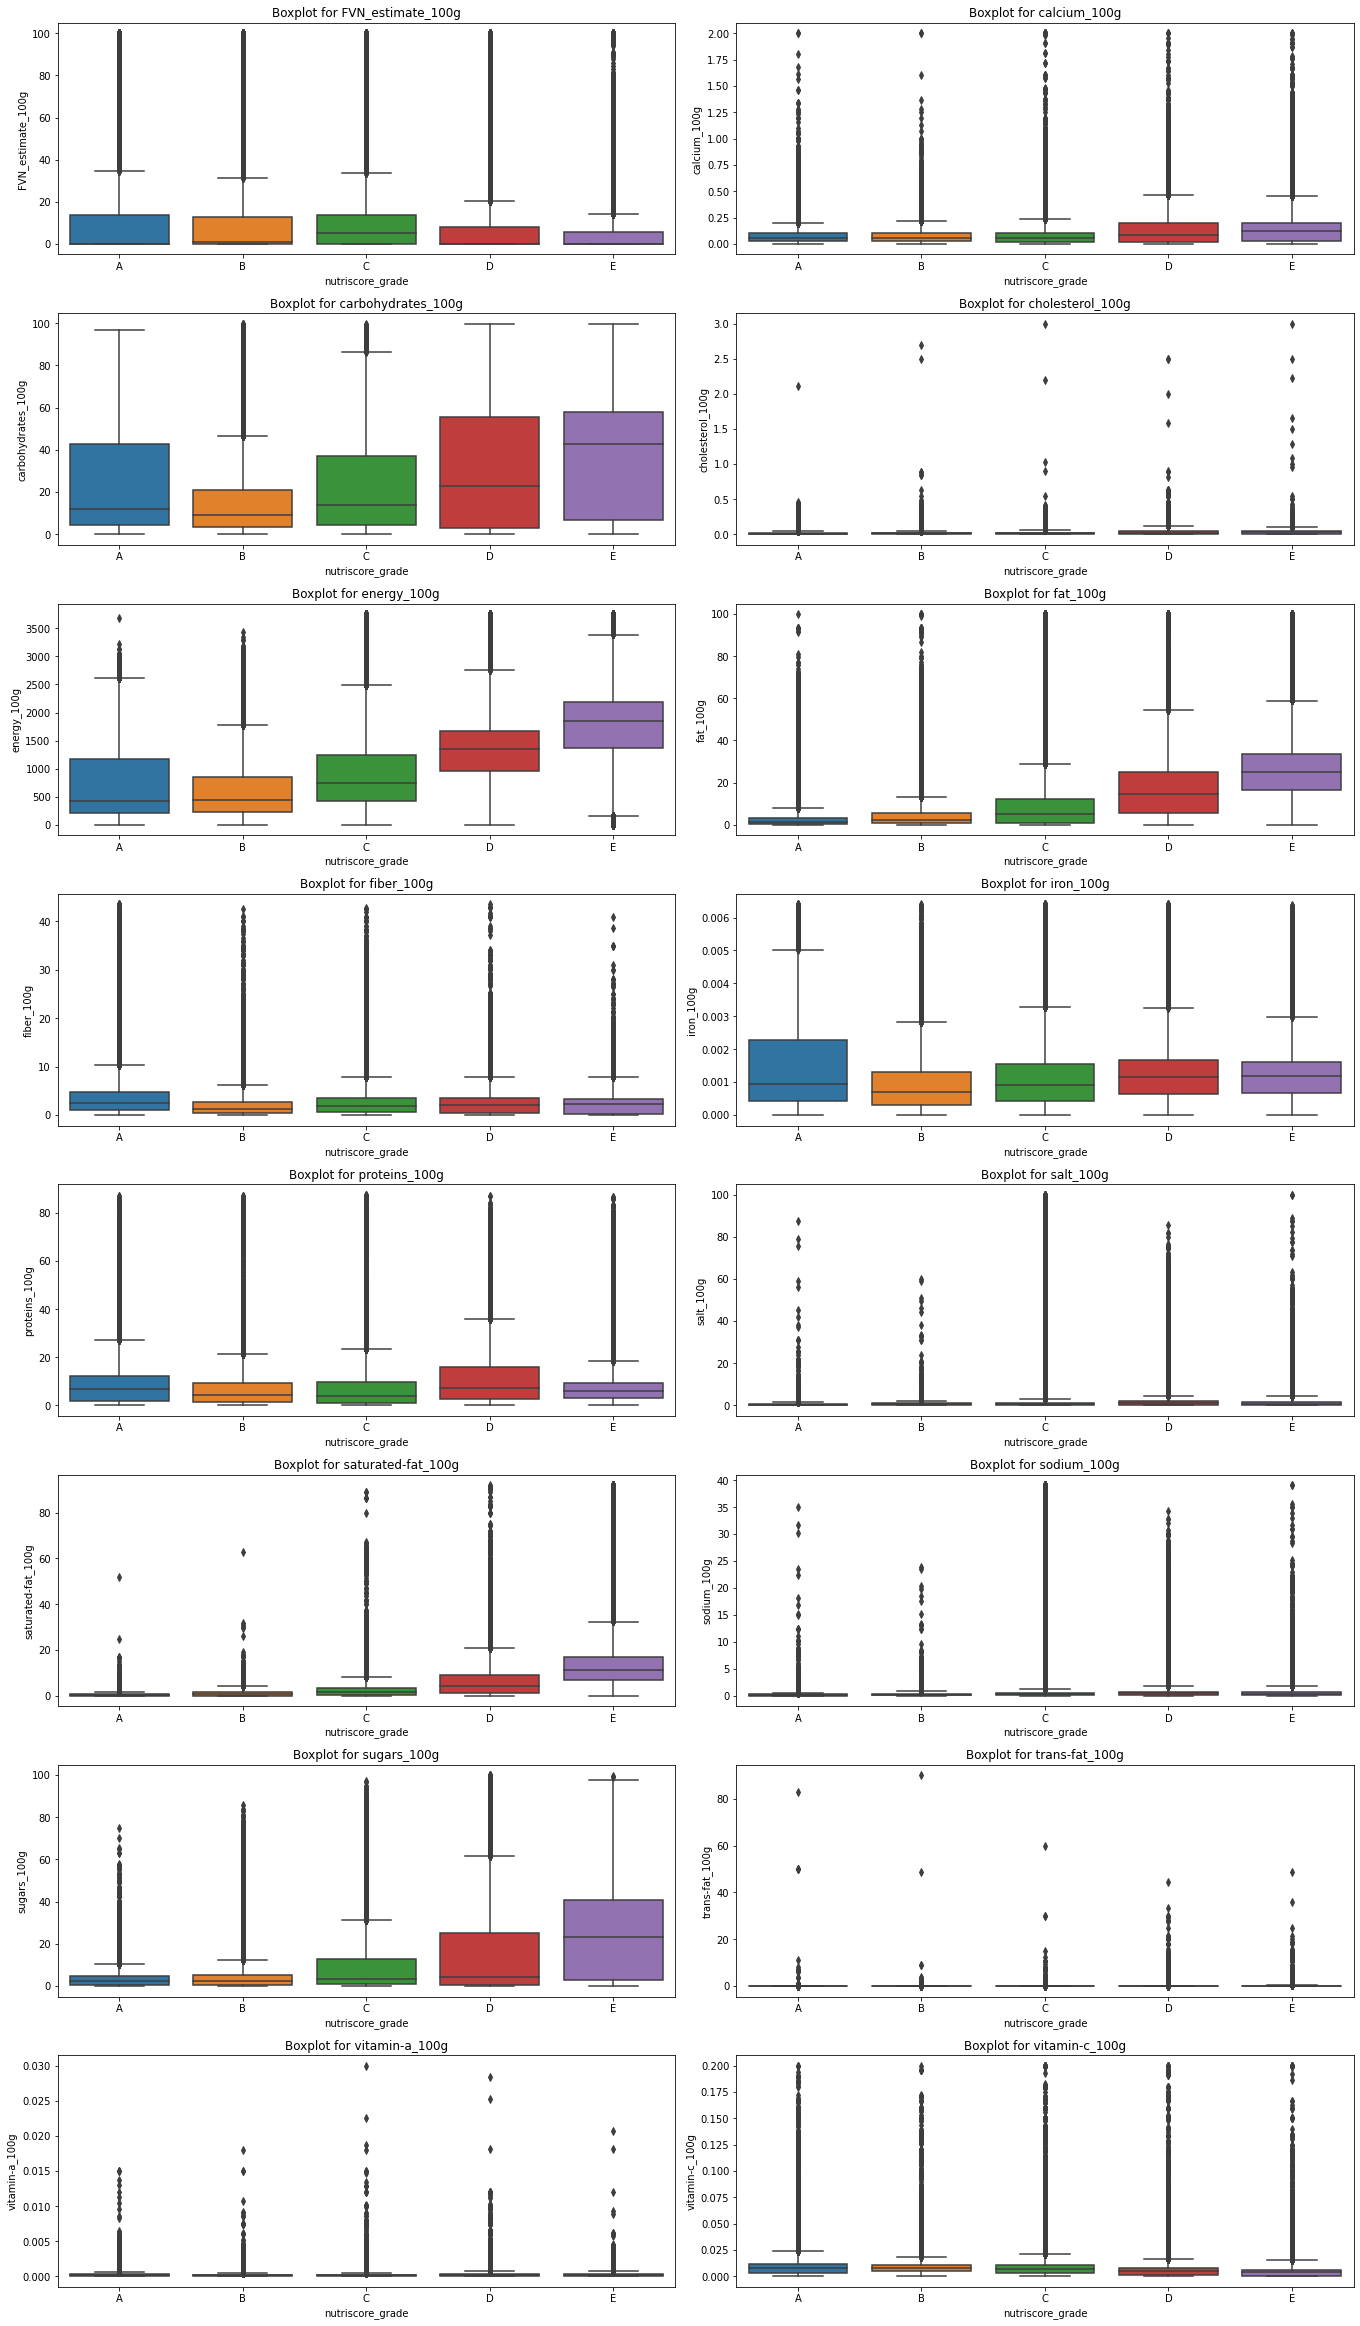

In [210]:
num_rows = math.ceil((len(var_nutri)+1)/2)

fig = plt.figure(figsize=(19,num_rows*4))

for i, col in enumerate(var_nutri):
    plt.subplot(num_rows,2,i+1)
    sns.boxplot(data=data_clean, x='nutriscore_grade', y=col, order='ABCDE')
    plt.title(f"Boxplot for {col}")

fig.tight_layout()
plt.show()

> Comme vu dans la seconde table de corrélation de la partie 5.2.0, les différentes colonnes de valeurs nutritionnelles présentes un moindre degrès de corrélation avec la colonne `nutriscore_grade` qu'avec la colonne `nutriscore_score`. Cette tendance se vérifie une fois encore avec les box-plots ci-dessus; les corrélations ne sont pas flagrantes.
>
> Il semble donc plus intéressant d'essayer de prédire le `nutriscore_score` plutôt que le `nutriscore_grade`.

### 5.2.3 Vérifions la relation entre `nutriscore_grade` et `nutriscore_score`

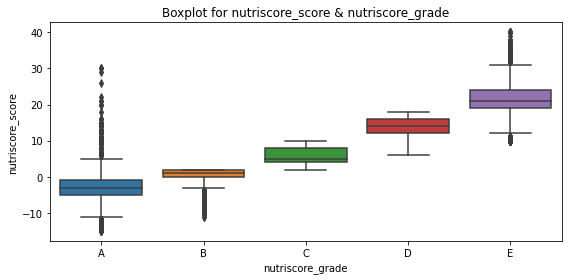

In [211]:
fig = plt.figure(figsize=(8,4))

sns.boxplot(data=data_clean, x='nutriscore_grade', y='nutriscore_score', order='ABCDE')
plt.title(f"Boxplot for nutriscore_score & nutriscore_grade")

fig.tight_layout()
plt.show()

> Sur ce boxplot `nutriscore_score` vs `nutriscore_grade`, on perçoit immédiatement une relation forte.
>
> La documentation indique les plages suivantes pour les aliments:
> - [-15;-1] pour le **A**
> - [0;2] pour le **B**
> - [3;10] pour le **C**
> - [11;18] pour le **D**
> - [19;40] pour le **E**
>
> La documentation indique les plages suivantes pour les boissons:
> - Uniquement l'eau pour le **A**
> - [-15;1] pour le **B**
> - [2;5] pour le **C**
> - [6;9] pour le **D**
> - [10;40] pour le **E**
>
> On remarque des outliers, mais on constate que ces valeurs semblent majoritairement respectées.

Une autre façon de vérifier la relation entre ces deux colonnes et de regarder comment elles réagissent ensemble au regard des valeurs nutritionnelles...

#### Affichons donc un graphique permettant de confronter chaque variable nutritionnelles à `nutriscore_score` et `nutriscore_grade`.

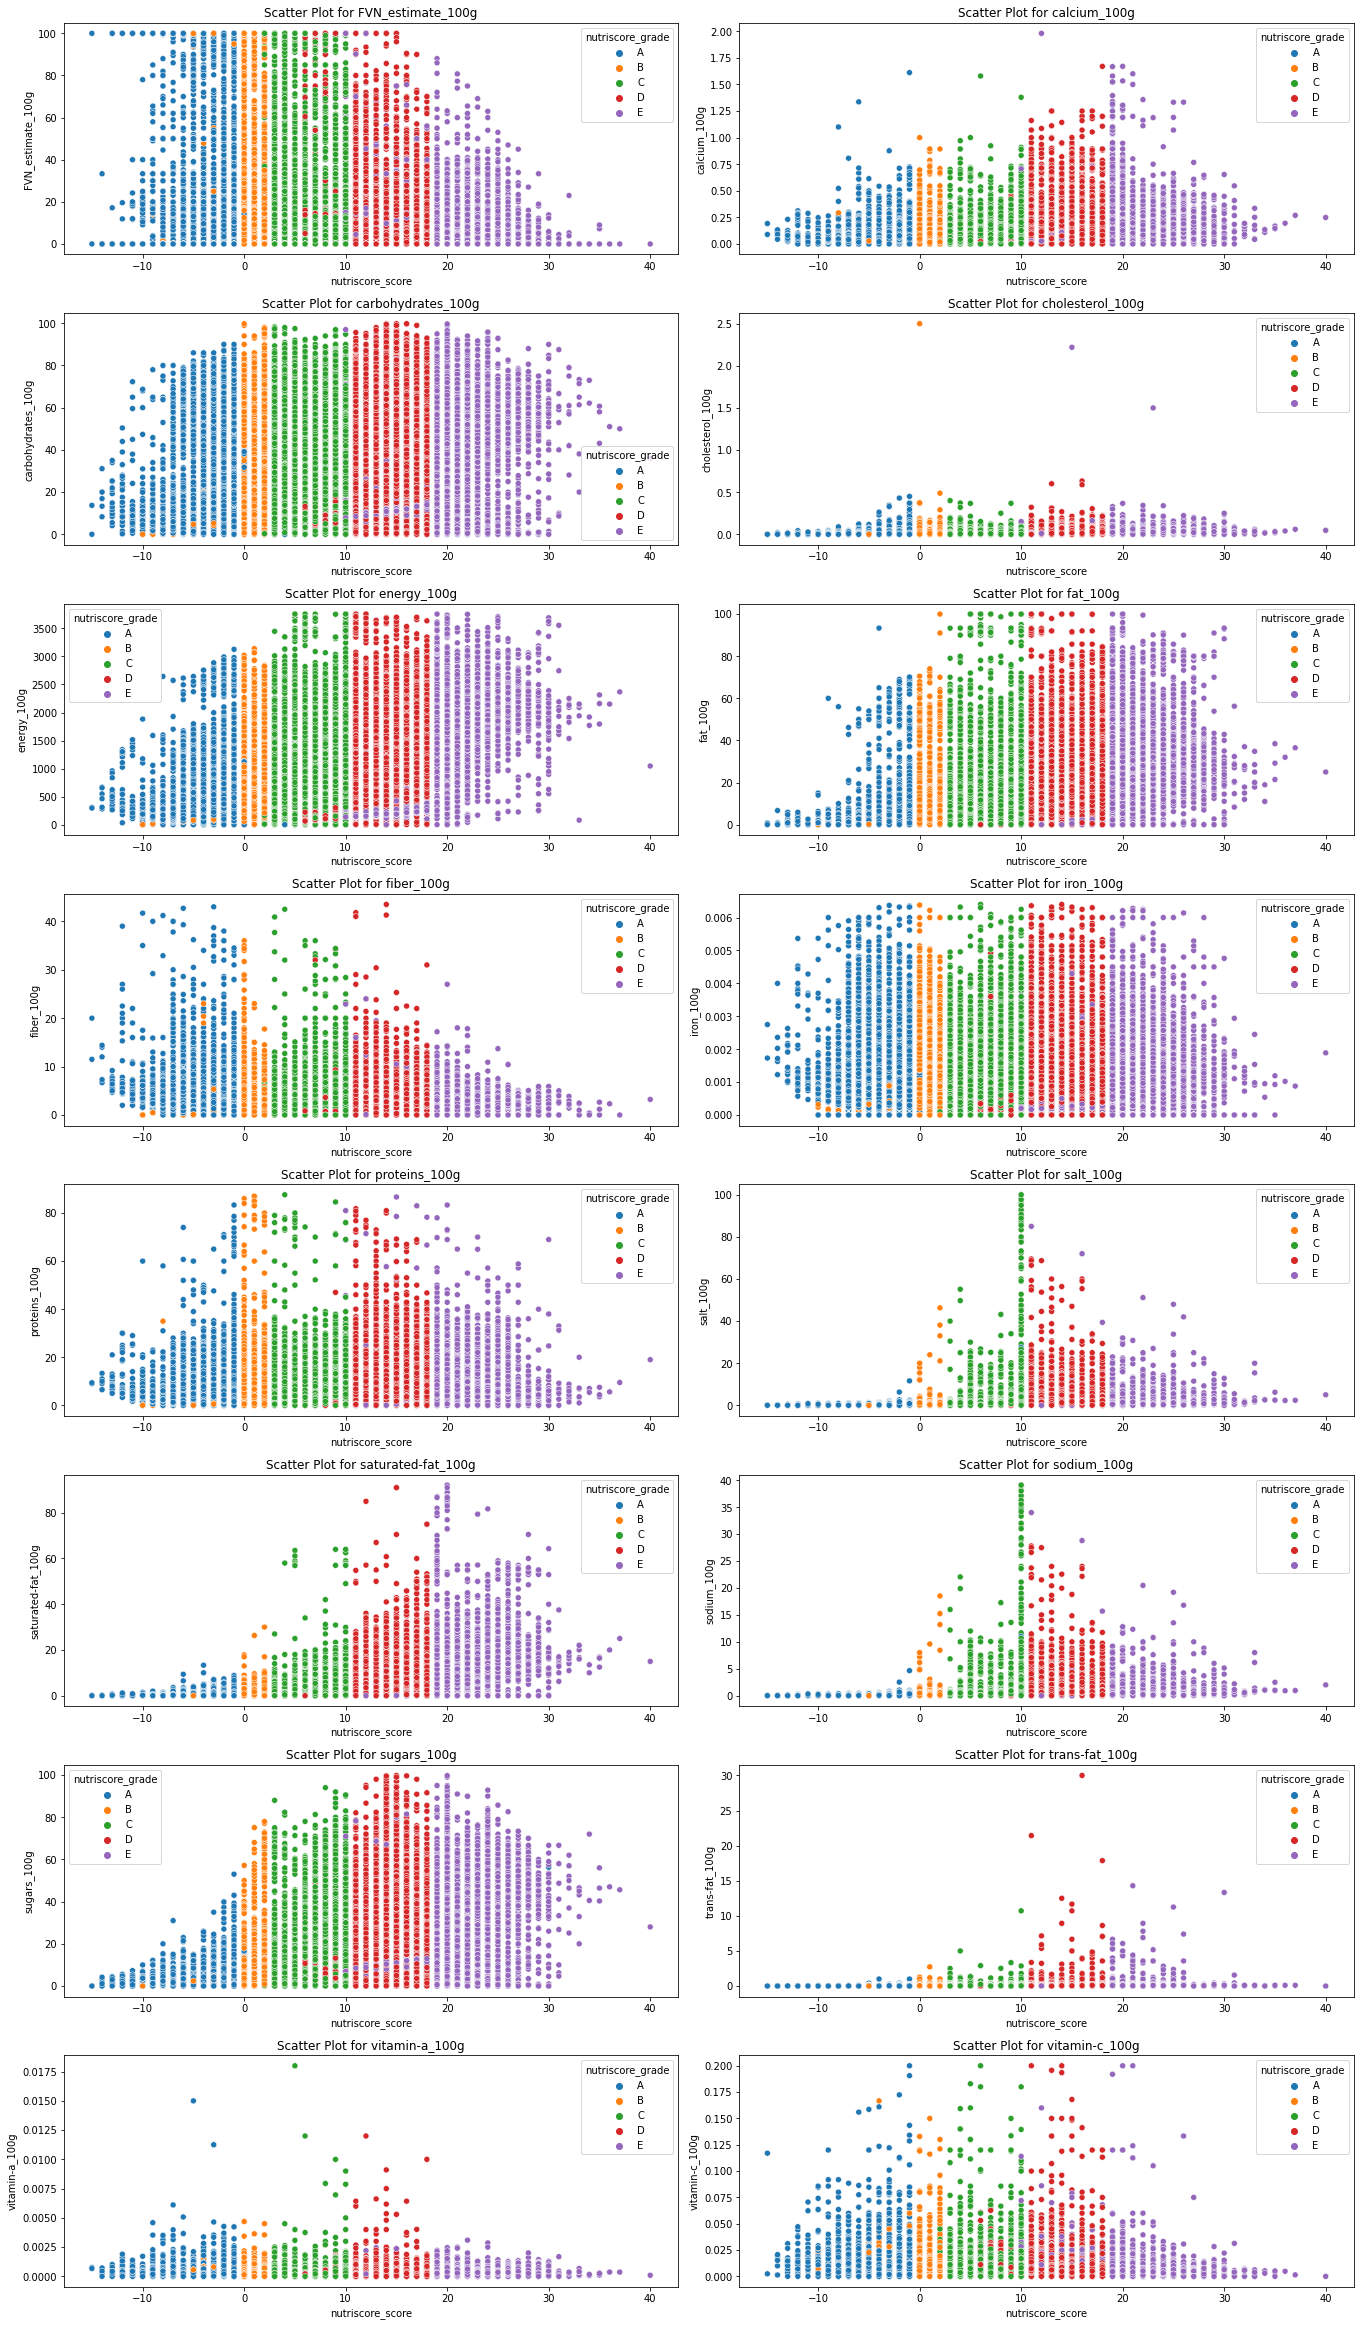

In [212]:
columns_ = var_nutri.copy()
#columns_.append('nutriscore_score')
data_sample = data_clean.sample(frac=0.1)
num_rows = math.ceil((len(columns_)+1)/2)

fig = plt.figure(figsize=(19,num_rows*4))

for i, col in enumerate(columns_):
    plt.subplot(num_rows,2,i+1)
    sns.scatterplot(x=data_sample['nutriscore_score'], y=data_sample[col], hue=data_sample['nutriscore_grade'], hue_order='ABCDE')
    plt.title(f"Scatter Plot for {col}")

fig.tight_layout()
plt.show()

> Si on se concentre purement sur la relation entre le `nutriscore_score` et le `nutriscore_grade`, on peut voir que la distribution du `nutriscore_grade` semble globalement respecter le positionnement escomptée sur l'échelle des le `nutriscore_score`.
>
> Il y a bien quelques `grades` en dehors des `scores` attendus, mais c'est un phénomènes assez restreint qui semble surtout toucher le groupe **E** *(qui déborde sur le groupe **D**)* et dans une moindre mesure le groupe **D** *(qui déborde sur le groupe **C**)*.

> Si on compare le `nutriscore_score` et le `nutriscore_grade` avec les colonnes des indicateurs nutritionnels, on remarque que certaines colonnes ne sont visuellement pas corrélées avec elles, alors que d'autres en revanches sont très marquées dans leur distribution. C'est le cas pour :
>
> - `sugars_100g` *(faible en A, fort en E)*
> - `energy_100g` *(faible en A, fort en E)*
> - `saturated_fat_100g` *(faible en A, fort en E)*
> - `fat_100g` *(faible en A, fort en E)*
> - `FVN_estimate_100g` *(fort en A, faible en E)*
> - `fiber_100g` *(fort en A, faible en E)*
> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*
> - `proteins_100g` *(faible en A et D et plus fort en B, C, D)*
>
> Ces colonnes sont certainement les plus intéressantes pour préparer un modèle de prédiction du `nutriscore_score` et donc du `nutriscore_grade`.<br>On remarque d'ailleurs que ce sont à peu près les colonnes que l'on a identifié comme indéressantes en regard de la documentation du Nutriscore.

### 5.2.4 Vérifions les relations `pnns_groups_2` vs `nutriscore_score` et `nutriscore_grade`

#### Regardons la répartition des catégories `pnns_groups_2` sur les différents grade de `nutriscore_grade`

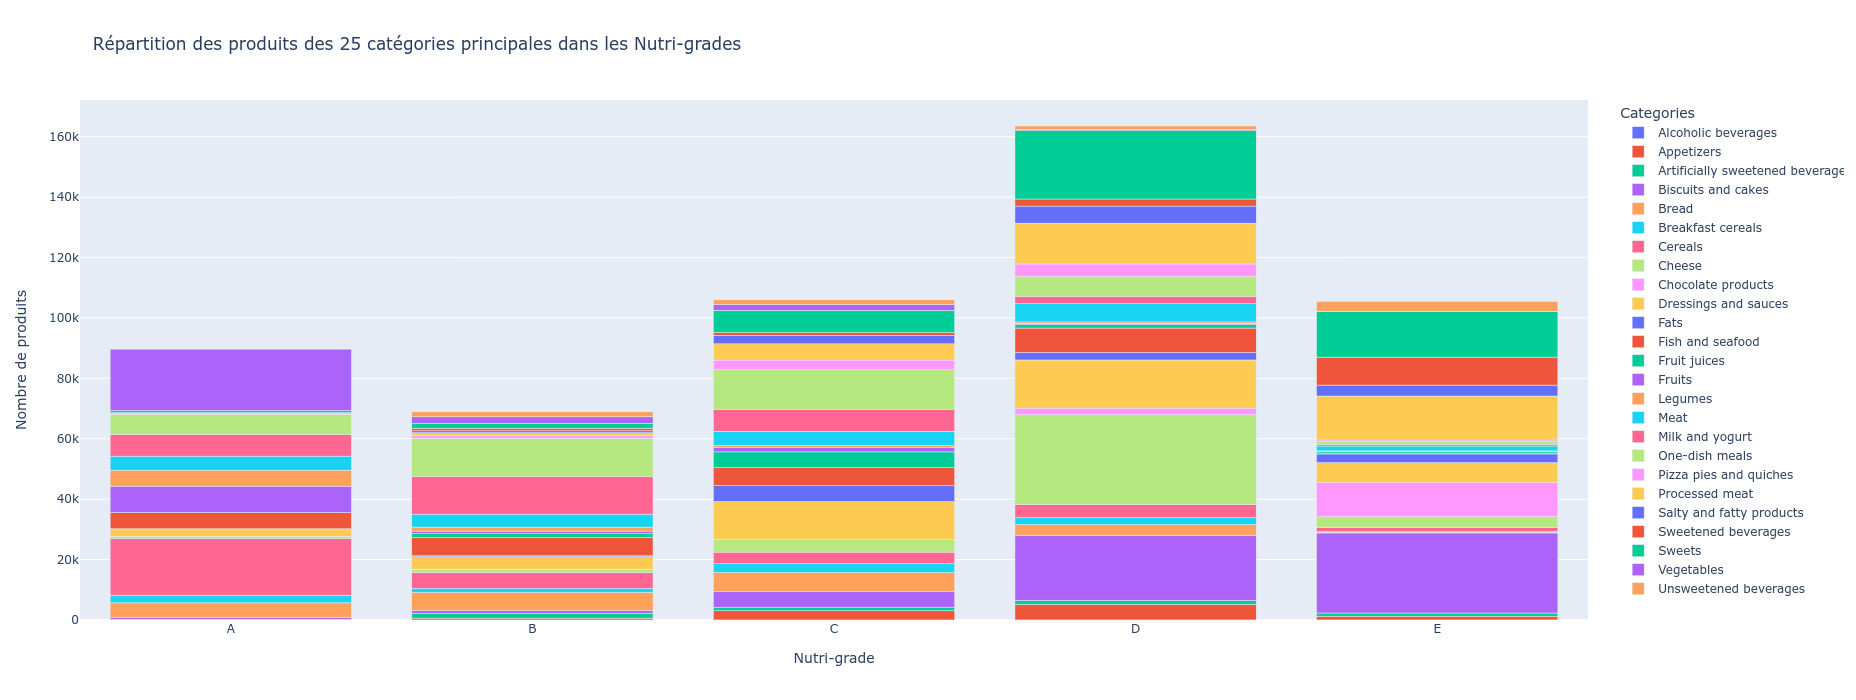

In [213]:
num_cats = 25
top_categories = list(data_clean['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

#--- prepare data
#data_tmp = data_clean.copy()
#data_tmp['category'] = data_tmp['pnns_groups_2']
#data_tmp.loc[~data_tmp['pnns_groups_2'].isin(top_categories),'category'] = 'OTHERS'
#top_categories.append('OTHERS')

#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="nutriscore_grade",
             y="count",
             color="pnns_groups_2",
             title=f"Répartition des produits des {num_cats} catégories principales dans les Nutri-grades",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'nutriscore_grade': ['a','b','c','d','e']},
             height=700,
            )
fig.show()

En explorant ce graphique interactif, on constate que :

> Le `grade A` semble contenir des **aliments bruts**; *légumes*, *céréales*, *fruits*, *viandes*, *poissons* et *produits laitiers*. Mais aussi **quelques produits transformés** comme des *plats-cuisinés* et *sucreries* qui sont plus surprenants.

> Le `grade B` semble contenir des **aliments bruts** et des **produits transformés**; *plats-cuisinés*, *produits-laitiers*, *viandes*, *poissons*, *céréales**, *pains*...

> Le `grade C` semble contenir des **produits bruts gras** et des **produits transformés**; *plats-cuisinés*, *huiles*, *sauces*, *biscuits & cakes*, *sucreries*, *viandes transformées* mais aussi quelques *viandes* et *poissons*...

> Le `grade D` semble contenir des **produits transformés gras / sucrés / salés**; *fromages*, *bicuits & cakes*, *sucreries*, *viandes transformées*, *poissons*, *sauces*, ...

> Le `grade E` semble contenir des **produits transformés gras / sucrés / salés** plus orientés encas; *biscuits & cakes*, *sucreries*, *viandes transformées*, *chocolats*, *boissons sucrées*...

#### Regardons à présent pour chacune de ces catégories `pnns_groups_2` leur répartition dans les `nutriscore_grade`

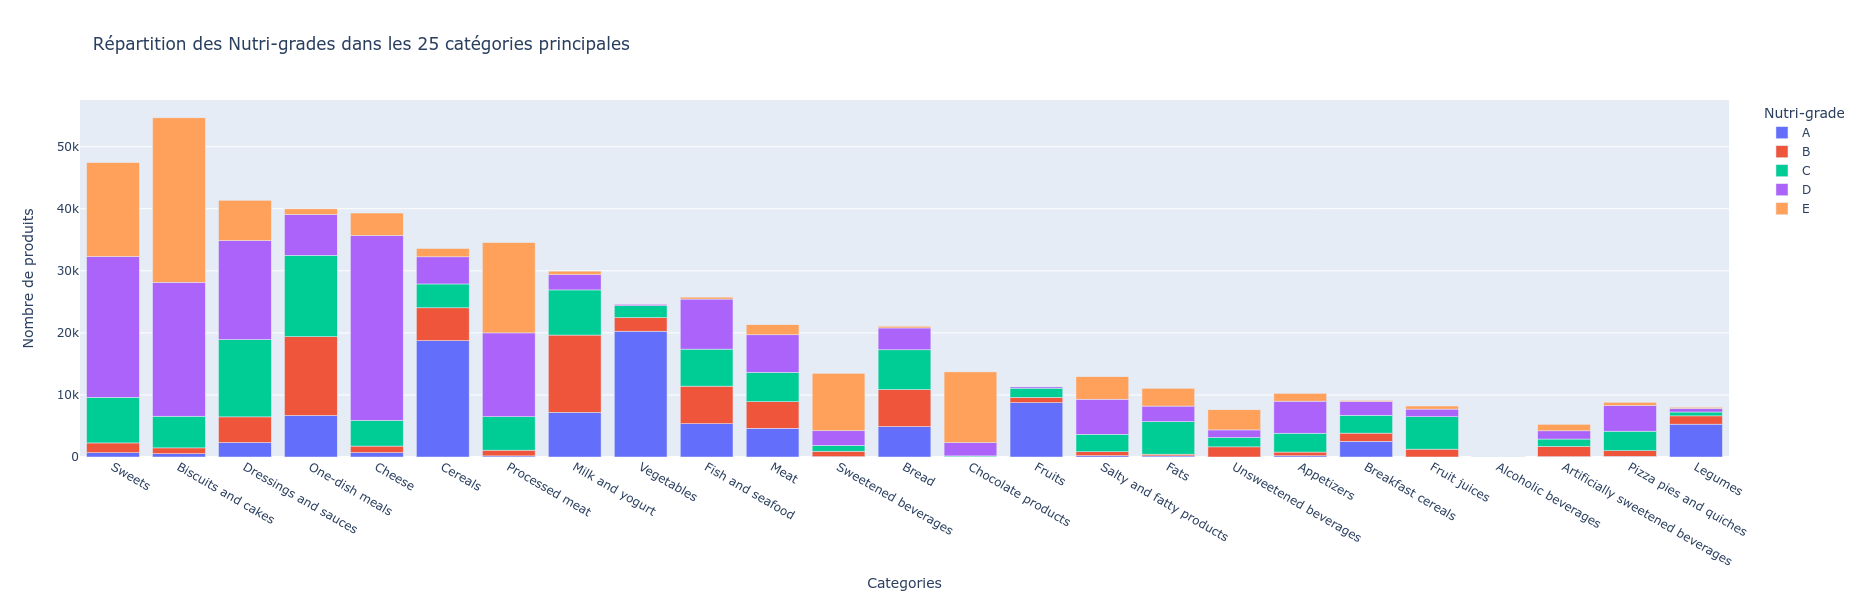

In [214]:
#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="pnns_groups_2",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades dans les {num_cats} catégories principales",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'pnns_groups_2': top_categories},
             height=600,
            )
fig.show()

Si l'on prend quelques catégories emblématiques, on constate que le classement est assez cohérant avec ce que l'on à découvert plus haut *(tendances à monter en grade de A vers E, avec le sucre, le gras, le sel...)*

> Les `Vegetables` *(légumes)* sont essentiellement classés `A`.

> Les `One-dish meals` *(repas complet en un seul plat)* sont essentiellement classés `B` et `C`

> Les `Sweets` *(sucreries)* sont essentiellement classés `D` et `E`.

In [215]:
data_clean[ (data_clean.pnns_groups_2 == 'Alcoholic beverages') & (data_clean.nutriscore_grade.notnull()) ].shape[0]

51

La colonne `Alcoholic beverages` semble vide, mais c'est parcque cette catégorie a peu de données `nutriscore_grade` *(il faut zoomer)*.

---

### Bilan des analyses multivariées

> Au cours de ces analyses, **nous avons pu mettre en évidence la corrélation** qui existe:
> - entre `nutriscore_score` et `nutriscore_grade`.
> - entre `nutriscore_score` et les divers indicateurs nutritionnels.
> - entre `nutriscore_grade` et les divers indicateurs nutritionnels dans une miondre mesure.
> - entre `nutriscore_grade` ou `nutriscore_score`et les catégories `pnns_groups_2`.

> Nous avons égalements mis en évidence le fait que certains indicateurs nutritionnels ne présentent que peu d'intérêt vis à vis des colonnes cibles `nutriscore_score` ou `nutriscore_grade`. <br>
> Il conviendrait donc de ne garder que celles qui semblent les plus utiles au futur modèle prédictif.
>
>> Sur la base de la **documentation NutriScore**, il faudrait sélectionner les colonnes suivantes:
>>
>> Éléments défavorables au score:
>> - `energy_100g` << *Apport calorique pour cent grammes*
>> - `saturated-fat_100g` << *Teneur en graisses saturées*
>> - `sugars_100g` << *Teneur en sucre*
>> - `salt_100g` << *Teneur en sel*
>>
>> Éléments favorables au score:
>> - `FVN_estimate_100g` << *Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive*
>> - `fiber_100g`  << *Teneur en fibres*
>> - `proteins_100g` << *Teneur en protéines*
>
>> Sur la base des **tables de corrélations**, il faudrait sélectionner les colonnes suivantes:
>>
>> - `saturated-fat_100g` = 0.58 / 0.64
>> - `energy_100g` = 0.58 / 0.60
>> - `fat_100g` = 0.47 / 0.59
>> - `sugars_100g` = 0.43 / 0.33
>> - `carbohydrates_100g` = 0.24 / 0.18
>> - `cholesterol_100g` = 0.19 / 0.26
>> - `sodium_100g` = 0.16 / 0.34
>> - `salt_100g` = 0.15 / 0.34
>> - `vitamin-c_100g` = -0.13 / -0.27
>> - `fiber_100g` = -0.17 / -0.2
>> - `FVN_estimate_100g` = -0.24 / -0.19
>
>> Sur la base des **coefficients de détermination R²** des régressions linéaires opposant `nutriscore_score` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
>> - R² `energy_100g`= 0.35
>> - R² `saturated-fat_100g` = 0.35
>> - R² `fat_100g` = 0.25
>> - R² `sugars_100g` = 0.22
>
>> Sur la base de l'analyse visuelle des graphiques opposant `nutriscore_score` & `nutriscore_grade` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
>> - `energy_100g` *(faible en A, fort en E)*
>> - `saturated_fat_100g` *(faible en A, fort en E)*
>> - `sugars_100g` *(faible en A, fort en E)*
>> - `fat_100g` *(faible en A, fort en E)*
>> - `FVN_estimate_100g` *(fort en A, faible en E)*
>> - `fiber_100g` *(fort en A, faible en E)*
>> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
>> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*


> Comme on a vu que certaines colonnes sont très proches voir redondantes, on va les éliminer et **garder la liste suivante** pour consuire une ACP et un test statistique:
>
> - **`energy_100g`**
> - **`saturated-fat_100g`**
> - **`sugars_100g`**
> - **`salt_100g`**
> - **`FVN_estimate_100g`**
> - **`fiber_100g`**

## 5.3 Analyse en composantes principales <a class="anchor" id="pca"></a>

L'analyse en composantes principales (ACP ou PCA en anglais) est une méthode qui consiste à transformer des variables liées entre elles *(dites « corrélées » en statistique)* en nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont nommées **composantes principales** ou axes principaux. Elle permet de résumer l'information en réduisant le nombre de variables, ou de produire des modèles plus légers.

### 5.3.0 Préparation des données pour l'ACP

In [216]:
var_nutri_pca = [
    'energy_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'FVN_estimate_100g',
    'fiber_100g',
    'salt_100g',
    
    #'fat_100g',
    #'sodium_100g',
    #'proteins_100g',
]

In [217]:
X = data_clean[var_nutri_pca].copy()
Y = data_clean['nutriscore_score']
Z = data_clean['nutriscore_grade']

X.head()

energy_100g  saturated-fat_100g  sugars_100g  FVN_estimate_100g  \
1       328.62                0.90         9.80               0.00   
2      1569.00                3.08        15.00               0.00   
4       685.80                1.00         7.01               5.92   
5      3661.00                6.10         1.00               9.31   
6      1121.11                4.99        13.19               0.00   

   fiber_100g  salt_100g  
1        0.18       0.10  
2        5.14       1.40  
4        3.10       1.10  
5        5.03       2.10  
6        2.50       1.39

#### Normalisation des données
Une ACP consiste à rechercher les axes qui maximisent la variance du jeu de données, il convient donc de normaliser les données pour que tous les axes aient un poids équivalent. C'est particulièrement vrai ici, où les échelles sont très variables d'une colonne à l'autre; `energy_100g` à une moyenne de 1569, alors que les autres ont des moyennes sous les 15 voir même sous 1.

In [218]:
from sklearn import preprocessing

In [219]:
std_scale = preprocessing.StandardScaler().fit(X)

In [220]:
X_scaled = std_scale.transform(X)
pd.DataFrame(X_scaled, columns=data_clean[var_nutri_pca].columns)

energy_100g  saturated-fat_100g  sugars_100g  FVN_estimate_100g  \
0              -1.01               -0.54        -0.16              -0.60   
1               0.67               -0.23         0.13              -0.60   
2              -0.52               -0.52        -0.31              -0.19   
3               3.48                0.20        -0.64               0.05   
4               0.06                0.05         0.03              -0.60   
...              ...                 ...          ...                ...   
1718750         0.43                0.19        -0.13              -0.01   
1718751        -0.20                0.02         0.62               0.23   
1718752        -0.71               -0.34        -0.70              -0.10   
1718753        -0.89               -0.52        -0.64               0.54   
1718754        -1.31               -0.67        -0.67               0.33   

         fiber_100g  salt_100g  
0             -0.95      -0.31  
1              0.99       0.02  
2              0.19      -0.05  
3              0.94       0.20  
4             -0.04       0.02  
...             ...        ...  
1718750        0.15      -0.05  
1718751       -0.17      -0.27  
1718752        0.03      -0.29  
1718753       -0.72      -0.08  
1718754       -0.72      -0.17  

[1718755 rows x 6 columns]

### 5.3.1 Mise en oeuvre de l'ACP

In [221]:
from sklearn import decomposition

In [222]:
pca = decomposition.PCA(n_components=len(var_nutri_pca))

#### Decomposition

In [223]:
pca.fit(X_scaled)

PCA(n_components=6)

#### Examinons l'éboulis des valeurs propres

In [224]:
pca.explained_variance_ratio_

array([0.3045952 , 0.1916963 , 0.17423284, 0.14757554, 0.13145071,
       0.0504494 ])

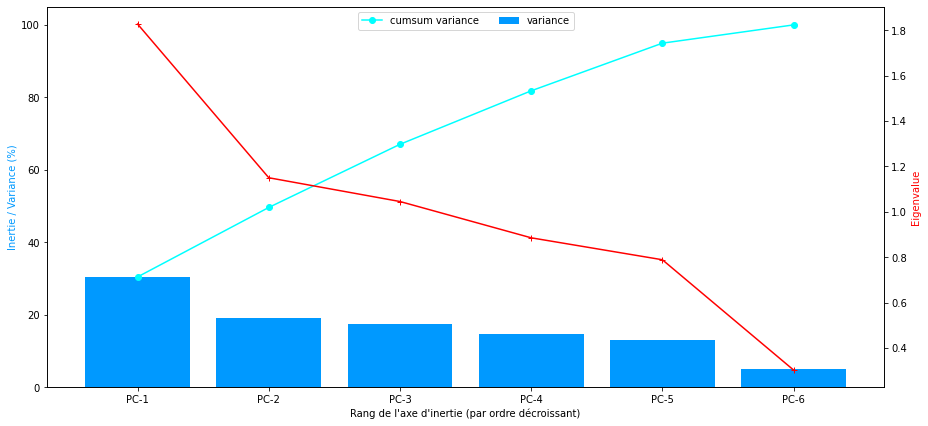

In [225]:
scree = pca.explained_variance_ratio_*100
eigenvalues = pca.explained_variance_
titles = [f"PC-{i+1}" for i in range(pca.n_components)]

fig = plt.figure(figsize=(15,7))
axis_1 = fig.add_subplot(111)
axis_1.bar(titles, scree, label='variance', color='#0099FF')
axis_1.plot(titles, scree.cumsum(),c="cyan",marker='o', label='cumsum variance')
axis_1.set_ylabel(r"Inertie / Variance (%)", color='#0099FF')
axis_1.set_xlabel(r"Rang de l'axe d'inertie (par ordre décroissant)")
axis_1.legend(loc=9, ncol=2)

axis_2 = axis_1.twinx()
axis_2.plot(titles, eigenvalues,c="red",marker='+', label="eigenvalues")
axis_2.set_ylabel(r"Eigenvalue", color='#FF0000')
#axis_2.legend(loc=5)

plt.show()

In [226]:
egeinvalues = pd.DataFrame({"egeinvalue":pca.explained_variance_, "egeinvalue ratio":pca.explained_variance_ratio_}, index=[i+1 for i in range(pca.n_components)])
egeinvalues['cumsum_ratio'] = egeinvalues['egeinvalue ratio'].cumsum()
egeinvalues


egeinvalue  egeinvalue ratio  cumsum_ratio
1        1.83              0.30          0.30
2        1.15              0.19          0.50
3        1.05              0.17          0.67
4        0.89              0.15          0.82
5        0.79              0.13          0.95
6        0.30              0.05          1.00

A partir de cet éboulis des valeurs propres, on peut déterminer quel fraction il convient de garder pour créer un jeu de données allegé tout en minimisant les pertes d'information.<br>
Pour ce faire il existe *(au moins)* 3 méthodes que voici:

> Si l'on utilise la **méthode du coude**, il convient de choisir **2** *composantes principales*.

> Si l'on cherche à **retenir au moins 90% de la variance**, on voit qu'il faut garder **5** *composantes principales*. <br>*(Notons que les 2 premières composantes, possèdent 50% de l'inertie à elles seules)*

> Si l'on se fie au **critère de Keiser**, une composante principale doit représenter au moins (100/nombre_composants)% *(ici 100/6=16.66%)* pour présenter de l'intérêt. Dans le cas présent, ce sont les **3** *premières composantes principales*.


Mais dans l'immédiat, nous ne cherchons pas à réduire notre jeu de données, mais simplement à en faciliter la lecture et la compréhension.<br>
Nous allons donc travailler avec 4 premiers plans factoriels *(donc les 5 premières composantes principales)*.

#### Projetons le jeu de données dans le nouvel espace

In [227]:
X_projected = pca.transform(X_scaled)
X_projected_pd = pd.DataFrame(X_projected)
X_projected_pd.shape

(1718755, 6)

### 5.3.2 Étudions la variabilité des individus (leurs ressemblances et différences)

In [228]:
data_tmp = data_clean.copy()

In [229]:
data_tmp.reset_index(inplace=True, drop=True)

#### Regardons les `nutriscore_grade` sous l'angle des divers plans factoriels trouvé par l'ACP

In [230]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

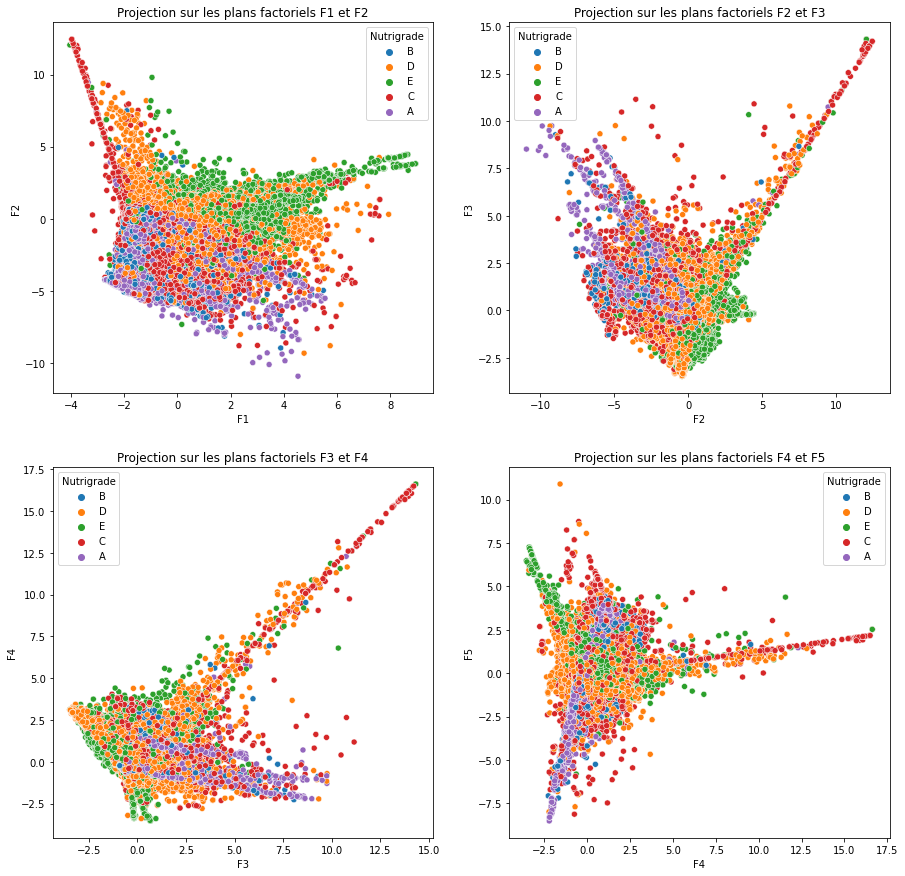

In [231]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(data=X_sample, x=i, y=i+1, hue='Nutrigrade')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")

plt.show()

> Sur les deux premiers graphiques, on constate que les produits avec des `nutriscore_grade` similaires ont tendance à se regrouper en clusters. Ce n'est pas clairement visible pour tous les grades cependant.

#### Regardons les catégories `pnns_groups_2` sous l'angle des divers plans factoriels trouvé par l'ACP

In [232]:
num_cats = 10
top_categories = list(data_tmp['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

In [233]:
Sample_index = data_tmp[ data_tmp.pnns_groups_2.isin(top_categories) ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Categories'] = data_tmp.loc[Sample_index]['pnns_groups_2']

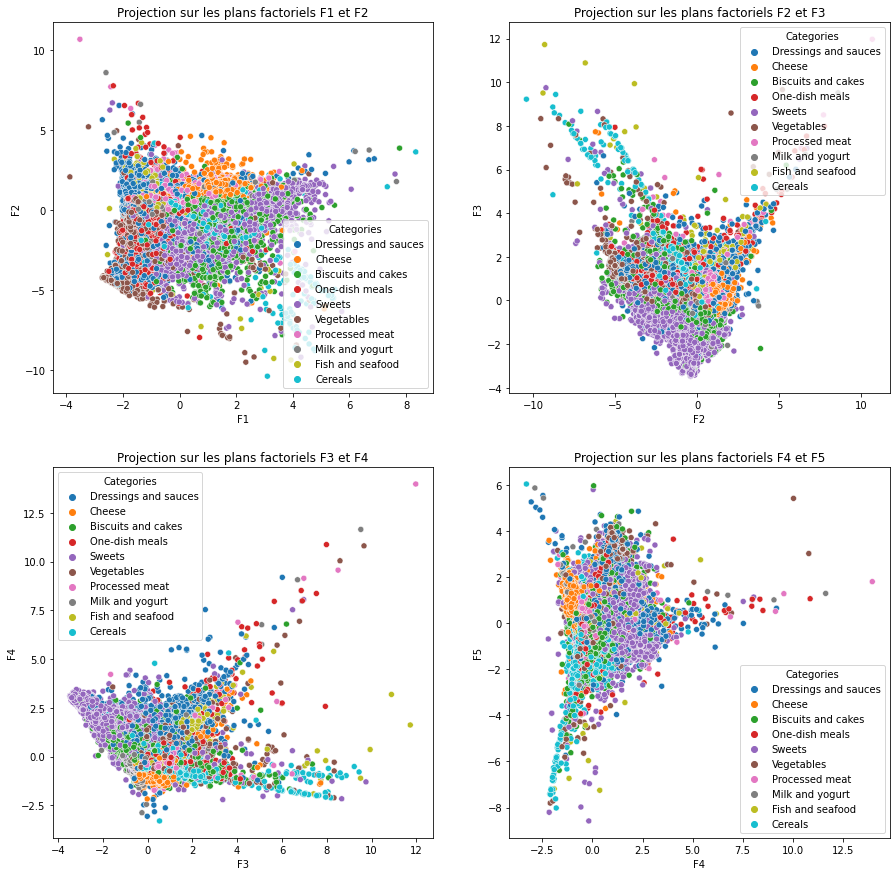

In [234]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(data=X_sample, x=i, y=i+1, hue='Categories')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")

plt.show()

> On constate que les produits avec des catégories `pnns_groups_2` similaires ont tendance à se regrouper en clusters.

### 5.3.3 Étudions les liaisons entre les variables

#### Affichons le tableau des corrélations de chaque composante principale avec les colonnes retenues

In [235]:
pcs = pca.components_

In [236]:
comp_all = pd.DataFrame(pcs, columns=X.columns, index=[f"F{x+1}" for x in range(len(pcs))])

<AxesSubplot:>

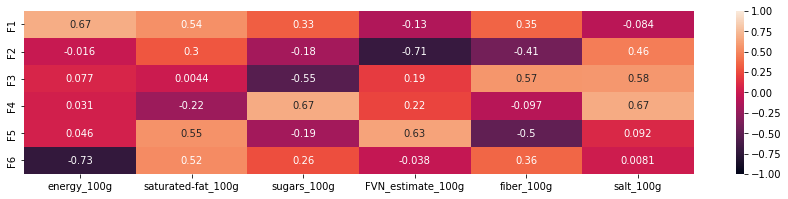

In [237]:
plt.figure(figsize=(15,3))
sns.heatmap(comp_all, vmin=-1, vmax=1, annot=True)

energy_100g = 0.67
saturated-fat_100g = 0.54
fiber_100g = 0.35
sugars_100g = 0.33

#### Affichons les moyennes par `nutriscore_grade` des valeurs sur chaque composante principales

In [238]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

In [239]:
pcs_grades = []
grades = ['A','B','C','D','E']
for grade in grades:
    pcs_grades.append(list(X_sample[ X_sample.Nutrigrade == grade].mean(numeric_only=True)))
 
pcs_grades_pd = pd.DataFrame(pcs_grades, index=grades, columns=[f"F{x+1}" for x in range(len(pcs))]).T

<AxesSubplot:>

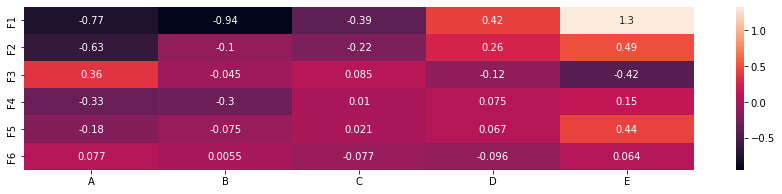

In [240]:
plt.figure(figsize=(15,3))
sns.heatmap(pcs_grades_pd, annot=True)

> - F1 fait une grosse différence entre les grades A,B,C d'une part et D,E d'autre part.
> - F2 fait à peu près la même chose mais en moins accentué et s'intéresse nettement moins à B.
> - F3 inverse la tendance et ne s'occupe plus que des extrêmes (A,E ou D dans une moins mesure).

#### Affichons les cercles de corrélations des divers plans factoriels

In [241]:
# Définissons une fonction permettant d'afficher les cercles de corrélations

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)

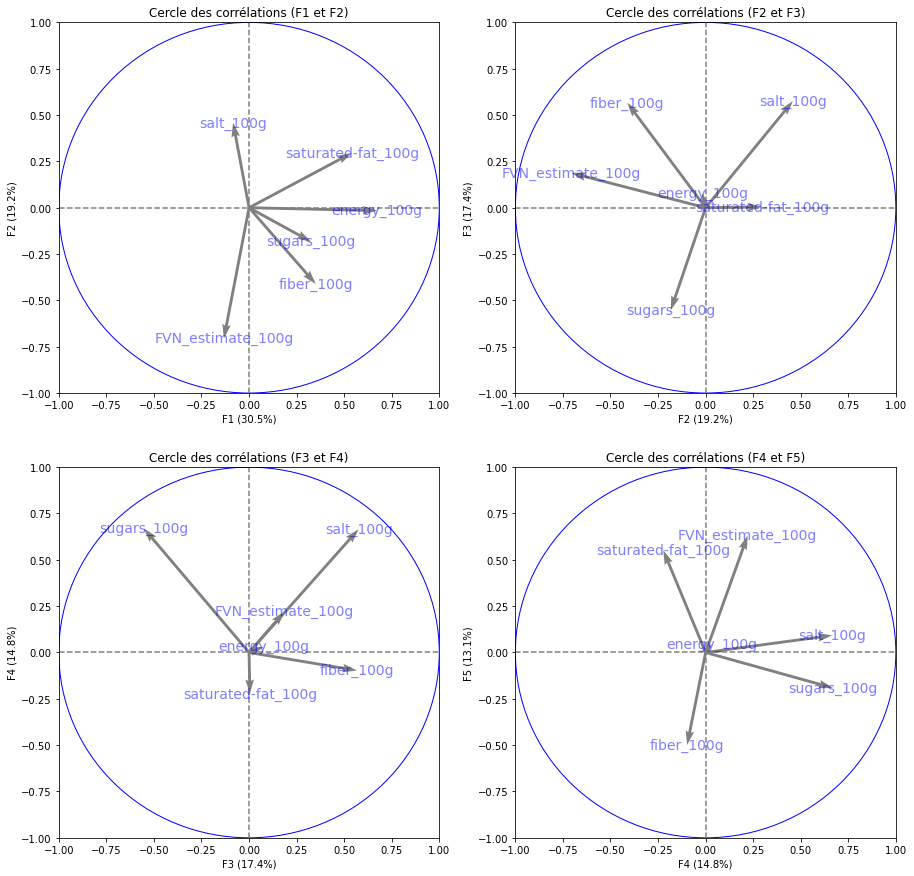

In [242]:
fig = plt.figure(figsize=(15,15))

num_p = 4
for i in range(num_p):
    ax = fig.add_subplot(2,2,i+1)
    display_circles(pcs, num_p+1, pca, [(i,i+1)], labels = X.columns, label_rotation=0)
    
plt.show()

L'angle entre deux vecteurs indique leur coefficient de correlation.<br>Plus la pointe d'un vecteur se rapproche du cercle et mieux le vecteur est représenté dans le plan étudié <br>(+1 ou -1 sont donc des représentations parfaites sur la composante).

> Sur **F1**, les colonnes suivantes ressortent:
> - `energy_100g` = 0.67
> - `saturat<ed-fat_100g` = 0.54
> - `fiber_100g` = 0.35
> - `sugars_100g` = 0.33
> 
>> Cette première composante principale pourrait être un axe basé sur **l'apport énergetique**.

> Sur **F2**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.46
> - `saturated-fat_100g`
> - `fiber_100g` = -0.41
> - `FVN_estimate_100g` = -0.71
> 
>> Cette seconde composante principale pourrait être un axe basé qui oppose les produits plutôt **gras** aux produits plutôt **secs**.

> Sur **F3**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.58
> - `fiber_100g` = 0.57
> - `sugars_100g` = -0.55
> 
>> Cette troisième composante principale pourrait être un axe qui oppose les produits **salés** aux produits **sucrés**.

## 5.4 Test statistique<a class="anchor" id="anova"></a>

Nous allons à présent vérifier statistiquement si les constatations faites précèdement concernant le rapport entre les differents `nutriscore_grade` et les indicateurs nutrionnels sélectionnés `energy_100g`, `saturated-fat_100g`, `sugars_100g`, `FVN_estimate_100g`, `fiber_100g`, `salt_100g`, sont **significatifs ou non**.

Commençons par établir les hypothèses que nous allons utiliser pour chaque indicateur nutritionnel conservé:
- **Notre Hypothèse nulle $H_0$ :** tous les grades ont des indicateurs nutrionnels similaires; *(on ne peut pas différentier les grades sur cette base)*.
- **Notre Hypothèse alternative $H_1$ :** au moins deux grades n'ont pas les mêmes indicateurs nutritionnels; *(on peut différencier les grades sur cette base)*

### 5.4.1 ANOVA *(ANalysis Of VAriance)*

Ce test permet comparer la différence entre deux ou plusieurs groupes/catégories de variables numériques. Donc de comparer une variable qualitatives comme le `nutriscore_grade` avec des variables quantitatives comme les indicateurs nutritionnels.

Pour être utilisable, l'ANOVA nécessite de respecter plusieurs hypothèses fondamentales:
- **Normalité de la distribution**
- **Indépendance des échantillons**

Nous avons vu lors des analyses univariées des variables numériques qu'aucune d'entre elles n'est de distribution normale. <br>Mais pour être certain, vérifions le à nouveau avec des diagrammes quantile-quantile *(QQplot)* qui ont le mérite d'être très parlant.

#### Diagrammes Quantile-Quantile

Le QQplot de comparaison d'une distribution observée avec une loi gaussienne réduite permet une validation subjective de la normalité :
- si les points sont alignés sur la première bissectrice c'est que la distribution suit probablement une loi de distribution gaussienne normalisée.
- si les points sont alignés sur une autre droite d'équation $x_i = a x_i^∗ + b$, c'est que la distribution suit une loi normale d'espérance b et d'écart type a. 

In [243]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

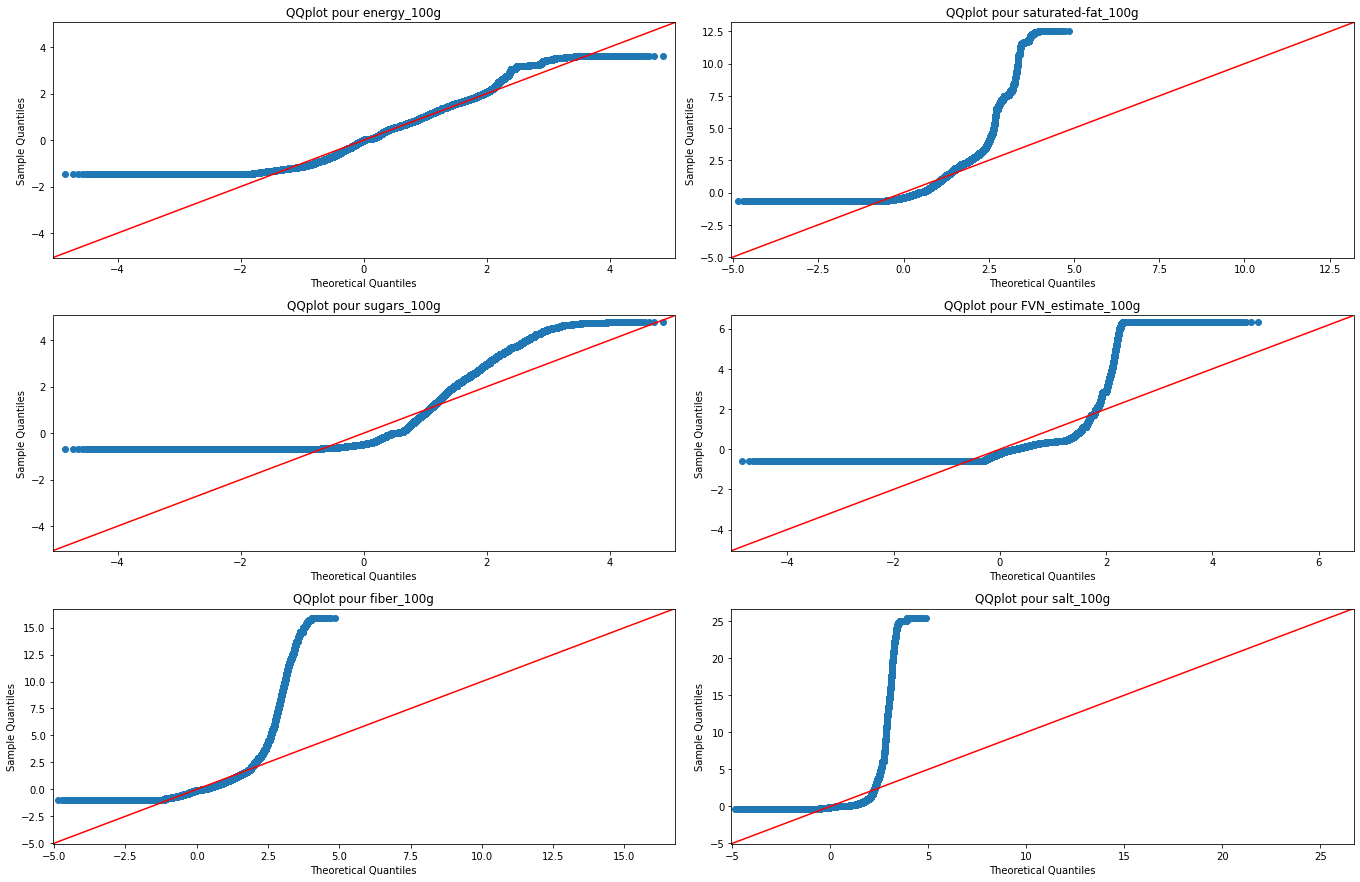

In [244]:
num_rows = math.ceil((len(var_nutri_pca)+1)/2)
fig = plt.figure(figsize=(19,num_rows*4))

for i, col in enumerate(var_nutri_pca):
    ax = fig.add_subplot(num_rows,2,i+1)
    ax.set_title(f"QQplot pour {col}")
    #ax.set_xlim(-4, 4)
    #ax.set_ylim(-4, 4)
    qqplot(data_clean[data_clean[col].notnull()][col], norm, fit=True, line="45", ax=ax)
    
fig.tight_layout()
plt.show()

> On constate donc qu'**aucune des variables numériques considérées n'a une distribution normale**.
>
> Il n'est donc pas raisonnable d'utiliser l'ANOVA pour tester la significativité de la variance entre les différents `nutriscore_grade`.
>
> Heureusement, il existe une alternative qui ne nécessite pas d'avoir une distribution normale; le **test de Kruskal-Wallis** qui au lieu de s'intéresser à la variance, se concentre sur les médianes.

### 5.4.2 Kruskal-Wallis
Cette alternative non paramétrique est utilisée comme l'ANOVA pour tester si des échantillons trouvent leur origine dans la même distribution. <br>Mais elle s'intéresse aux médianes de k populations ( k ⩾ 3) au lieu de leur variance.

- **Hypothèse nulle $H_0$ du test de Kruskal-Wallis :** toutes les médianes sont égales; les k échantillons sont confondus et proviennent d'un même échantillon d'une population.
- **Hypothèse alternative $H_1$ du  test de Kruskal-Wallis :** au moins une médiane est différente; les k échantillons ne sont PAS confondus et il existe une relation entre eux.

**Note:** Le test permet de comparer deux ou plusieurs échantillons indépendants **de taille similaire ou non**.

In [245]:
from scipy import stats

In [246]:
data_drop = data_clean[var_nutri_pca].copy()
#data_drop['nutriscore_score'] = data_clean['nutriscore_score']
data_drop['nutriscore_grade'] = data_clean['nutriscore_grade']
data_drop.shape

(1718755, 7)

#### Supprimons les lignes avec des valeurs nulles (donc les lignes sans nutriscore_grade)

In [247]:
data_drop.dropna(inplace=True)
data_drop.shape

(701087, 7)

#### Calculons la p-valeur et la statistique de test pour chaque indicateur nutritionnel sélectionné

In [248]:
for col in var_nutri_pca:
    s, p = stats.kruskal(*[data_drop[data_drop.nutriscore_grade == x][col] for x in ['A','B','C','D','E']])
    if p < 0.05:
        result="H0 est rejetée"
    else:
        result="H0 est validée"
    print(f"{col.rjust(25)} >> statistique = {s:9.2f} | p-valeur = {p:.2f} | {result}")

              energy_100g >> statistique = 202896.71 | p-valeur = 0.00 | H0 est rejetée
       saturated-fat_100g >> statistique = 225609.02 | p-valeur = 0.00 | H0 est rejetée
              sugars_100g >> statistique =  73666.14 | p-valeur = 0.00 | H0 est rejetée
        FVN_estimate_100g >> statistique =  20170.78 | p-valeur = 0.00 | H0 est rejetée
               fiber_100g >> statistique =  15162.67 | p-valeur = 0.00 | H0 est rejetée
                salt_100g >> statistique =  83647.00 | p-valeur = 0.00 | H0 est rejetée


> On constate que pour chaque indicateur nutritionnel, la p-valeur du test de Kruskal-Wallis est **inférieure à un niveau de test ($\alpha$) de 0.05** *(5%)*, et donc l'**hypothèse nulle $H_0$ est rejetée** à chaque fois.
>
> Rappelons les hypothèses:
>> - **Notre Hypothèse nulle $H_0$ :** toutes les médianes de cet indicateur nutritionnel pour les grade A, B, C, D et E sont égales; on ne peut différencier les grades avec cet indicateur.
>> - **Notre Hypothèse alternative $H_1$ :** au moins une médiane de cet indicateur nutritionnel pour les grade A, B, C, D et E, est différente; on peut différencier les grades avec cet indicateur.

> **L'ensemble du test confirme donc que ces differents indicateurs nutritionnels peuvent être des variables utiles pour un modèle prédictif dont le but est de prédire le `nutriscore_grade`.**

# 6. Conclusions sur la faisabilité de l'application<a class="anchor" id="conclusion"></a>

1. Les analyses de données et le test statistiques indiquent qu'il est **raisonnable de s'appuyer sur les colonnes nutritionnelles sélectionnées pour prédire le `nutriscore_score` ou le `nutriscore_grade`**.


2. L'ACP montrent que **la dimensionnalité du jeu de donnée pourrait être légèrement réduite** tout en conservant un pouvoir prédictif sensiblement équivalent.


3. Sur la base de cette EDA, on peut prendre **deux directions pour le modèle prédictif** : prédire le nutriscore_grade directement ou prédire le nutriscore_score puis le convertir en nutriscore_grade.